In [2]:
#import required libraries
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#import math
#import re
import glob
import json
import os
from scipy.stats import pearsonr, spearmanr

#import torch
#import torch.nn as nn
#import torch.nn.functional as F


from NegativeClassOptimization import ml, visualisations
from NegativeClassOptimization import config, utils
from NegativeClassOptimization import preprocessing, datasets

Fontconfig warning: ignoring UTF-8: not a valid region tag


In [3]:
pellets = {'color_blind_light':['#a2c8ec','#cfcfcf', '#ffbc79'], 
'color_blind_dark':['#5CA7E5','#ababab', '#ff7700'],
'r_like':['#94669E', '#F2D81D', '#00817A'],
'chat_gpt': ['#FFC300', '#FF5733', '#00A6ED'],
'antigens': ['#008080','#FFA07A','#000080','#FFD700','#228B22','#FF69B4','#800080','#FF6347','#00FF00','#FF1493']}

cmap = { 'vs 9' : '#FF5733',
         'vs Non-binder':'#00A6ED',
         'vs Weak':'#FFC300',
         'vs 1': '#8B5F4D'}
task_2_dataset = {"ONE_VS_NINE": datasets.ClassificationTaskType.ONE_VS_NINE,
"HIGH_VS_95LOW": datasets.ClassificationTaskType.HIGH_VS_95LOW,
"HIGH_VS_LOOSER": datasets.ClassificationTaskType.HIGH_VS_LOOSER}


In [4]:
#might be needed copied from Eugen
from itertools import permutations


task_types = (
    datasets.ClassificationTaskType.ONE_VS_ONE,
    datasets.ClassificationTaskType.ONE_VS_NINE,
    datasets.ClassificationTaskType.HIGH_VS_95LOW,
    datasets.ClassificationTaskType.HIGH_VS_LOOSER,
)

loader = datasets.FrozenMiniAbsolutMLLoader(
    data_dir=Path("./torch_models/Frozen_MiniAbsolut_ML/")
)

"""def task_generator(task_types=task_types, loader=loader):
    
    #Generate tasks for which to compute attributions.

    # Generate 1v1
    seed_split_ids = datasets.FrozenMiniAbsolutMLLoader.generate_seed_split_ids()
    for ag_1, ag_2 in permutations(config.ANTIGENS, r=2):
        for seed_id, split_id in seed_split_ids:            
            task = datasets.ClassificationTask(
                task_type=datasets.ClassificationTaskType.ONE_VS_ONE,
                ag_pos=ag_1,
                ag_neg=ag_2,
                seed_id=seed_id,
                split_id=split_id,
            )
            yield task
    
    # Generate the rest: 1v9, high vs 95low, high vs looser
    seed_split_ids = datasets.FrozenMiniAbsolutMLLoader.generate_seed_split_ids()
    for ag_1 in config.ANTIGENS:
        for seed_id, split_id in seed_split_ids:
            for task_type in task_types:
                
                if task_type == datasets.ClassificationTaskType.ONE_VS_ONE:
                    continue
                
                task = datasets.ClassificationTask(
                    task_type=task_type,
                    ag_pos=ag_1,
                    ag_neg="auto",
                    seed_id=seed_id,
                    split_id=split_id,
                )
                yield task"""


def get_miniabsolut_dataframes(task, load_energy_contributions=False):
    """Load the dataframes based on MiniAbsolut, from task
    These dataframes contain extra info, such as binding energies.
    """
    #if task.split_id == 42:
        #miniabsolut_path = Path("..//MiniAdatabsolut")
    #elif task.split_id in [0, 1, 2, 3, 4]:
        #miniabsolut_path = Path(f"../data/MiniAbsolut_Splits/MiniAbsolut_Seed{task.split_id}")

    miniabsolut_path = Path(f"../data/MiniAbsolut_Splits/MiniAbsolut_Seed4")
    
    ag_pos_dir = miniabsolut_path / task.ag_pos
    if load_energy_contributions:
        ag_pos_dir = ag_pos_dir / "energy_contributions"
        suffix = "_absolut_energy_contributions"
        header = 1
    else:
        suffix = ""
        header = 0
    
    df_pos = pd.read_csv(ag_pos_dir / f"high_test_5000{suffix}.tsv", sep="\t", header=header)
    df_pos["class"] = "positive"

    if task.task_type == datasets.ClassificationTaskType.HIGH_VS_95LOW:
        df_neg = pd.read_csv(ag_pos_dir / f"95low_test_5000{suffix}.tsv", sep='\t', header=header)
        df_neg["class"] = "negative"
    elif task.task_type == datasets.ClassificationTaskType.HIGH_VS_LOOSER:
        df_neg = pd.read_csv(ag_pos_dir / f"looserX_test_5000{suffix}.tsv", sep='\t', header=header)
        df_neg["class"] = "negative"
    elif task.task_type in (datasets.ClassificationTaskType.ONE_VS_ONE, datasets.ClassificationTaskType.ONE_VS_NINE):
        # raise ValueError("Not implemented.")
        df_neg = pd.DataFrame()
    
    df = pd.concat([df_pos, df_neg], axis=0)
    
    return df

In [5]:
"""#part of this will be useful, copied from Eugen
logit_energy_corr_path = "../data/Frozen_MiniAbsolut_ML/07e_LogitEnergyCorrelations.tsv"
force_run = False
skip_errors_logits = True

if Path(logit_energy_corr_path).exists() and not force_run:
    df_logits = pd.read_csv(logit_energy_corr_path, sep="\t")
else:

    records = []
    for task in task_generator():
        
        if skip_errors_logits:
            try:
                task = loader.load(task, attributions_toload="v2.0-2")
            except:
                continue
        else:
            task = loader.load(task, attributions_toload="v2.0-2")"""

'#part of this will be useful, copied from Eugen\nlogit_energy_corr_path = "../data/Frozen_MiniAbsolut_ML/07e_LogitEnergyCorrelations.tsv"\nforce_run = False\nskip_errors_logits = True\n\nif Path(logit_energy_corr_path).exists() and not force_run:\n    df_logits = pd.read_csv(logit_energy_corr_path, sep="\t")\nelse:\n\n    records = []\n    for task in task_generator():\n        \n        if skip_errors_logits:\n            try:\n                task = loader.load(task, attributions_toload="v2.0-2")\n            except:\n                continue\n        else:\n            task = loader.load(task, attributions_toload="v2.0-2")'

In [6]:
### s
def get_attr_from_records(records, attributor_name, y_true):
    """Get the attributions for a given attributor and y_true."""
    attr = np.stack(
        list(map(
            lambda x: np.array(x[attributor_name]).reshape((11, 20)),
            filter(lambda x: x["y_true"] in y_true, records)
        )))
        
    return attr

def get_onehotstack_from_records(records, y_true = (0, 1)):
    """Get the onehot stack from the records."""
    slides = [record["slide"] for record in records if record["y_true"] in y_true]
    onehots = [preprocessing.onehot_encode(slide) for slide in slides]
    onehot_stack = np.stack(onehots)
    return onehot_stack
    
def load_energy_contributions_from_task(task, load_slide_df = False, attributions_toload="v2.0-2", attributor_name = "DeepLIFT_LOCAL_v2.0-2"):

    # Get energy contributions and attributions
    df = get_miniabsolut_dataframes(task, load_energy_contributions=True)
    energy_dict = df.set_index("Slide").to_dict(orient="index")
    for slide in energy_dict.keys():
        energy_dict[slide]["energies"] = utils.extract_contributions_from_string(energy_dict[slide]["contribPerAAparaBind"])[1]
        energy_dict[slide]["energies_fold"] = utils.extract_contributions_from_string(energy_dict[slide]["contribPerAAparaFold"])[1]
        energy_dict[slide]["energies_total"] = (np.array(energy_dict[slide]["energies"]) + np.array(energy_dict[slide]["energies_fold"])).tolist()

    # Get attributions per amino acid
    task = loader.load(task, attributions_toload=attributions_toload)
    attributor_name = attributor_name
    attr_stack = get_attr_from_records(task.attributions, attributor_name, (0, 1))  # Nx11x20
    onehot_stack = get_onehotstack_from_records(task.attributions, (0, 1))  # Nx220
    attr_aa = attr_stack[onehot_stack.reshape((-1, 11, 20)) == 1].reshape(-1, 11)  # Nx11
    attr_dict = {record["slide"]: {**record, **{"attribution_existingaa": attr_aa[i, :]}}
                for i, record in enumerate(task.attributions)}

    #add here option to load reveal_cancel_attributions

    # Combine dictionaries
    slide_records = []
    
    #for slide in energy_dict.keys():
    comon_slides = set(attr_dict.keys()).intersection(set(energy_dict.keys()))
    for slide in comon_slides:
        dataset_class = energy_dict[slide]["class"]
        energies = energy_dict[slide]["energies"]
        energies_fold = energy_dict[slide]["energies_fold"]
        energies_total = energy_dict[slide]["energies_total"]
        attrs = attr_dict[slide]["attribution_existingaa"]
        
        # Correlation between energy and attribution with scipy
        r, p = pearsonr(energies, attrs)
        r_fold, p_fold = pearsonr(energies_fold, attrs)
        r_total, p_total = pearsonr(energies_total, attrs)
        slide_records.append({
            "slide": slide,
            "class": dataset_class,
            "energies": energies,
            "attributions": attrs,
            "r": r,
            "p": p,
            "r_fold": r_fold,
            "p_fold": p_fold,
            "r_total": r_total,
            "p_total": p_total,
        })
    slide_df = pd.DataFrame.from_records(slide_records)
    
    mean = slide_df["r"].mean()
    std = slide_df["r"].std()
    mean_pos = slide_df[slide_df["class"] == "positive"]["r"].mean()
    std_pos = slide_df[slide_df["class"] == "positive"]["r"].std()
    mean_neg = slide_df[slide_df["class"] == "negative"]["r"].mean()
    std_neg = slide_df[slide_df["class"] == "negative"]["r"].std()

    mean_fold = slide_df["r_fold"].mean()
    std_fold = slide_df["r_fold"].std()
    mean_pos_fold = slide_df[slide_df["class"] == "positive"]["r_fold"].mean()
    std_pos_fold = slide_df[slide_df["class"] == "positive"]["r_fold"].std()
    mean_neg_fold = slide_df[slide_df["class"] == "negative"]["r_fold"].mean()
    std_neg_fold = slide_df[slide_df["class"] == "negative"]["r_fold"].std()

    mean_total = slide_df["r_total"].mean()
    std_total = slide_df["r_total"].std()
    mean_pos_total = slide_df[slide_df["class"] == "positive"]["r_total"].mean()
    std_pos_total = slide_df[slide_df["class"] == "positive"]["r_total"].std()
    mean_neg_total = slide_df[slide_df["class"] == "negative"]["r_total"].mean()
    std_neg_total = slide_df[slide_df["class"] == "negative"]["r_total"].std()
    
    stats = {
        "task_type": task.task_type.to_str(),
        "ag_pos": task.ag_pos,
        "ag_neg": task.ag_neg,
        "seed_id": task.seed_id,
        "split_id": task.split_id,
        "mean": mean,
        "std": std,
        "mean_pos": mean_pos,
        "std_pos": std_pos,
        "mean_neg": mean_neg,
        "std_neg": std_neg,
        "mean_fold": mean_fold,
        "std_fold": std_fold,
        "mean_pos_fold": mean_pos_fold,
        "std_pos_fold": std_pos_fold,
        "mean_neg_fold": mean_neg_fold,
        "std_neg_fold": std_neg_fold,
        "mean_total": mean_total,
        "std_total": std_total,
        "mean_pos_total": mean_pos_total,
        "std_pos_total": std_pos_total,
        "mean_neg_total": mean_neg_total,
        "std_neg_total": std_neg_total,
    }
    if load_slide_df:
        return stats, slide_df
    else:
        return stats
    

In [7]:
#trial
task_type = datasets.ClassificationTaskType.ONE_VS_NINE
ag_1 = '1ADQ'
split_id = 4
seed_id = 0
task = datasets.ClassificationTask(
                    task_type=task_type,
                    ag_pos=ag_1,
                    ag_neg="auto",
                    seed_id=seed_id,
                    split_id=split_id,
                )
df_1ADQ_eng = get_miniabsolut_dataframes(task, load_energy_contributions=True)

In [8]:
df_1ADQ_eng["contribPerAAparaBind"].iloc[0]

'Ta:2_-5.36,Lb:3_-14.71,Ld:2_-7.32,De:1_-1.46,Wf:3_-11.43,Yg:1_-4.17,Fh:4_-20.39,Di:1_-1.68,Vj:4_-20.02,Wk:3_-11.4,'

In [291]:
df_1ADQ_eng["contribPerAAparaFold"].iloc[0]

'Wf:1_-5.06,Wk:1_-5.06,'

In [36]:
#for figure 2D with reveal cancel rule
attributions_file = glob.glob("../data/deeplift_revealcancel/*")
all_stats_reveal_cancel = []
for attribution_path in attributions_file:
    file_name = os.path.basename(attribution_path)
    task_name, ag, seed, split = file_name.split("__")[:-1]
    seed = int(seed)
    split = int(split)
    task_type = task_2_dataset[task_name]#datasets.ClassificationTaskType.ONE_VS_NINE
    task = datasets.ClassificationTask(
                            task_type=task_type,
                            ag_pos=ag,
                            ag_neg="auto",
                            seed_id=seed,
                            split_id=split,
                        )
    stats = load_energy_contributions_from_task(task, load_slide_df = False, attributions_toload="reveal_cancel", attributor_name = "DeepLIFT_Reveal_cancel")
    all_stats_reveal_cancel.append(stats)

/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/opt/homebrew/anaconda3/envs/nco/lib/python3.8/s

In [38]:
df_attr_revcan = pd.DataFrame.from_records(all_stats_reveal_cancel)

In [39]:
df_attr_revcan.head()

task_type ag_pos ag_neg  seed_id  split_id      mean       std  \
0             1v9   1H0D   auto        3        42  0.497382  0.214899   
1   high_vs_95low   1ADQ   auto        0         1 -0.823794  0.099136   
2             1v9   1ADQ   auto        0         3  0.281689  0.287068   
3             1v9   3RAJ   auto        2        42 -0.772556  0.118514   
4  high_vs_looser   5E94   auto        0        42 -0.725638  0.099567   

   mean_pos   std_pos  mean_neg  ...  mean_pos_fold  std_pos_fold  \
0  0.497382  0.214899       NaN  ...       0.192526      0.284285   
1 -0.831230  0.090190 -0.716324  ...      -0.155597      0.278454   
2  0.281689  0.287068       NaN  ...       0.100107      0.308962   
3 -0.772556  0.118514       NaN  ...       0.160416      0.215182   
4 -0.725699  0.098069 -0.724880  ...       0.138596      0.226396   

   mean_neg_fold  std_neg_fold  mean_total  std_total  mean_pos_total  \
0            NaN           NaN    0.523337   0.200608        0.523337   
1      -0.262097      0.345869   -0.829518   0.095535       -0.834785   
2            NaN           NaN    0.293367   0.283500        0.293367   
3            NaN           NaN   -0.768609   0.123507       -0.768609   
4       0.044330      0.258773   -0.743834   0.082856       -0.743258   

   std_pos_total  mean_neg_total  std_neg_total  
0       0.200608             NaN            NaN  
1       0.089617       -0.753392       0.137859  
2       0.283500             NaN            NaN  
3       0.123507             NaN            NaN  
4       0.081780       -0.750974       0.095420  

[5 rows x 23 columns]

/var/folders/ww/bptfq9n12_jbyy78qcjp7s4c0000gn/T/ipykernel_86493/85108906.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(map(lambda x: visualisations.PlotParams.map_task_type_to_clean[x], task_order))


Text(0.5, 0, 'Task')

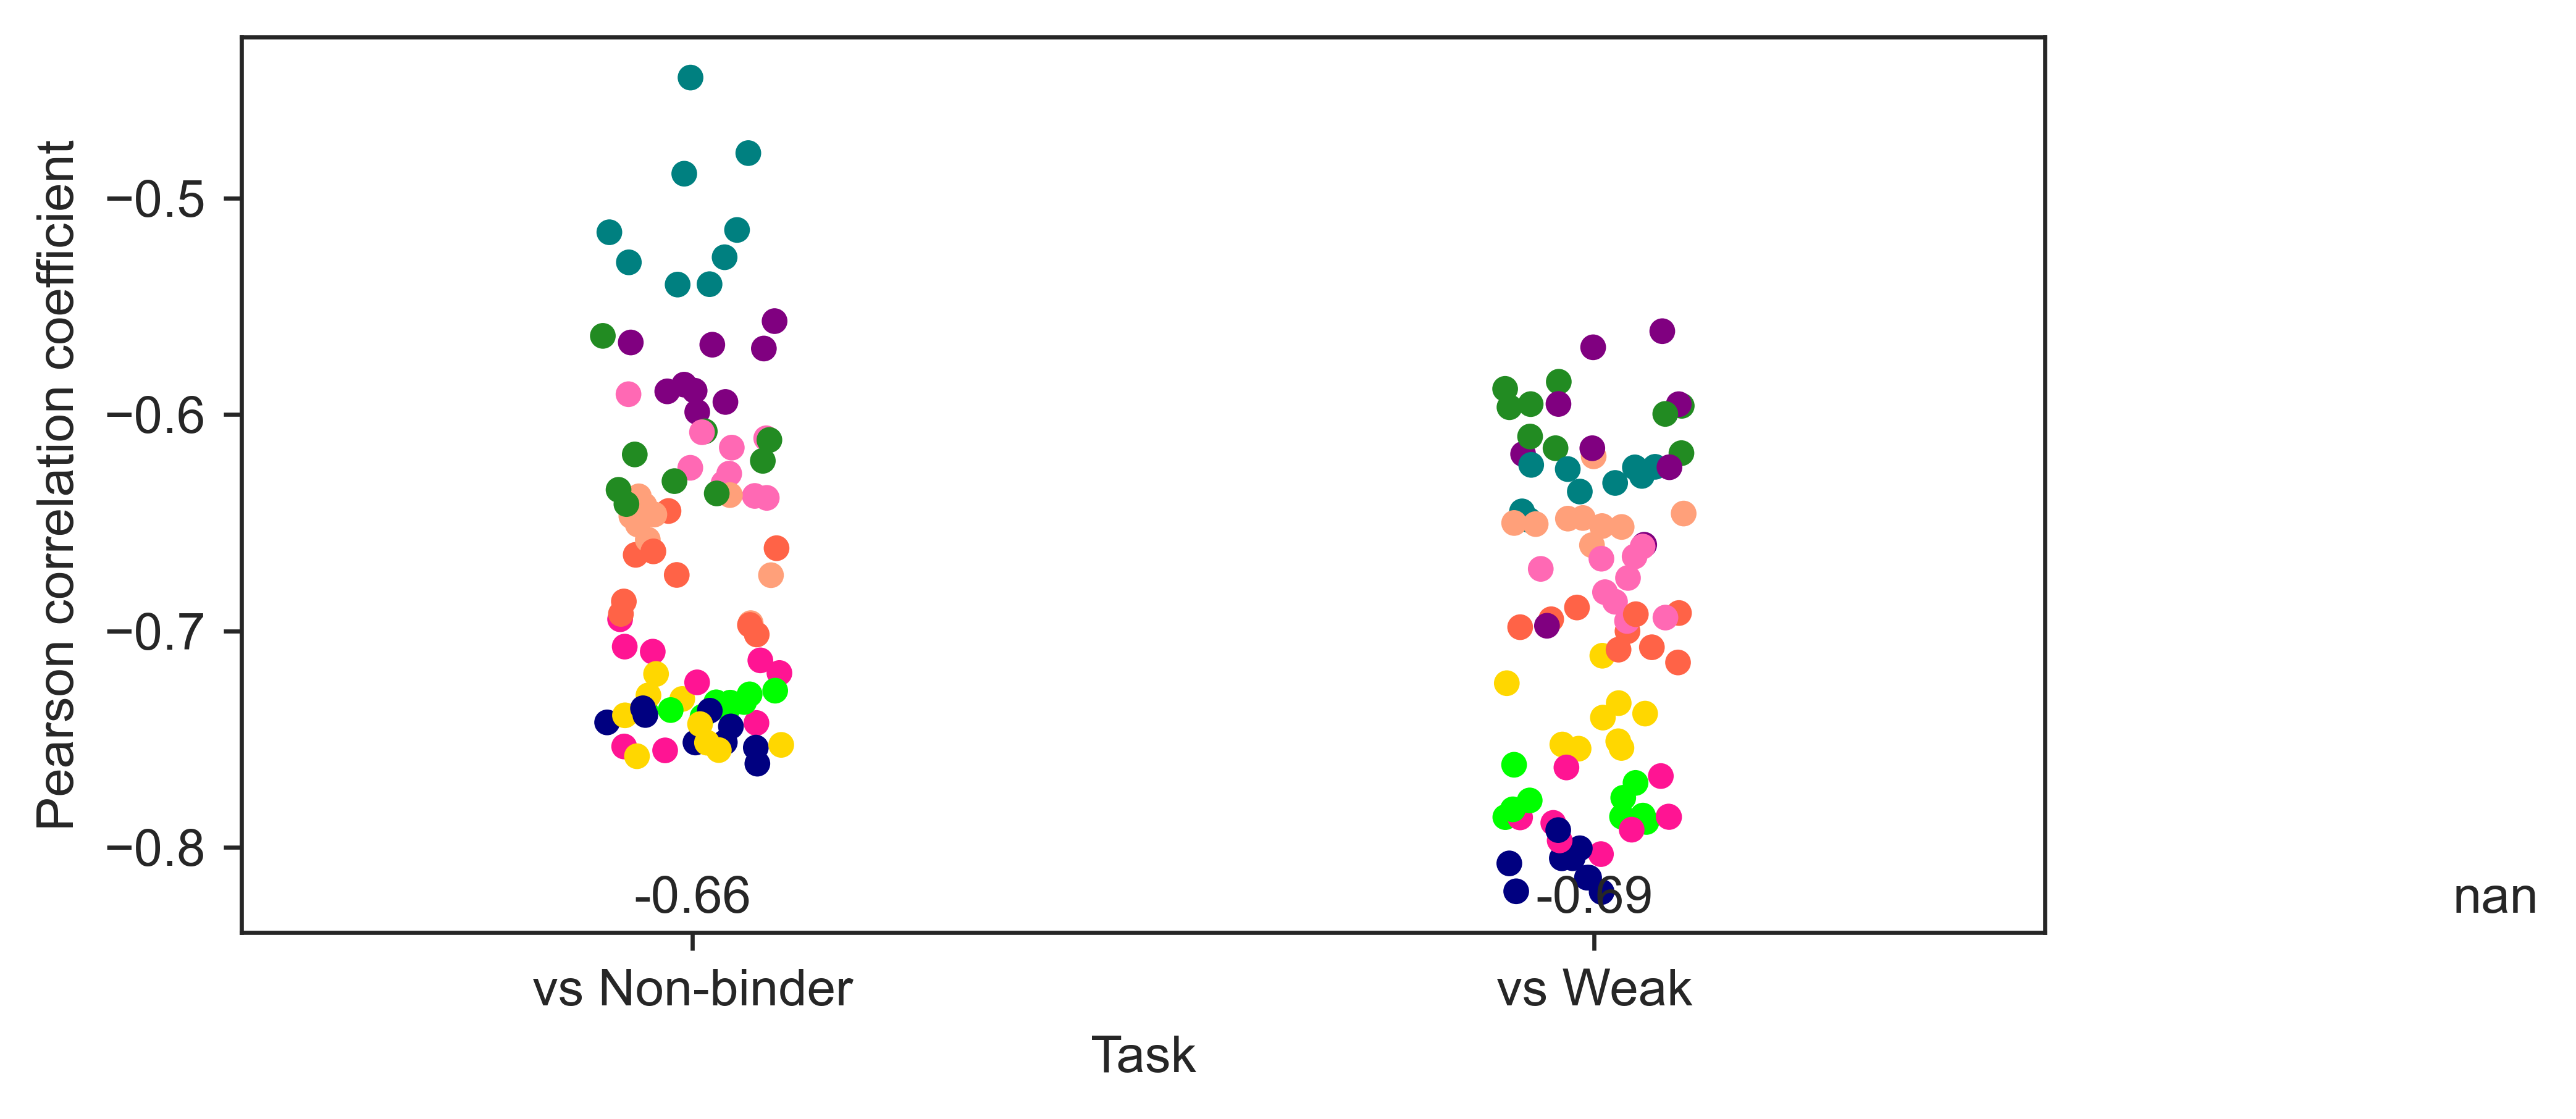

In [45]:
fig, ax = plt.subplots(figsize=(2*3.14, 3.14), dpi=600)
sns.set_style("white")
sns.set_style('ticks')

task_order = ["high_vs_95low", "high_vs_looser"]
sns.stripplot(
    data=df_attr_revcan, 
    x="task_type", 
    y="mean_neg_total", 
    order=task_order,
    hue="ag_pos",
    ax=ax,
    palette=cmap_ag,
)

ax.legend_.remove()

# Relabel xticks
ax.set_xticklabels(map(lambda x: visualisations.PlotParams.map_task_type_to_clean[x], task_order))

# Add median r_neg per task
r_median_df = df_attr_revcan.groupby(["task_type"]).agg({"mean_neg_total": "median"})
for i, row in r_median_df.iterrows():
    ax.text(
        i,
        -0.83,
        f"{row['mean_neg_total']:.2f}",
        # Center center
        horizontalalignment='center',
    )

# ax.set_title("Mean{Correlation(Energycontribution, Attribution)} for negative class")
ax.set_ylabel("Pearson correlation coefficient")
ax.set_xlabel("Task")


## What model sees in negative

In [49]:
# we will look to 1ADQ positive and diff negatives 
task_type = datasets.ClassificationTaskType.HIGH_VS_95LOW
ag_1 = '1ADQ'
split_id = 4
seed_id = 0
task = datasets.ClassificationTask(
                    task_type=task_type,
                    ag_pos=ag_1,
                    ag_neg="auto",
                    seed_id=seed_id,
                    split_id=split_id,
                )
adq_stats, df_1ADQ_nb = load_energy_contributions_from_task(task, load_slide_df = True, attributions_toload="reveal_cancel", attributor_name = "DeepLIFT_Reveal_cancel")

/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [204]:
#to see wha t chat gpt has to say about this
df_1ADQ_nb[df_1ADQ_nb.columns[:4]].to_csv('adq_nb_eng_atr.csv')

In [155]:
df_1ADQ_nb_neg = df_1ADQ_nb[df_1ADQ_nb['class'] == 'negative']
df_1ADQ_pos_nb = df_1ADQ_nb[df_1ADQ_nb['class'] == 'positive']

In [156]:
x_bind = np.array(df_1ADQ_pos_nb['energies'].to_list())
x_nb = np.array(df_1ADQ_nb_neg['energies'].to_list())

/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/seaborn/matrix.py:657: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


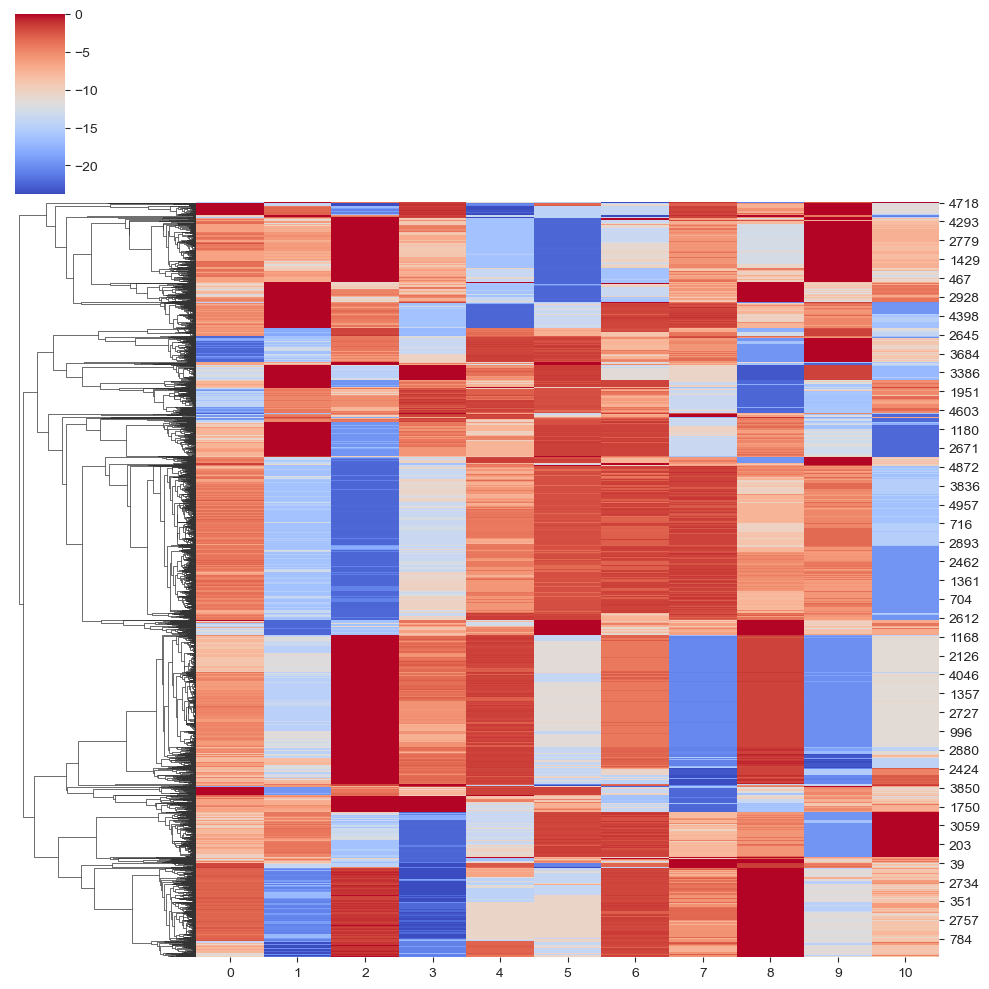

In [157]:
x_bind = np.array(df_1ADQ_pos_nb['energies'].to_list())
clust_bind_eng = sns.clustermap(x_bind, cmap='coolwarm', col_cluster=False)
row_order_bind = clust_bind_eng.dendrogram_row.reordered_ind

<AxesSubplot:>

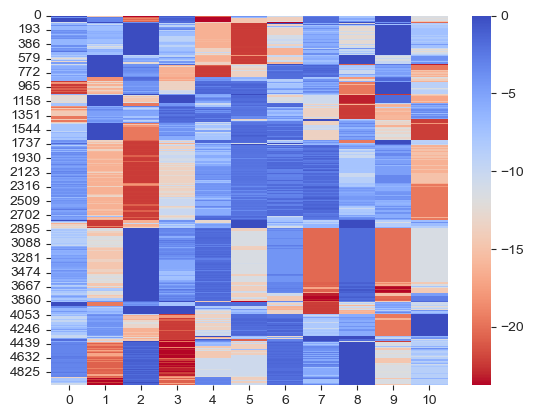

In [159]:
x_eng_bind = np.array(df_1ADQ_pos.iloc[row_order_bind]['energies'].to_list())
sns.heatmap(x_eng_bind, cmap='coolwarm_r')

<AxesSubplot:>

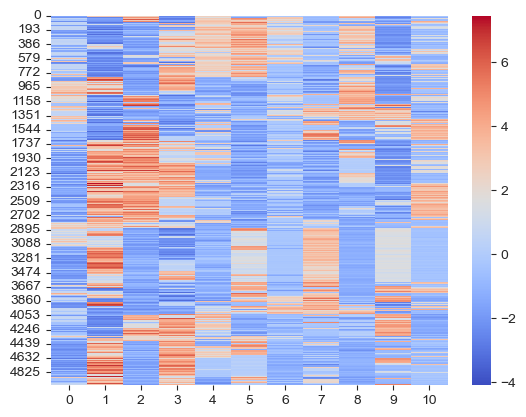

In [160]:
x_atr_bind = np.array(df_1ADQ_pos.iloc[row_order_bind]['attributions'].to_list())
sns.heatmap(x_atr_bind, cmap='coolwarm')

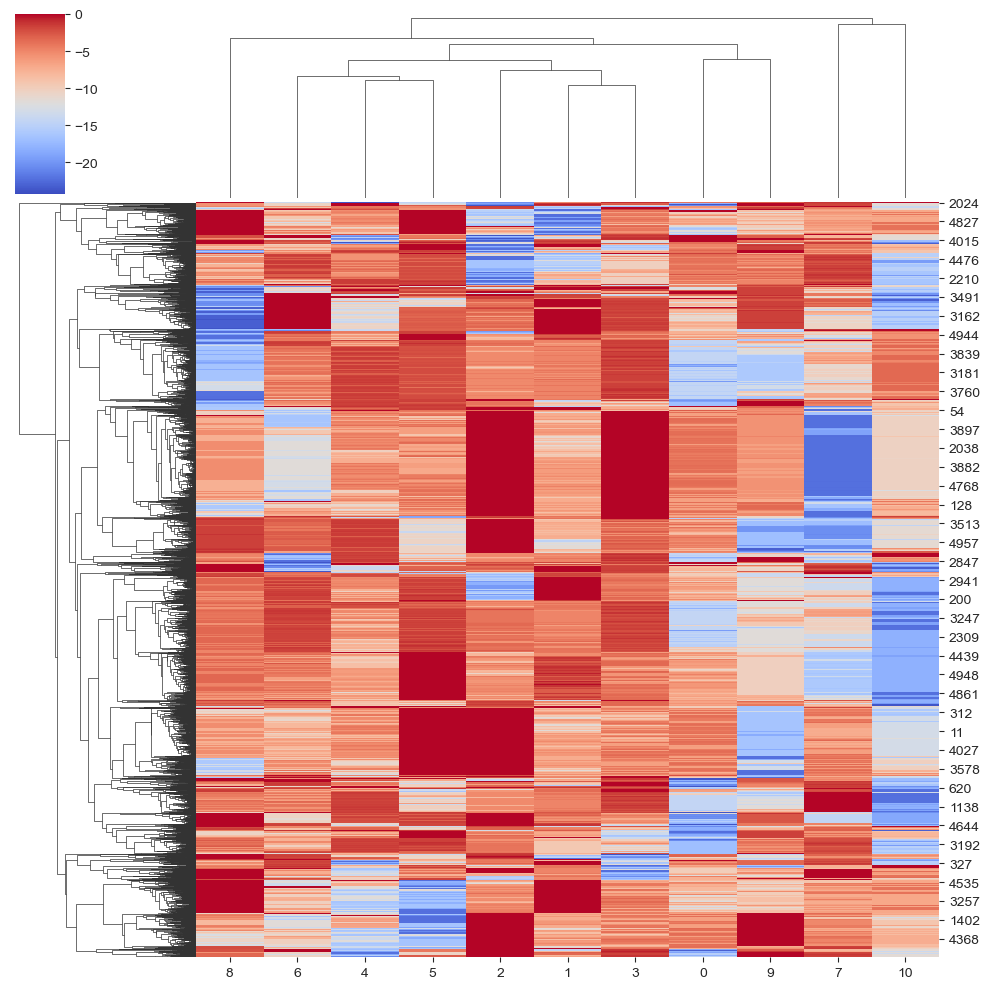

In [161]:
clust_nd_eng = sns.clustermap(x_nb, cmap='coolwarm')
row_order_nb = clust_nd_eng.dendrogram_row.reordered_ind

<AxesSubplot:>

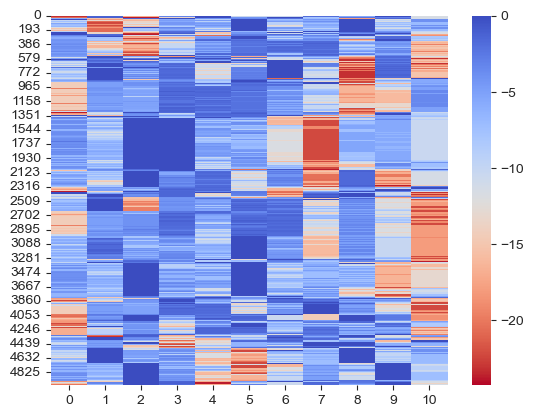

In [162]:
x_atr_nb = np.array(df_1ADQ_nb_neg.iloc[row_order_nb]['energies'].to_list())
sns.heatmap(x_atr_nb, cmap='coolwarm_r')

<AxesSubplot:>

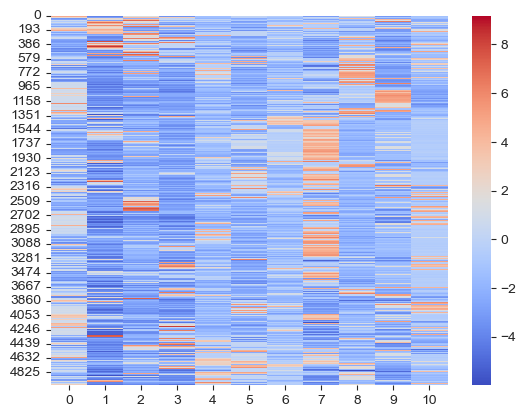

In [163]:
x_atr_nb = np.array(df_1ADQ_nb_neg.iloc[row_order_nb]['attributions'].to_list())
sns.heatmap(x_atr_nb, cmap='coolwarm')

In [164]:
task_type = datasets.ClassificationTaskType.HIGH_VS_LOOSER
ag_1 = '1ADQ'
split_id = 4
seed_id = 0
task = datasets.ClassificationTask(
                    task_type=task_type,
                    ag_pos=ag_1,
                    ag_neg="auto",
                    seed_id=seed_id,
                    split_id=split_id,
                )
adq_stats, df_1ADQ_wk = load_energy_contributions_from_task(task, load_slide_df = True, attributions_toload="reveal_cancel", attributor_name = "DeepLIFT_Reveal_cancel")

/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [165]:
df_1ADQ_wk_neg = df_1ADQ_nb[df_1ADQ_wk['class'] == 'negative']
df_1ADQ_pos_wk = df_1ADQ_nb[df_1ADQ_wk['class'] == 'positive']
x_nb = np.array(df_1ADQ_wk_neg['energies'].to_list())

/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/seaborn/matrix.py:657: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


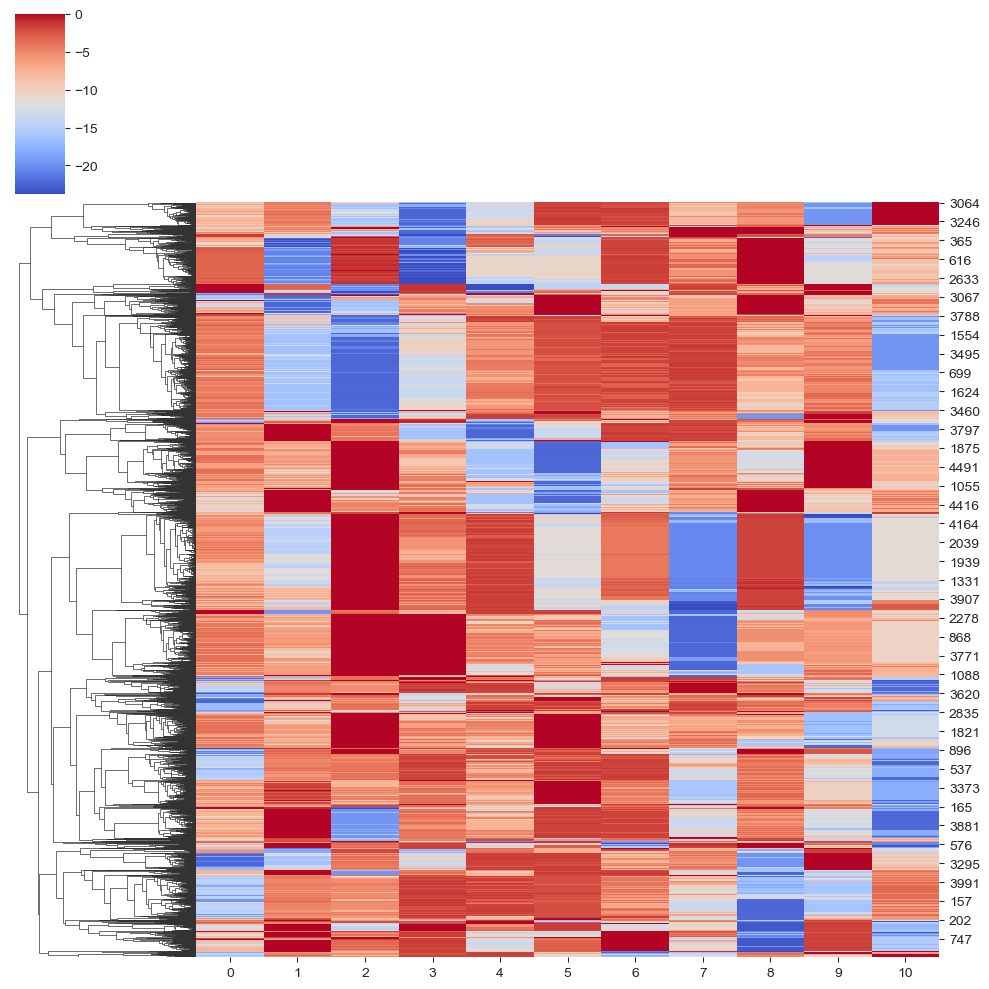

In [168]:
x_bind = np.array(df_1ADQ_pos_wk['energies'].to_list())
clust_bind_eng = sns.clustermap(x_bind, cmap='coolwarm', col_cluster=False)
row_order_bind = clust_bind_eng.dendrogram_row.reordered_ind

<AxesSubplot:>

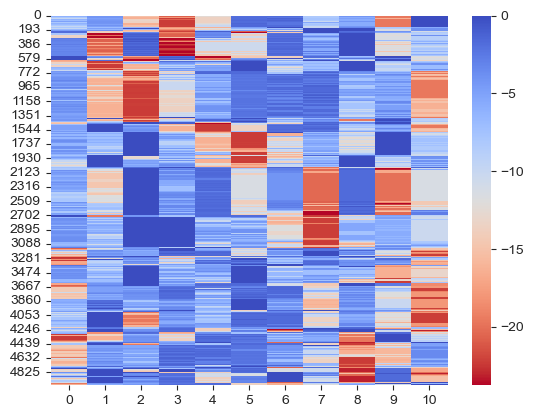

In [170]:
x_atr_bind_wk = np.array(df_1ADQ_pos_wk.iloc[row_order_bind]['energies'].to_list())
sns.heatmap(x_atr_bind_wk, cmap='coolwarm_r')

<AxesSubplot:>

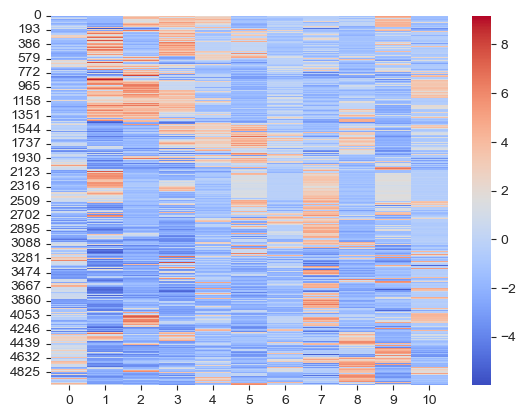

In [171]:
x_atr_bind_wk = np.array(df_1ADQ_pos_wk.iloc[row_order_bind]['attributions'].to_list())
sns.heatmap(x_atr_bind_wk, cmap='coolwarm')

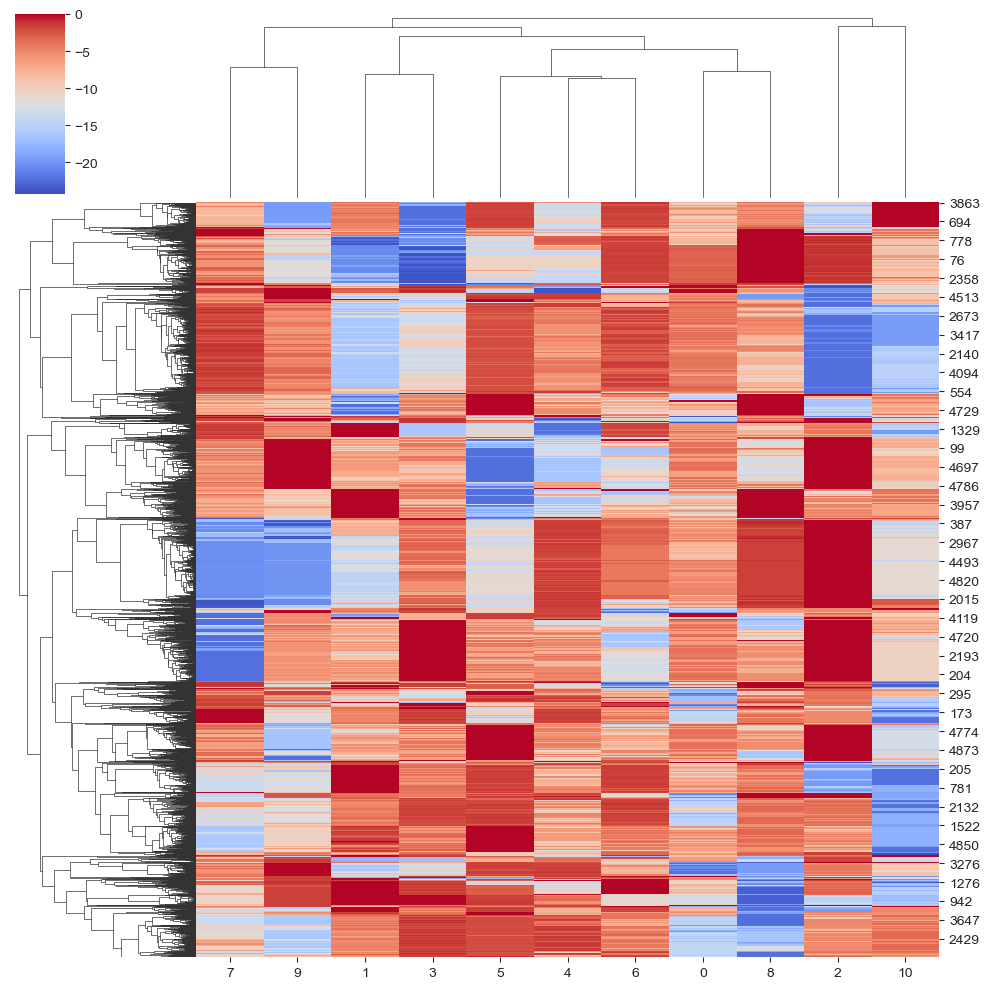

In [172]:
clust_nd_eng = sns.clustermap(x_nb, cmap='coolwarm')
row_order_wk = clust_nd_eng.dendrogram_row.reordered_ind

<AxesSubplot:>

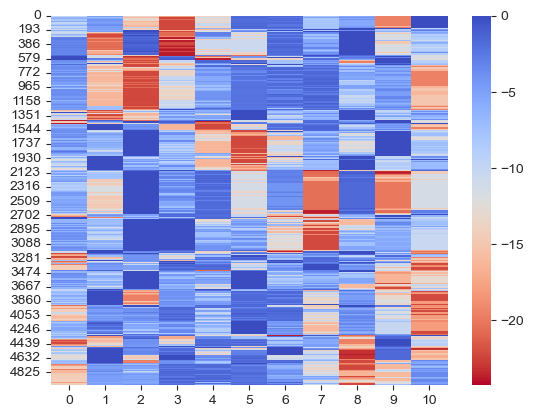

In [176]:
x_eng_wk = np.array(df_1ADQ_wk_neg.iloc[row_order_wk]['energies'].to_list())
sns.heatmap(x_eng_wk, cmap='coolwarm_r')

<AxesSubplot:>

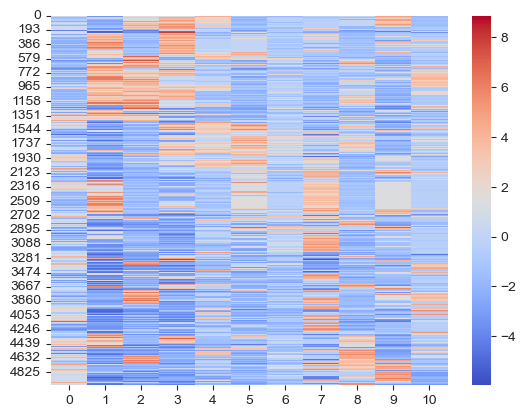

In [175]:
x_atr_wk = np.array(df_1ADQ_wk_neg.iloc[row_order_wk]['attributions'].to_list())
sns.heatmap(x_atr_wk, cmap='coolwarm')

<AxesSubplot:>

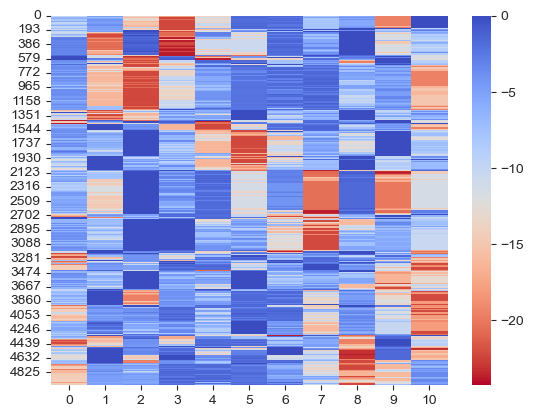

In [154]:
x_eng_wk = np.array(df_1ADQ_wk_neg.iloc[row_order_wk]['energies'].to_list())
sns.heatmap(x_eng_wk, cmap='coolwarm_r')

In [ ]:
#let's look to energy distributions across positions 

In [ ]:
df_1ADQ_pos_wk

In [182]:
x_eng_wk

array([[ -8.08,  -4.03,  -9.39, ...,  -4.16, -19.61,   0.  ],
       [ -6.92,  -4.34, -13.12, ...,  -4.91, -16.28,   0.  ],
       [ -8.08,  -7.04, -16.33, ...,  -3.4 , -19.61,   0.  ],
       ...,
       [-14.32,  -4.91,  -4.01, ..., -22.33, -15.94,  -4.91],
       [-14.32,  -4.91,  -5.21, ..., -16.42, -15.94,  -3.5 ],
       [-14.32,  -4.91,  -5.21, ..., -13.11, -13.12,  -3.5 ]])

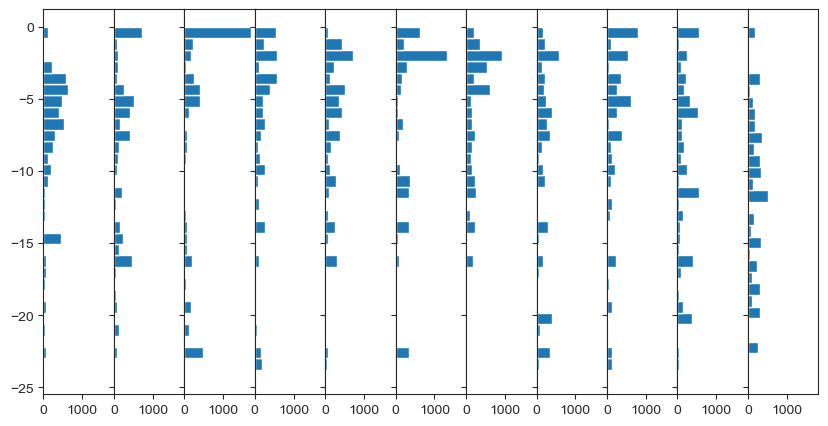

In [196]:
fig, axs = plt.subplots(1, 11, sharey=True, sharex=True, gridspec_kw={'wspace': 0}, figsize=(10,5))
for i in range(11):
    axs[i].hist(x_eng_wk[:, i], orientation='horizontal', bins=30)
    


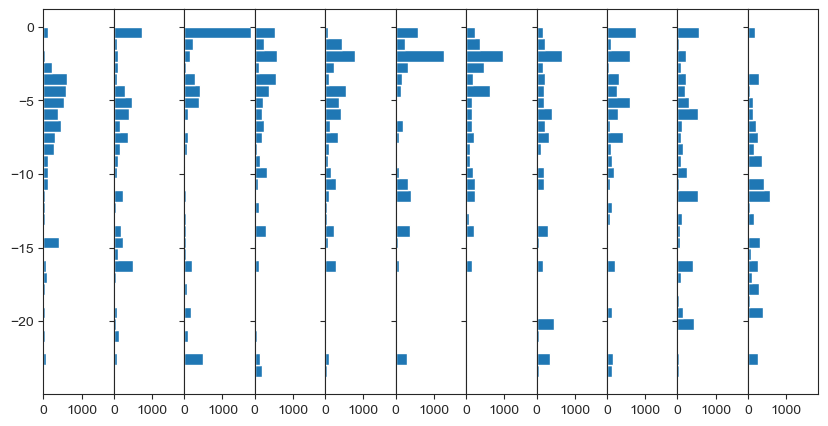

In [197]:
fig, axs = plt.subplots(1, 11, sharey=True, sharex=True, gridspec_kw={'wspace': 0}, figsize=(10,5))
for i in range(11):
    axs[i].hist(x_bind[:, i], orientation='horizontal', bins=30)

In [264]:
cmap = { 'vs 9' : '#FF5733',
         'vs Non-binder':'#00A6ED',
         'vs Weak':'#FFC300',
         'vs 1': '#8B5F4D',
         'binder':'#FF5733'}

In [296]:
def plot_position(ag, y):
    task_type = datasets.ClassificationTaskType.HIGH_VS_LOOSER
    split_id = 4
    seed_id = 0
    task_wk = datasets.ClassificationTask(
                        task_type=task_type,
                        ag_pos=ag,
                        ag_neg="auto",
                        seed_id=seed_id,
                        split_id=split_id,
                    )
    task_type = datasets.ClassificationTaskType.HIGH_VS_95LOW
    task_nb = datasets.ClassificationTask(
                        task_type=task_type,
                        ag_pos=ag,
                        ag_neg="auto",
                        seed_id=seed_id,
                        split_id=split_id,
                    )

    _, df_wk = load_energy_contributions_from_task(task_wk, load_slide_df = True, attributions_toload="reveal_cancel", attributor_name = "DeepLIFT_Reveal_cancel")
    _, df_nb = load_energy_contributions_from_task(task_nb, load_slide_df = True, attributions_toload="reveal_cancel", attributor_name = "DeepLIFT_Reveal_cancel")
    df_wk['class'] = df_wk['class'].apply(lambda x: 'vs Weakx' if x=='negative' else 'binder')
    df_nb['class'] = df_nb['class'].apply(lambda x: 'vs Non-binder' if x=='negative' else 'binder')
    df = pd.concat([df_wk, df_nb[df_nb['class']=='vs Non-binder']])

    df_ag_eng_position = df[['slide', 'class']].join(pd.DataFrame(df[y].to_list(), columns=np.arange(1,12)))
    df_ag_melt = df_ag_eng_position.melt(id_vars=['slide', 'class'], var_name='position', value_name=y)
    
    sns.pointplot(
        df_ag_melt,
        y=y,
        x="position",
        errorbar=("pi", 95),
        hue="class",
        palette = cmap,
        # Spread out the points a bit in horizontal
        dodge=0.3,
        capsize=0.1,
        estimator='median',
        linestyles='none'
    )
    plt.legend('')
    plt.title(task_nb.ag_pos)
    plt.show()


/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


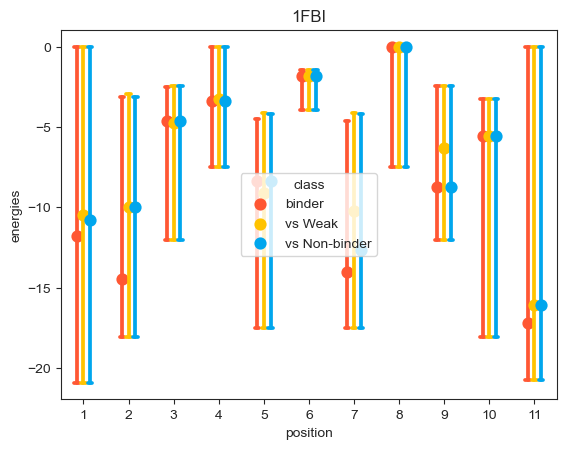

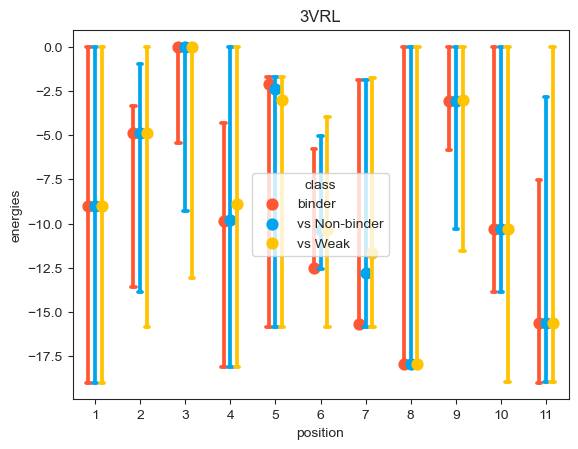

/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


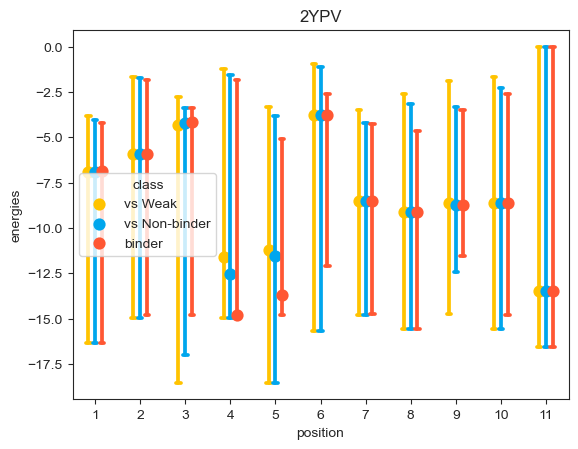

/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


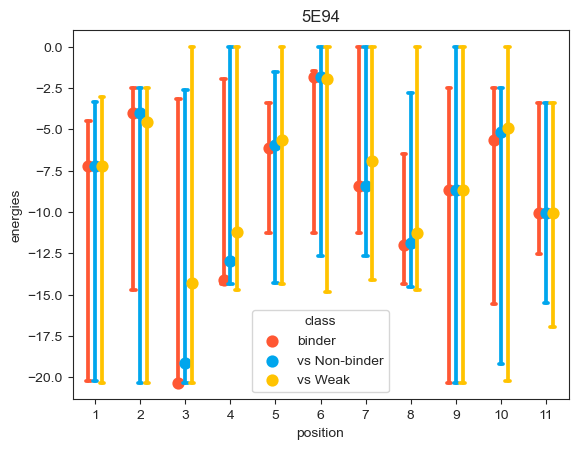

/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


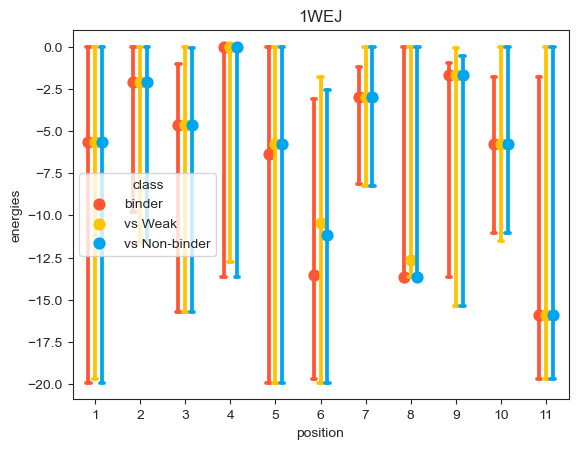

/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


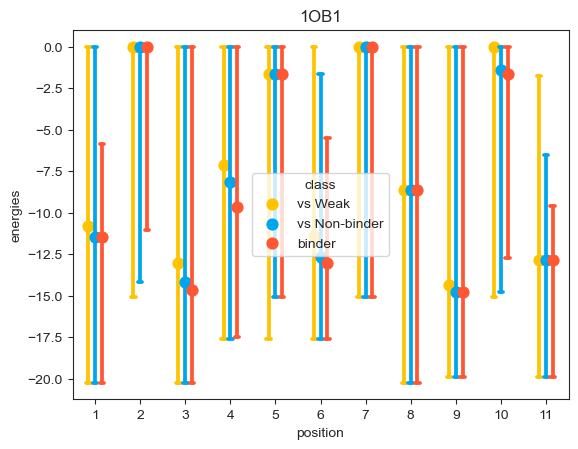

/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


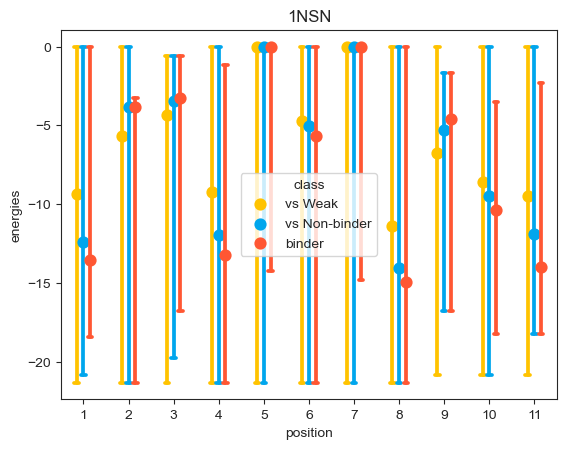

/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


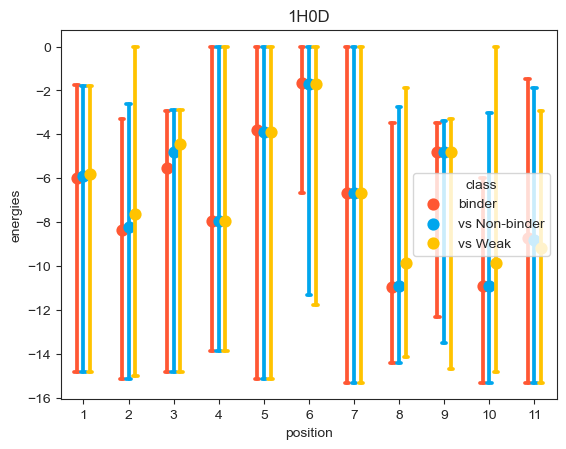

/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


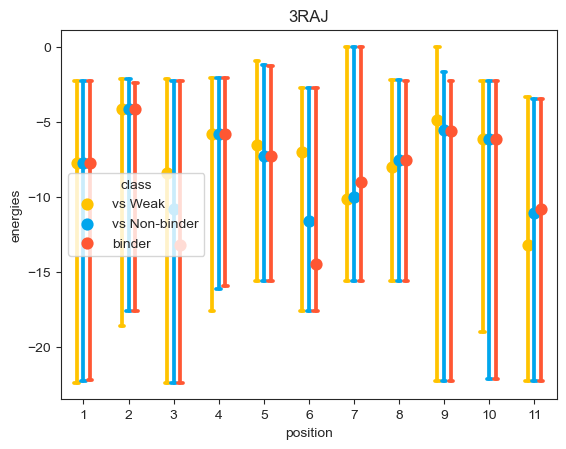

/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


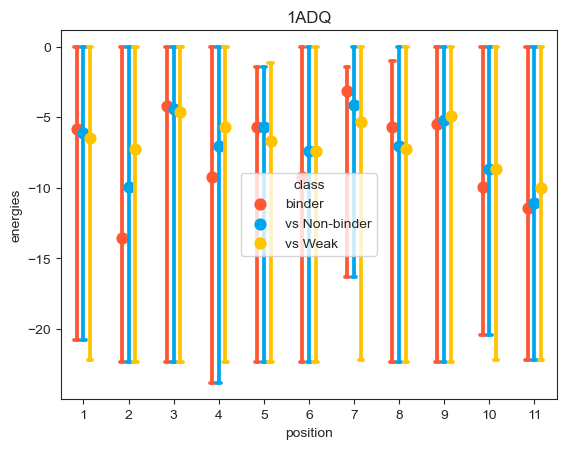

In [298]:
#fig, axs = plt.subplots(2,5,)
for i, ag in enumerate(ag_order):
    #ax = axs[i//5, i%5]
    plot_position(ag, "energies")

/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


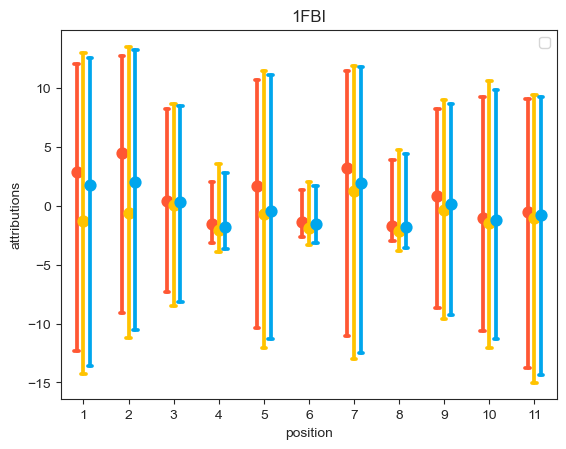

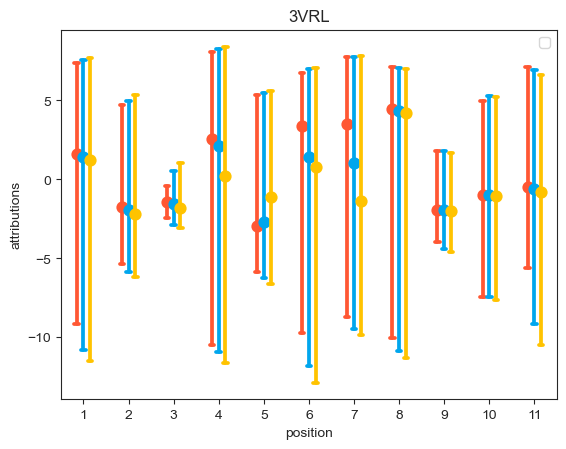

/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


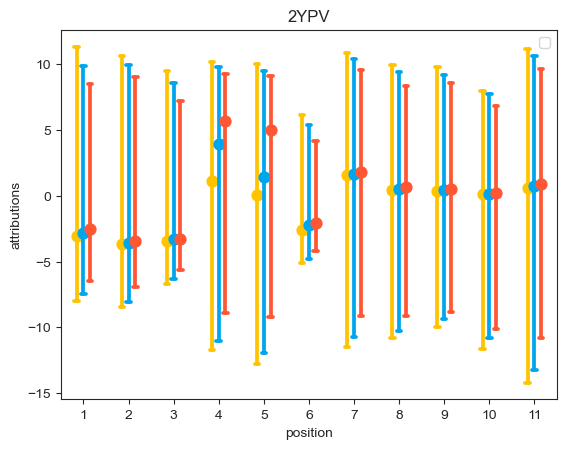

/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


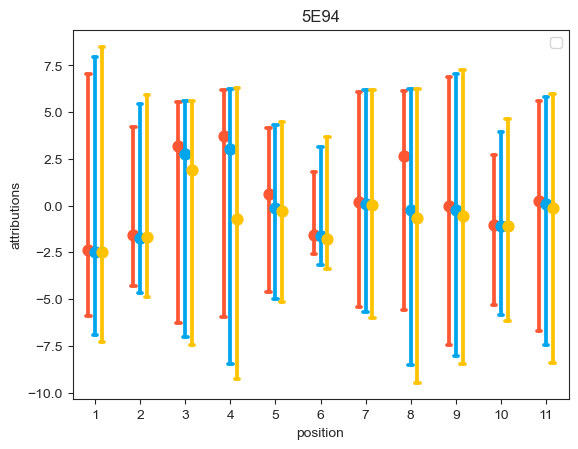

/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


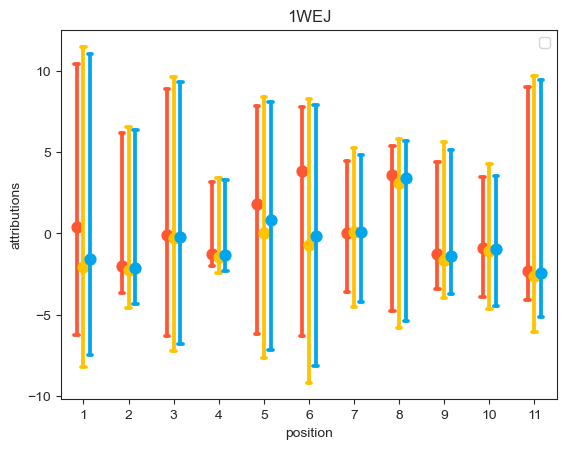

/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


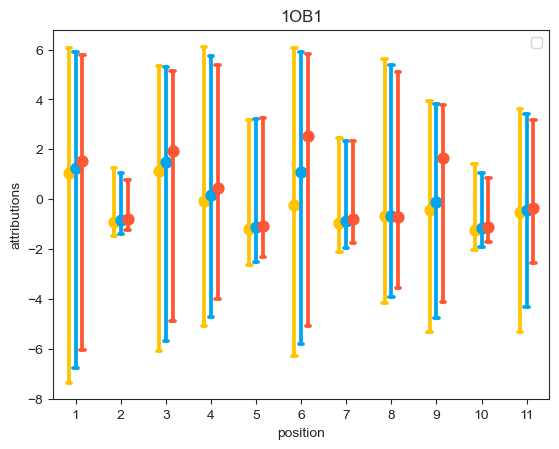

/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


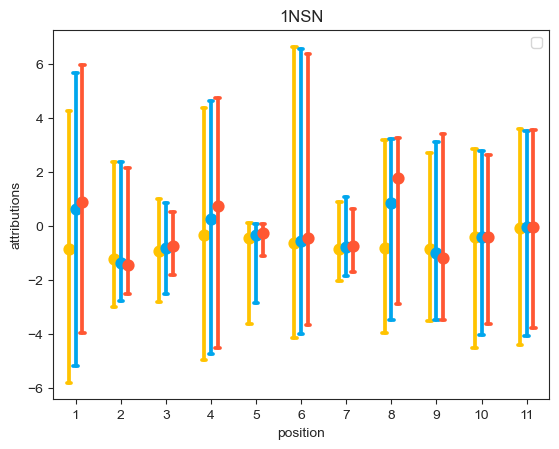

/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


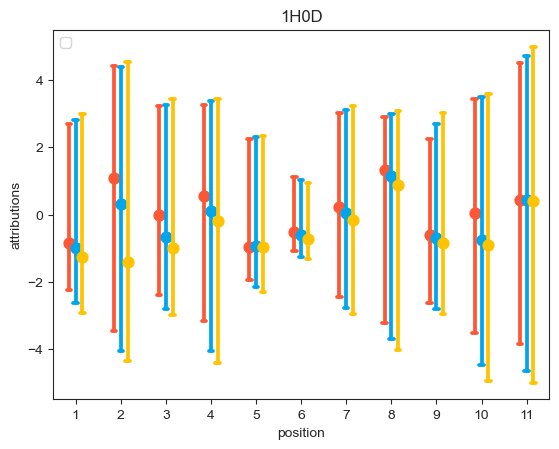

/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


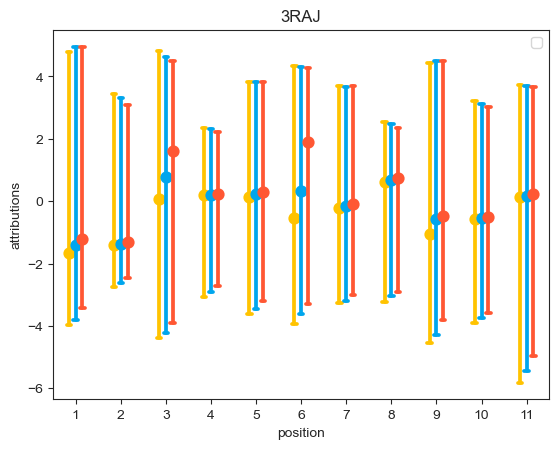

/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


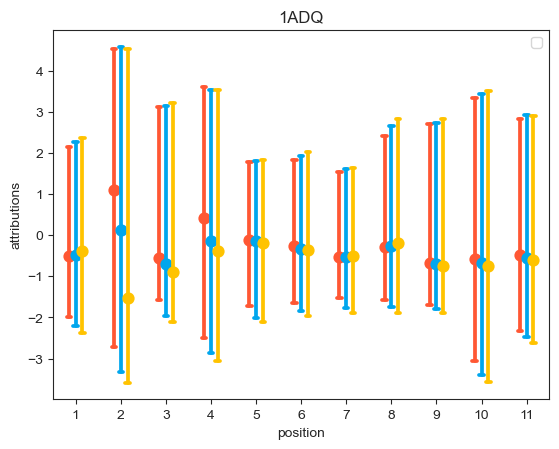

In [295]:
for i, ag in enumerate(ag_order):
    #ax = axs[i//5, i%5]
    plot_position(ag, "attributions")

In [302]:
#sanity check, lets sum up all energies

def plot_energy(ag):
    task_type = datasets.ClassificationTaskType.HIGH_VS_LOOSER
    split_id = 4
    seed_id = 0
    task_wk = datasets.ClassificationTask(
                        task_type=task_type,
                        ag_pos=ag,
                        ag_neg="auto",
                        seed_id=seed_id,
                        split_id=split_id,
                    )
    task_type = datasets.ClassificationTaskType.HIGH_VS_95LOW
    task_nb = datasets.ClassificationTask(
                        task_type=task_type,
                        ag_pos=ag,
                        ag_neg="auto",
                        seed_id=seed_id,
                        split_id=split_id,
                    )

    _, df_wk = load_energy_contributions_from_task(task_wk, load_slide_df = True, attributions_toload="reveal_cancel", attributor_name = "DeepLIFT_Reveal_cancel")
    _, df_nb = load_energy_contributions_from_task(task_nb, load_slide_df = True, attributions_toload="reveal_cancel", attributor_name = "DeepLIFT_Reveal_cancel")
    df_wk['class'] = df_wk['class'].apply(lambda x: 'vs Weak' if x=='negative' else 'binder')
    df_nb['class'] = df_nb['class'].apply(lambda x: 'vs Non-binder' if x=='negative' else 'binder')
    df = pd.concat([df_wk, df_nb[df_nb['class']=='vs Non-binder']])
    df['energies'] = df['energies'].apply(sum)
    sns.histplot(data = df,x='energies', hue='class')



/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


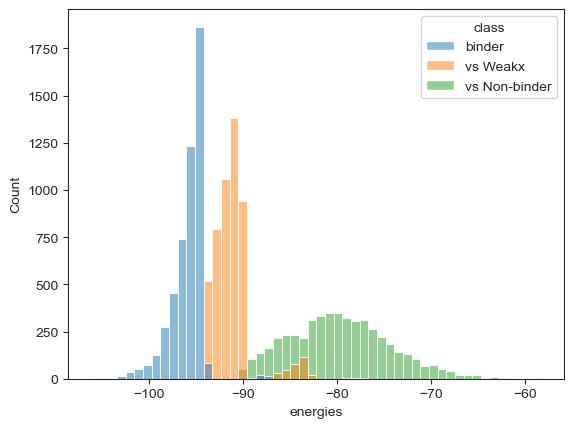

In [303]:
plot_energy('1ADQ')

In [ ]:
def info_cont(counts, n):
    frec = counts/n
    inf_cont = np.sum(frec*np.log(frec/0.05))
    return inf_cont

In [384]:
def plot_position_entr(ag):
    task_type = datasets.ClassificationTaskType.HIGH_VS_LOOSER
    split_id = 4
    seed_id = 0
    task_wk = datasets.ClassificationTask(
                        task_type=task_type,
                        ag_pos=ag,
                        ag_neg="auto",
                        seed_id=seed_id,
                        split_id=split_id,
                    )
    task_type = datasets.ClassificationTaskType.HIGH_VS_95LOW
    task_nb = datasets.ClassificationTask(
                        task_type=task_type,
                        ag_pos=ag,
                        ag_neg="auto",
                        seed_id=seed_id,
                        split_id=split_id,
                    )

    _, df_wk = load_energy_contributions_from_task(task_wk, load_slide_df = True, attributions_toload="reveal_cancel", attributor_name = "DeepLIFT_Reveal_cancel")
    _, df_nb = load_energy_contributions_from_task(task_nb, load_slide_df = True, attributions_toload="reveal_cancel", attributor_name = "DeepLIFT_Reveal_cancel")
    df_wk['class'] = df_wk['class'].apply(lambda x: 'vs Weak' if x=='negative' else 'binder')
    df_nb['class'] = df_nb['class'].apply(lambda x: 'vs Non-binder' if x=='negative' else 'binder')
    df = pd.concat([df_wk, df_nb[df_nb['class']=='vs Non-binder']])
    df = df.join(pd.DataFrame(df.slide.apply(list).tolist(), columns=np.arange(1, 12)))
    position_inf = []
    #I have to do it separetely for different classes
    for bind_cl in ['binder', 'vs Weak', 'vs Non-binder']:
        for i in range(1,12):
            df_ = df[df['class'] == bind_cl]
            n = df_.shape[0]
            counts = np.array(df_[i].value_counts().values)
            var = info_cont(counts, n)
            position_inf.append([bind_cl, i, var])
    df_inf_cont = pd.DataFrame(position_inf, columns=['task', 'position', 'inf_cont'])  
    sns.barplot(df_inf_cont, x='position', y='inf_cont', hue='task', palette=cmap) 
    plt.title(ag)
    plt.show()

/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


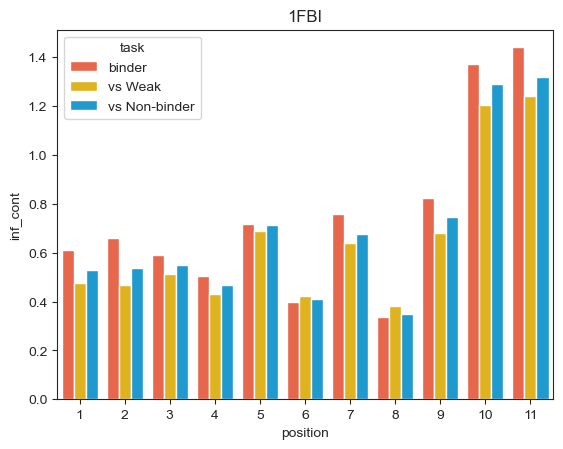

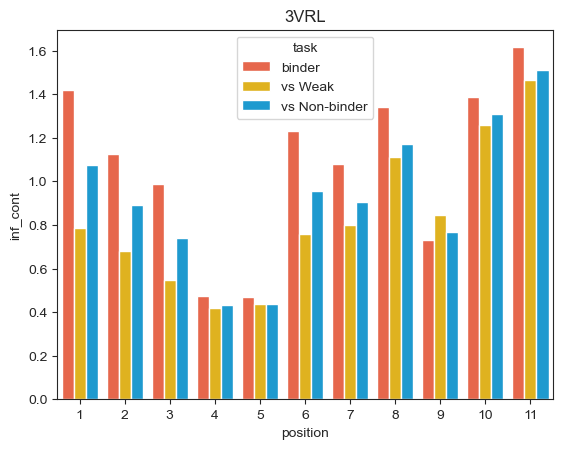

/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


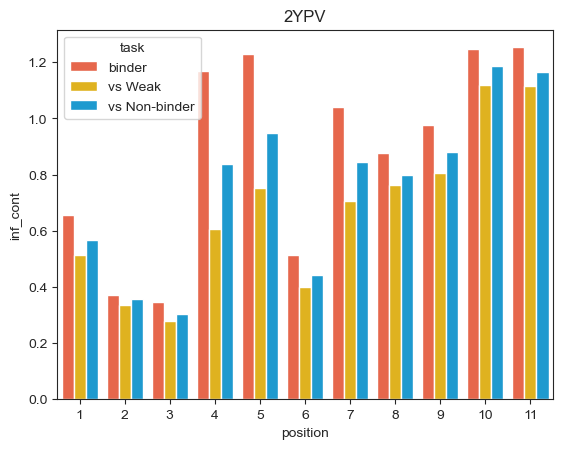

/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


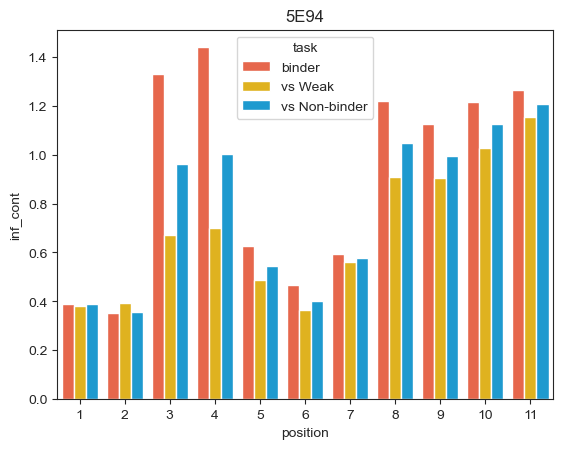

/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


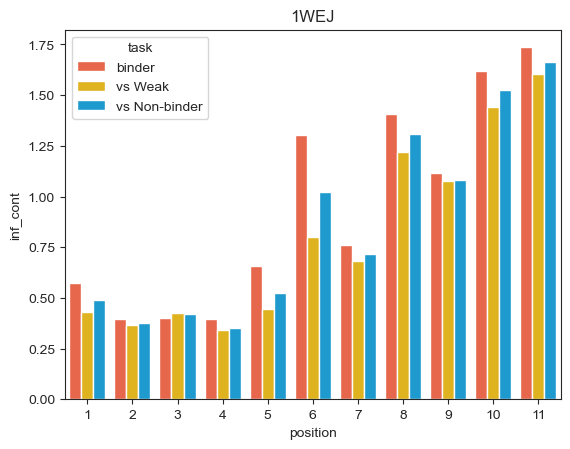

/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


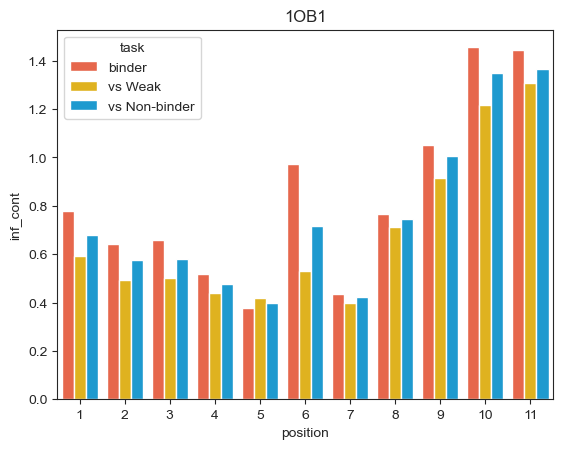

/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


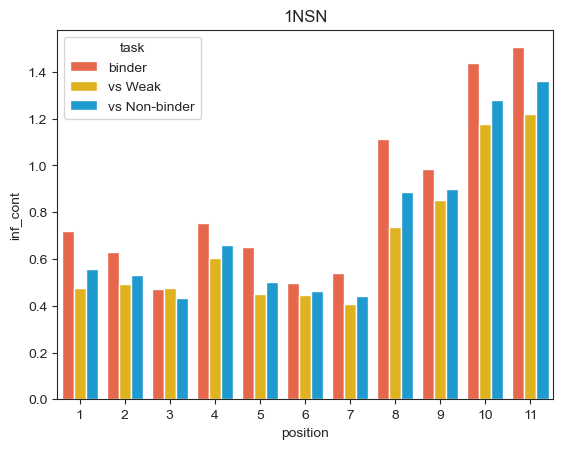

/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


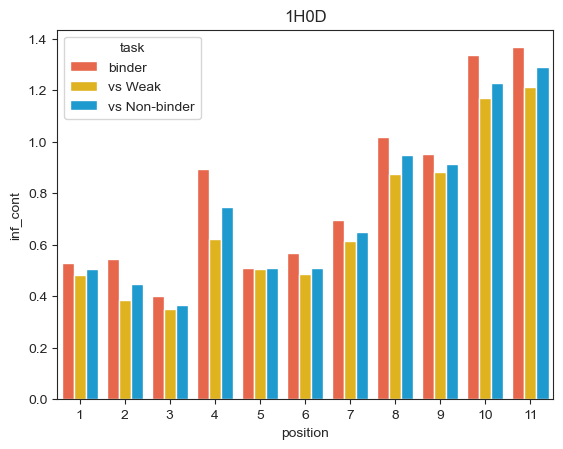

/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


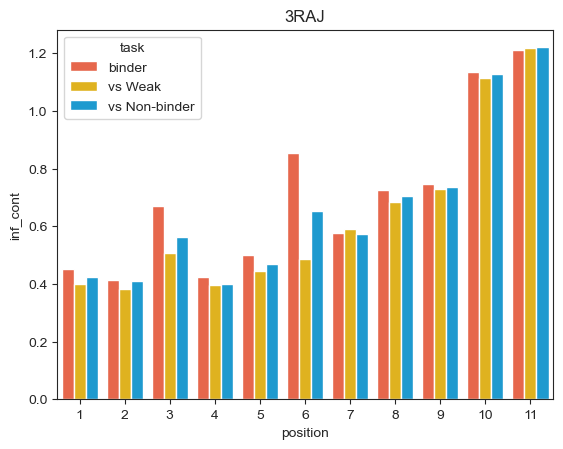

/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


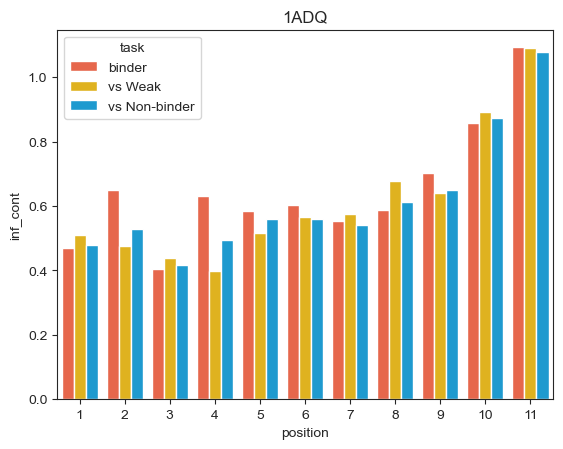

In [385]:
for ag in ag_order:
    plot_position_entr(ag)

/var/folders/ww/bptfq9n12_jbyy78qcjp7s4c0000gn/T/ipykernel_86493/3788795895.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(map(lambda x: visualisations.PlotParams.map_task_type_to_clean[x], task_order))


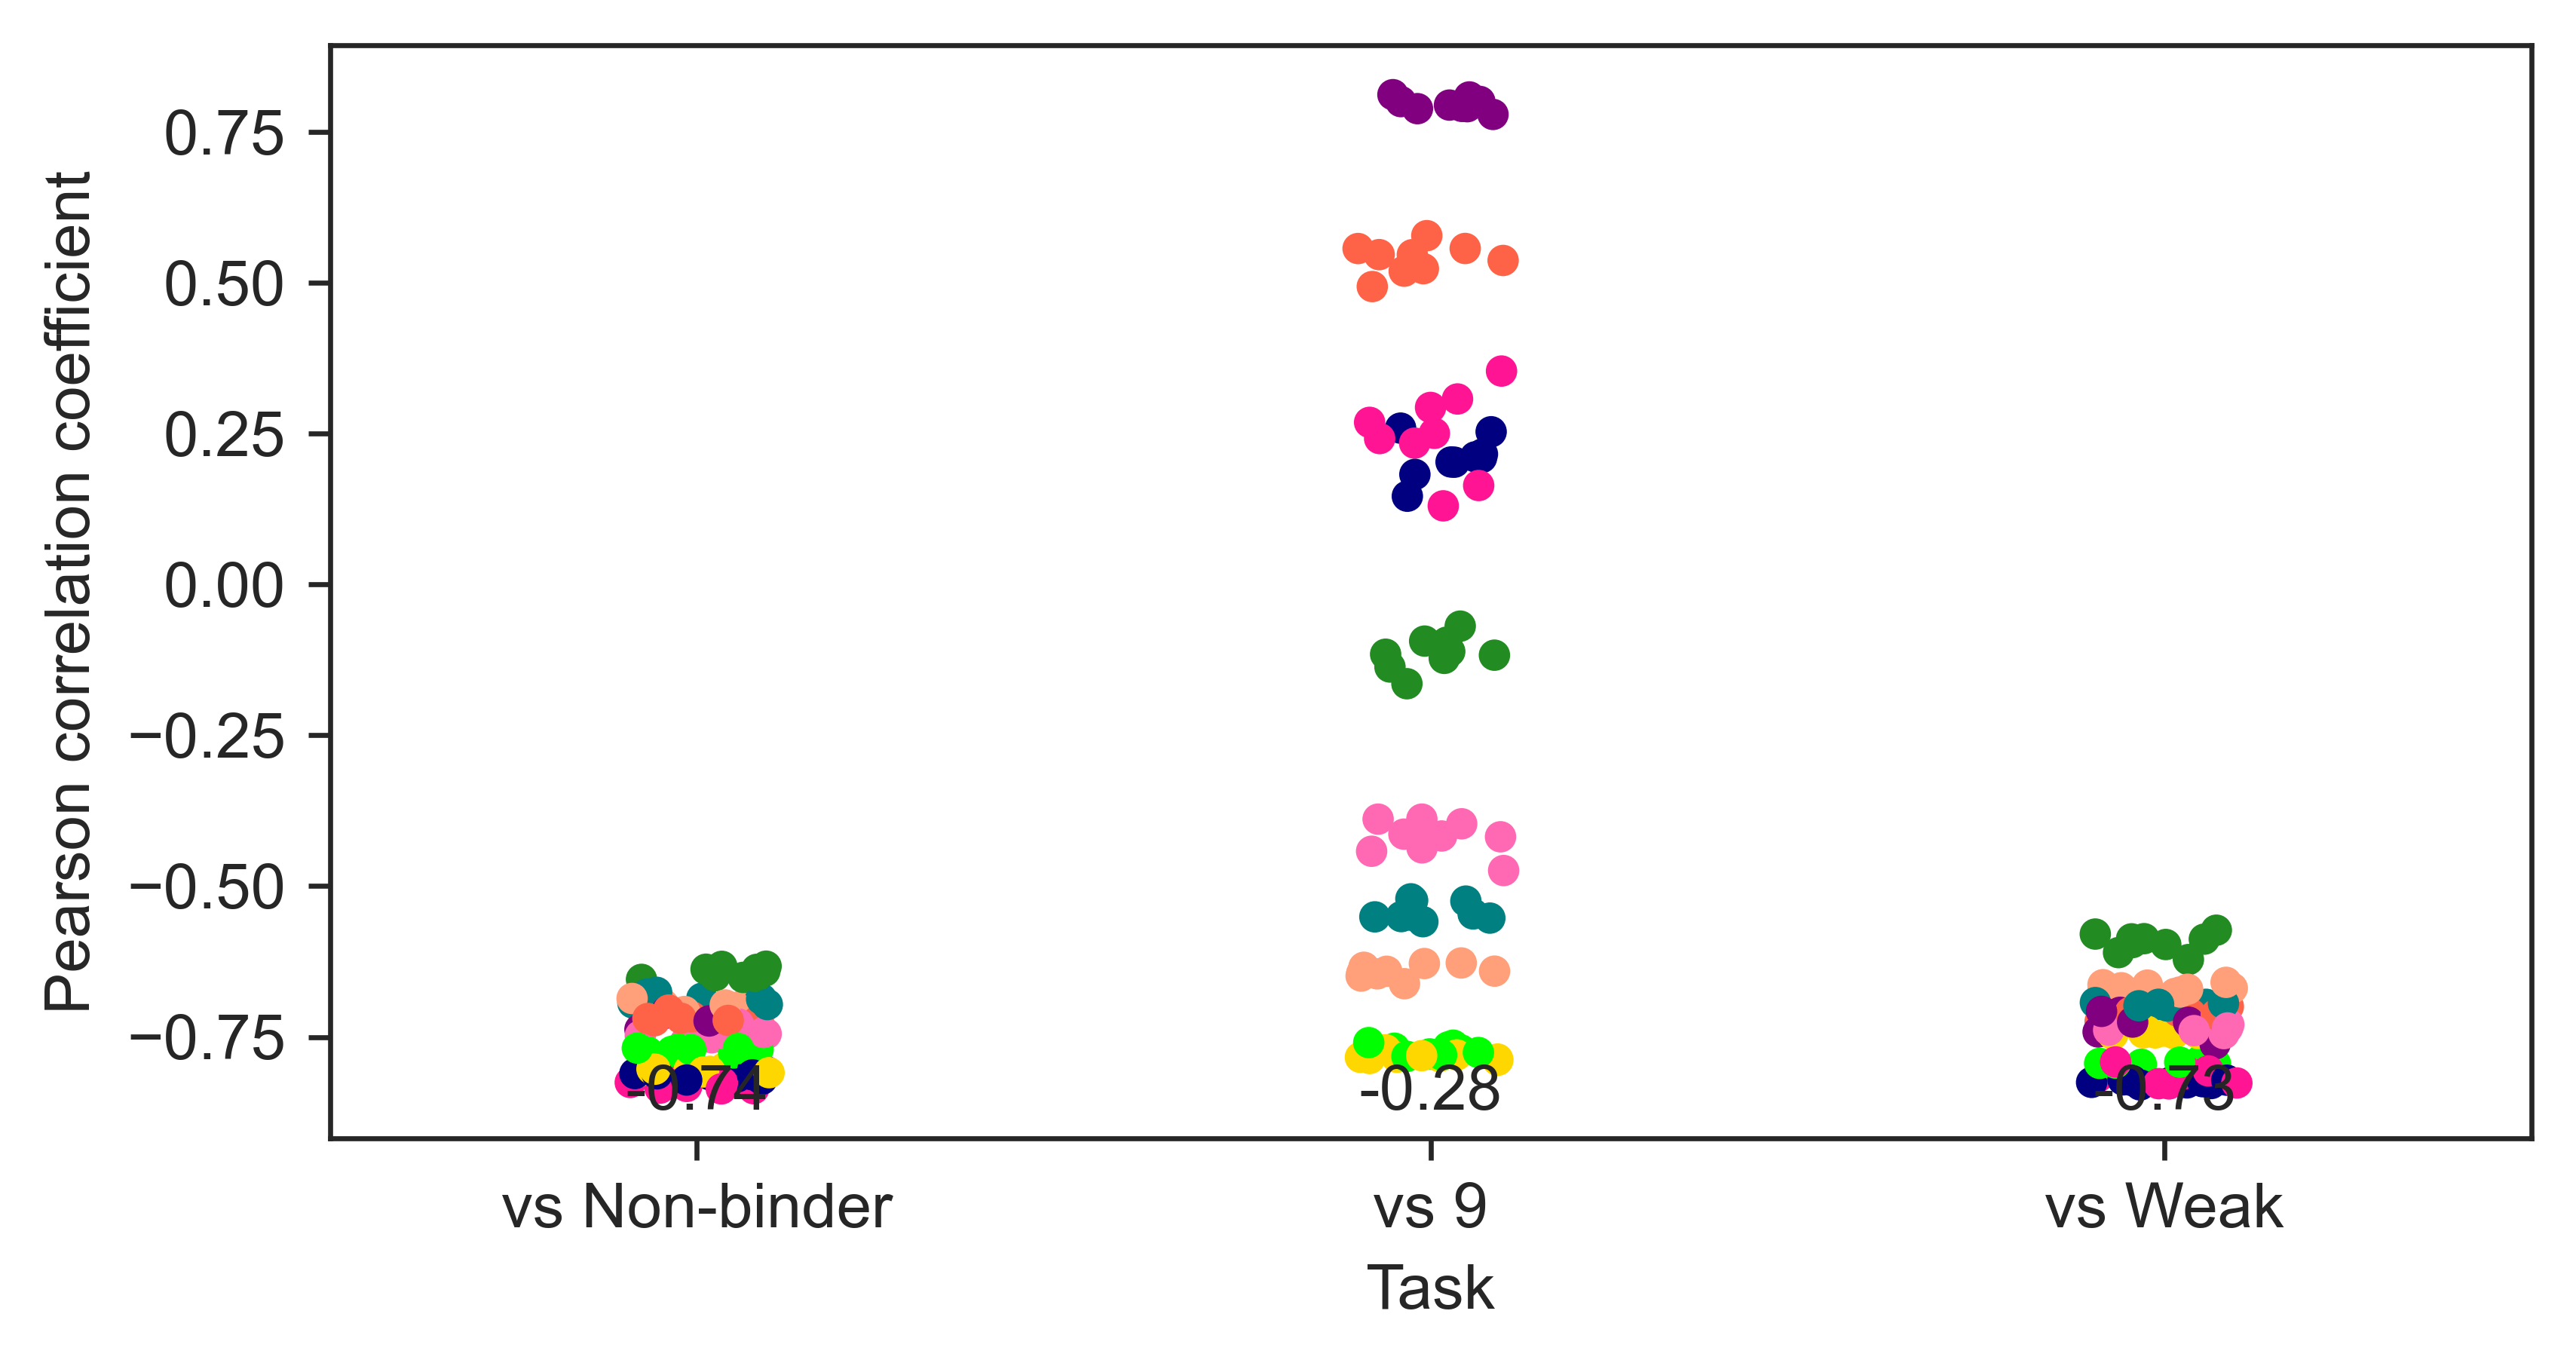

In [287]:
fig, ax = plt.subplots(figsize=(2*3.14, 3.14), dpi=600)
sns.set_style("white")
sns.set_style('ticks')

task_order = ["high_vs_95low", "1v9", "high_vs_looser"]
sns.stripplot(
    data=df_attr_revcan, 
    x="task_type", 
    y="mean_pos_total", 
    order=task_order,
    hue="ag_pos",
    ax=ax,
    palette=cmap_ag,
)

ax.legend_.remove()

# Relabel xticks
ax.set_xticklabels(map(lambda x: visualisations.PlotParams.map_task_type_to_clean[x], task_order))

# Add median r_pos per task
r_median_df = df_attr_revcan.groupby(["task_type"]).agg({"mean_pos_total": "median"})
for i, row in r_median_df.iterrows():
    ax.text(
        i,
        -0.87,
        f"{row['mean_pos_total']:.2f}",
        # Center center
        horizontalalignment='center',
    )

# ax.set_title("Mean{Correlation(Energycontribution, Attribution)} for positive class")
ax.set_ylabel("Pearson correlation coefficient")
ax.set_xlabel("Task")
fig.savefig("figures/section2/fig2_r_attr_peraaeng_reveal_cancel.svg")

/var/folders/ww/bptfq9n12_jbyy78qcjp7s4c0000gn/T/ipykernel_1973/426772761.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(map(lambda x: visualisations.PlotParams.map_task_type_to_clean[x], task_order))


Text(0.5, 0, 'Task')

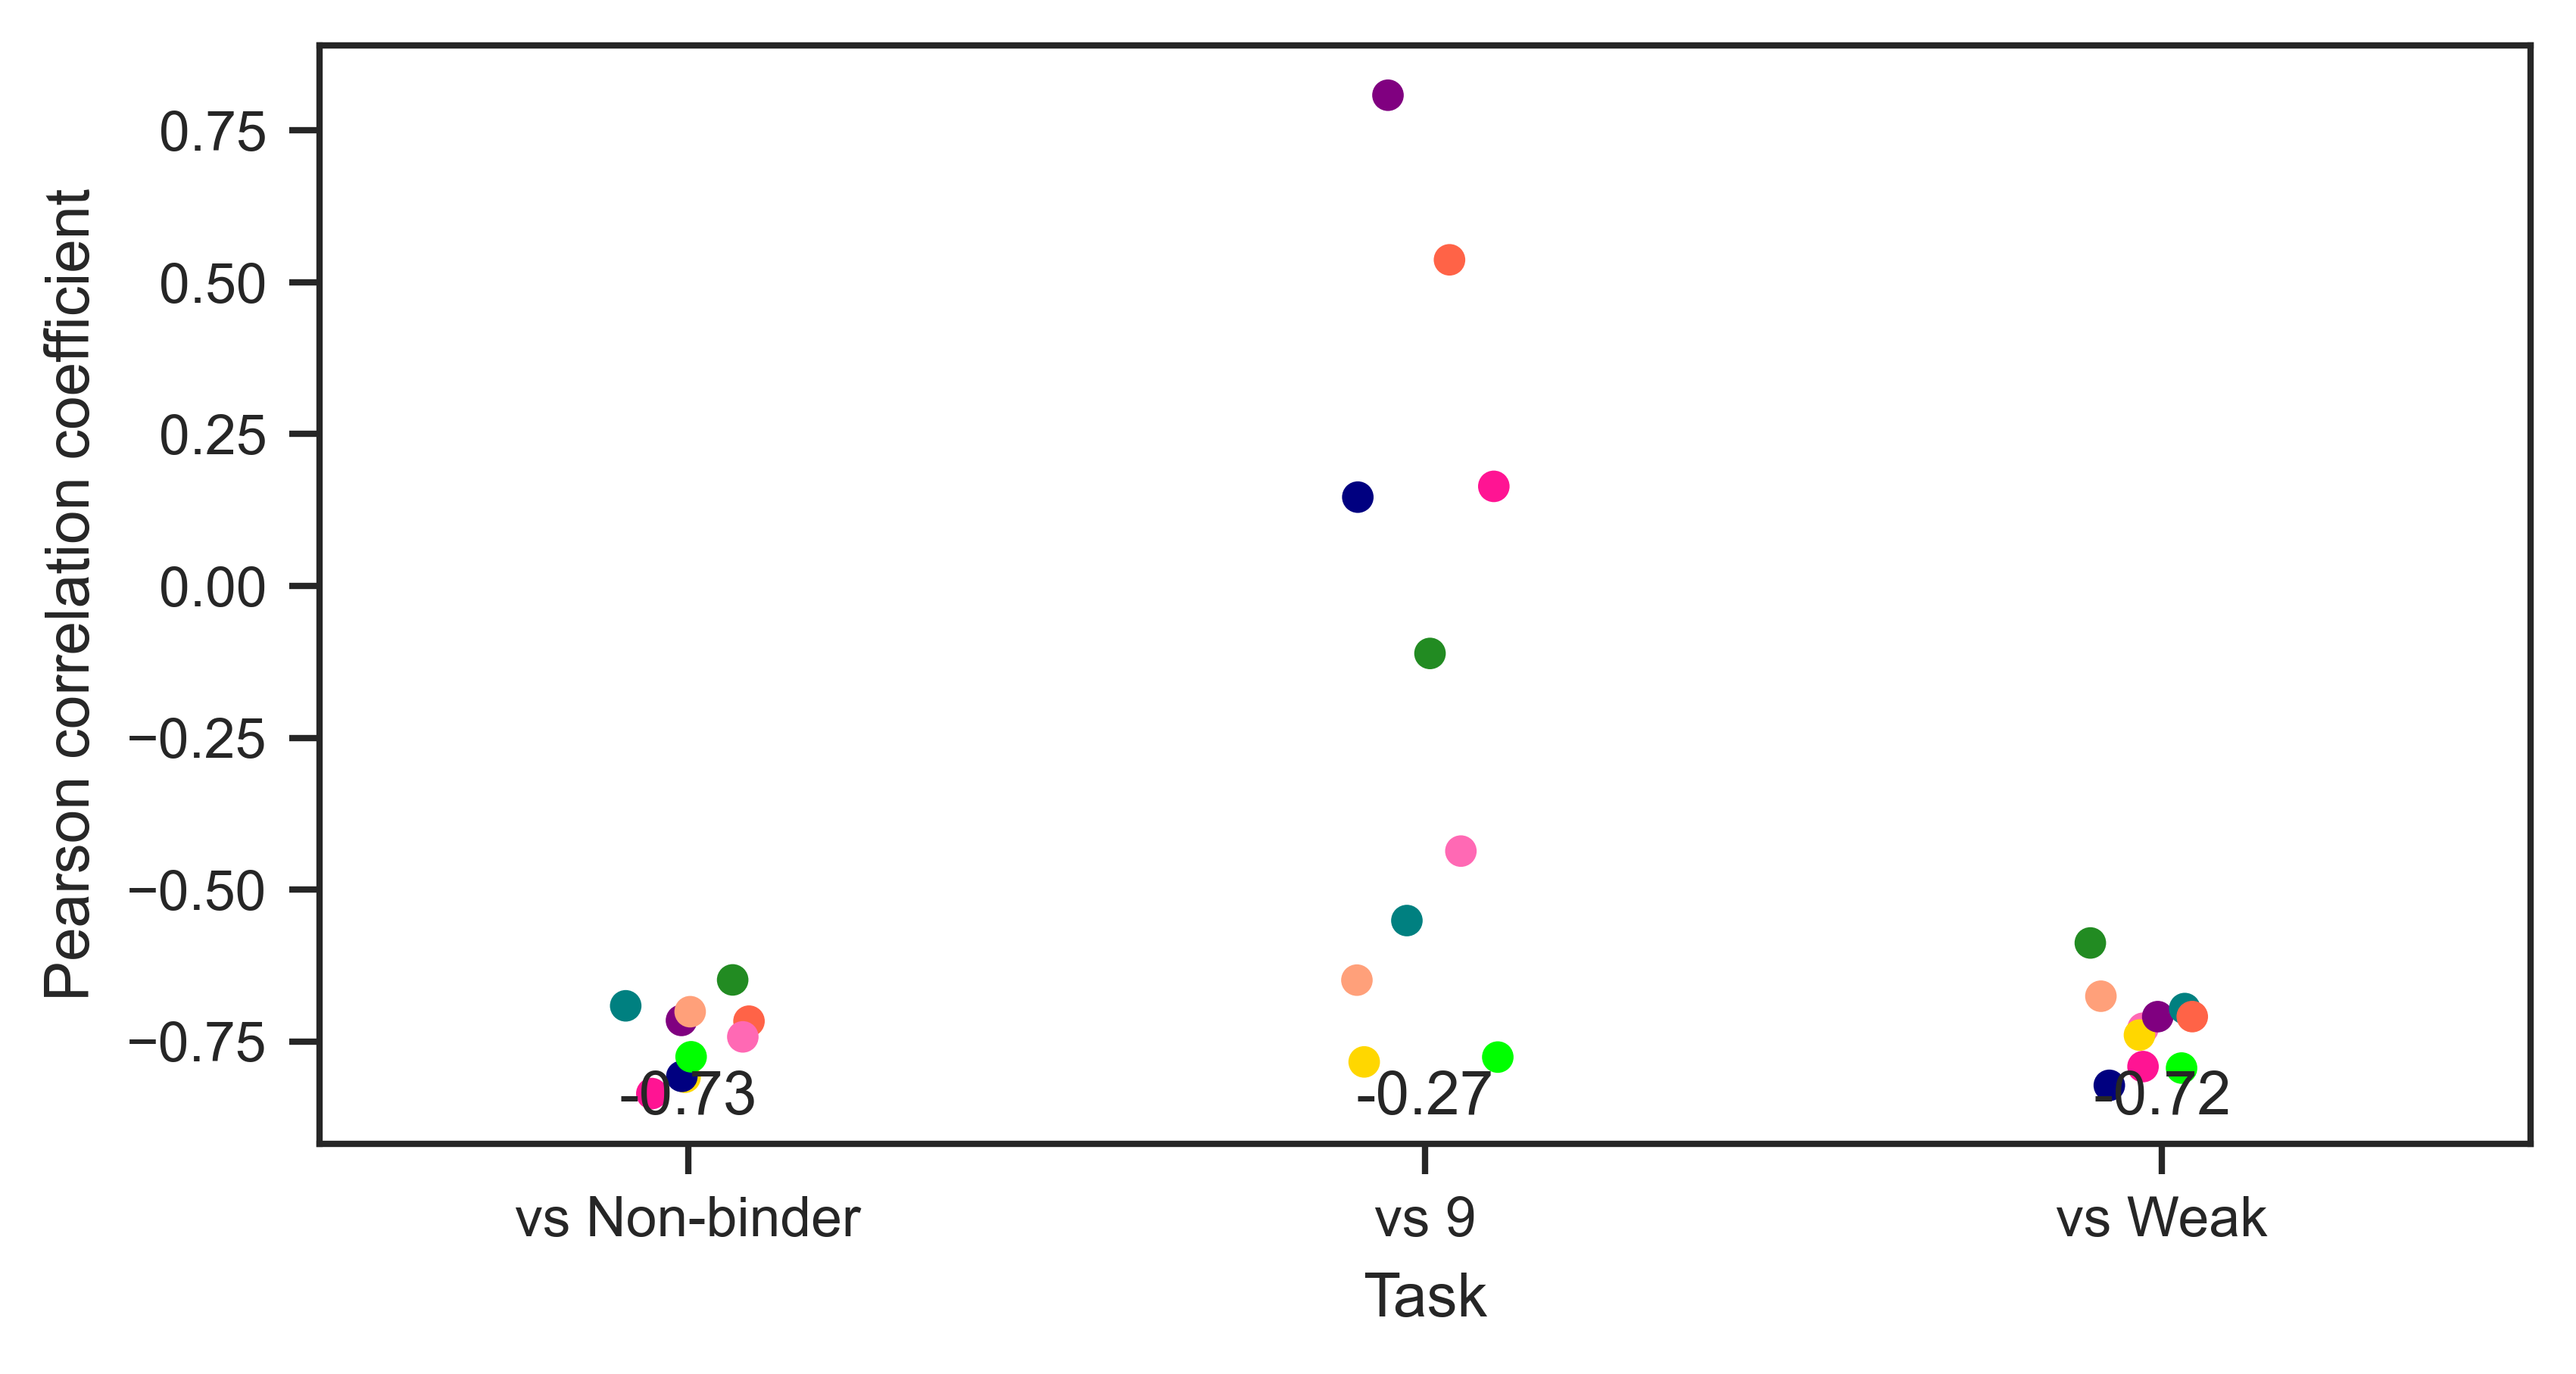

In [345]:
fig, ax = plt.subplots(figsize=(2*3.14, 3.14), dpi=600)
sns.set_style("white")
sns.set_style('ticks')

task_order = ["high_vs_95low", "1v9", "high_vs_looser"]
sns.stripplot(
    data=df_attr_revcan, 
    x="task_type", 
    y="mean_pos_total", 
    order=task_order,
    hue="ag_pos",
    ax=ax,
    palette=cmap_ag,
)

ax.legend_.remove()

# Relabel xticks
ax.set_xticklabels(map(lambda x: visualisations.PlotParams.map_task_type_to_clean[x], task_order))

# Add median r_pos per task
r_median_df = df_attr_revcan.groupby(["task_type"]).agg({"mean_pos_total": "median"})
for i, row in r_median_df.iterrows():
    ax.text(
        i,
        -0.87,
        f"{row['mean_pos_total']:.2f}",
        # Center center
        horizontalalignment='center',
    )

# ax.set_title("Mean{Correlation(Energycontribution, Attribution)} for positive class")
ax.set_ylabel("Pearson correlation coefficient")
ax.set_xlabel("Task")
#fig.savefig("figures/section2/fig2_r_attr_peraaeng.svg")

#Fig2 plot with mutants

In [42]:
def  compare_slides(slide1, slide2):
    for i in range(11):
        if slide1[i] != slide2[i]:
            return i

NameError: name 'df_5e94' is not defined

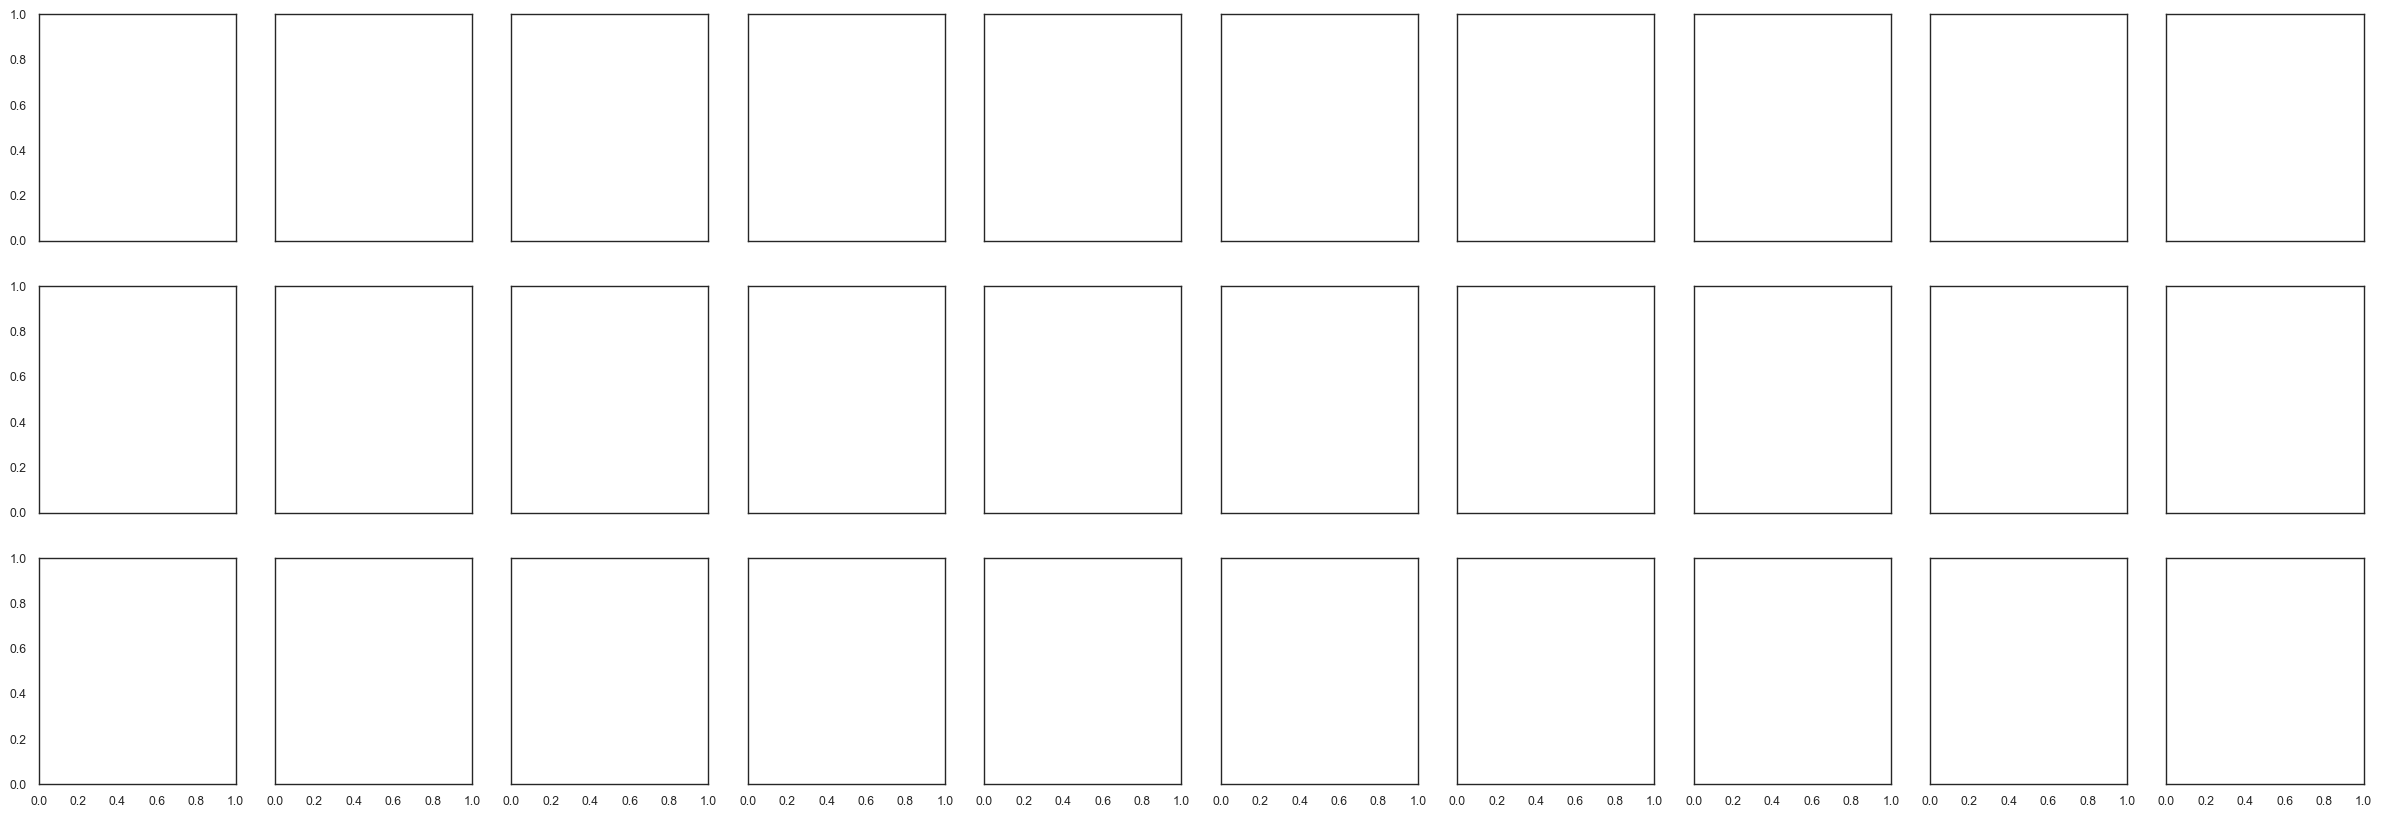

In [43]:
fig, ax = plt.subplots(3,10, figsize=(30,10), sharex=True, sharey=True)

for i,ag in enumerate(config.ANTIGENS):
    for j, task in enumerate(["ONE_VS_NINE", "HIGH_VS_95LOW", "HIGH_VS_LOOSER"]):
        with open(f'../data/mutant_attributions_v2.0-2_mutants/{ag}_{task}_mut_igs_attributions.json', 'r') as f:
            records_mut = json.load(f)
        df_mut_attr = pd.DataFrame.from_records(records_mut)
        df_mut_attr.rename(columns={'slide':'Slide'}, inplace=True)
        mut_eng_path = glob.glob(f'../data/mutant_energy_contributions/{ag}_{task}_mut_igs_energy_contributions_for_*.tsv')[0]
        df_mut_eng = pd.read_csv(mut_eng_path, sep='\t', header=1)
        df = pd.DataFrame.merge(df_mut_attr, df_mut_eng[['Slide', 'Energy', 'contribPerAAparaBind', 'contribPerAAparaFold']], how = 'outer', on = 'Slide')
        df["energies"] = df.apply(lambda x: np.array(utils.extract_contributions_from_string(x["contribPerAAparaBind"])[1]), axis=1)
        df["energies_fold"] = df.apply(lambda x: np.array(utils.extract_contributions_from_string(x["contribPerAAparaFold"])[1]), axis=1)
        df['energies_total'] = df_5e94["energies_fold"] + df_5e94["energies"]
        org_slides = df['original_slide'].unique()

        #dirty but fast to write
        if task == "ONE_VS_NINE":
            task_type = datasets.ClassificationTaskType.ONE_VS_NINE 
            color= '#FF5733'
        elif task == "HIGH_VS_95LOW":
            task_type = datasets.ClassificationTaskType.HIGH_VS_95LOW
            color = '#00A6ED'
        else:
            task_type = datasets.ClassificationTaskType.HIGH_VS_LOOSER
            color = '#FFC300'
        
        ag_1 = ag
        split_id = 4
        seed_id = 0
        task_ = datasets.ClassificationTask(
                            task_type=task_type,
                            ag_pos=ag_1,
                            ag_neg="auto",
                            seed_id=seed_id,
                            split_id=split_id,
                        )
        df_org_eng = get_miniabsolut_dataframes(task_, load_energy_contributions=True)

        
        df_org_eng = df_org_eng[df_org_eng['Slide'].isin(org_slides)].copy()
        
        df_org_eng["energies_org"] = df_org_eng.apply(lambda x: np.array(utils.extract_contributions_from_string(x["contribPerAAparaBind"])[1]), axis=1)
        df_org_eng["energies_fold_org"] = df_org_eng.apply(lambda x: np.array(utils.extract_contributions_from_string(x["contribPerAAparaFold"])[1]), axis=1)
        df_org_eng['energies_total_org'] = df_org_eng["energies_fold_org"] + df_org_eng["energies_org"]

        df_org_eng.rename(columns={'Slide':'original_slide'}, inplace=True)
        df_org_eng = df_org_eng[['original_slide', 'energies_org', 'energies_fold_org', 'energies_total_org']]
        df_mut_org = pd.DataFrame.merge(df,df_org_eng, how='outer', on='original_slide').dropna(axis=0, subset=['original_slide', 'energies_total_org', 'energies_total'])
                        
        df_mut_org['mut_pos'] = df_mut_org.apply(lambda x: compare_slides(x['Slide'], x['original_slide']), axis=1)
        df_mut_org['delta pos attr'] = df_mut_org.apply(lambda row: row['original_attributions'][0][row['mut_pos']] - row['attributions'][0][row['mut_pos']], axis=1)
        df_mut_org['delta pos eng'] = df_mut_org.apply(lambda row: row['energies_total_org'][row['mut_pos']] - row['energies_total'][row['mut_pos']], axis=1)
        
        sns.scatterplot(x='delta pos eng', y='delta pos attr', data=df_mut_org,  ax=ax[j, i], color = color)


NameError: name 'df_5e94' is not defined

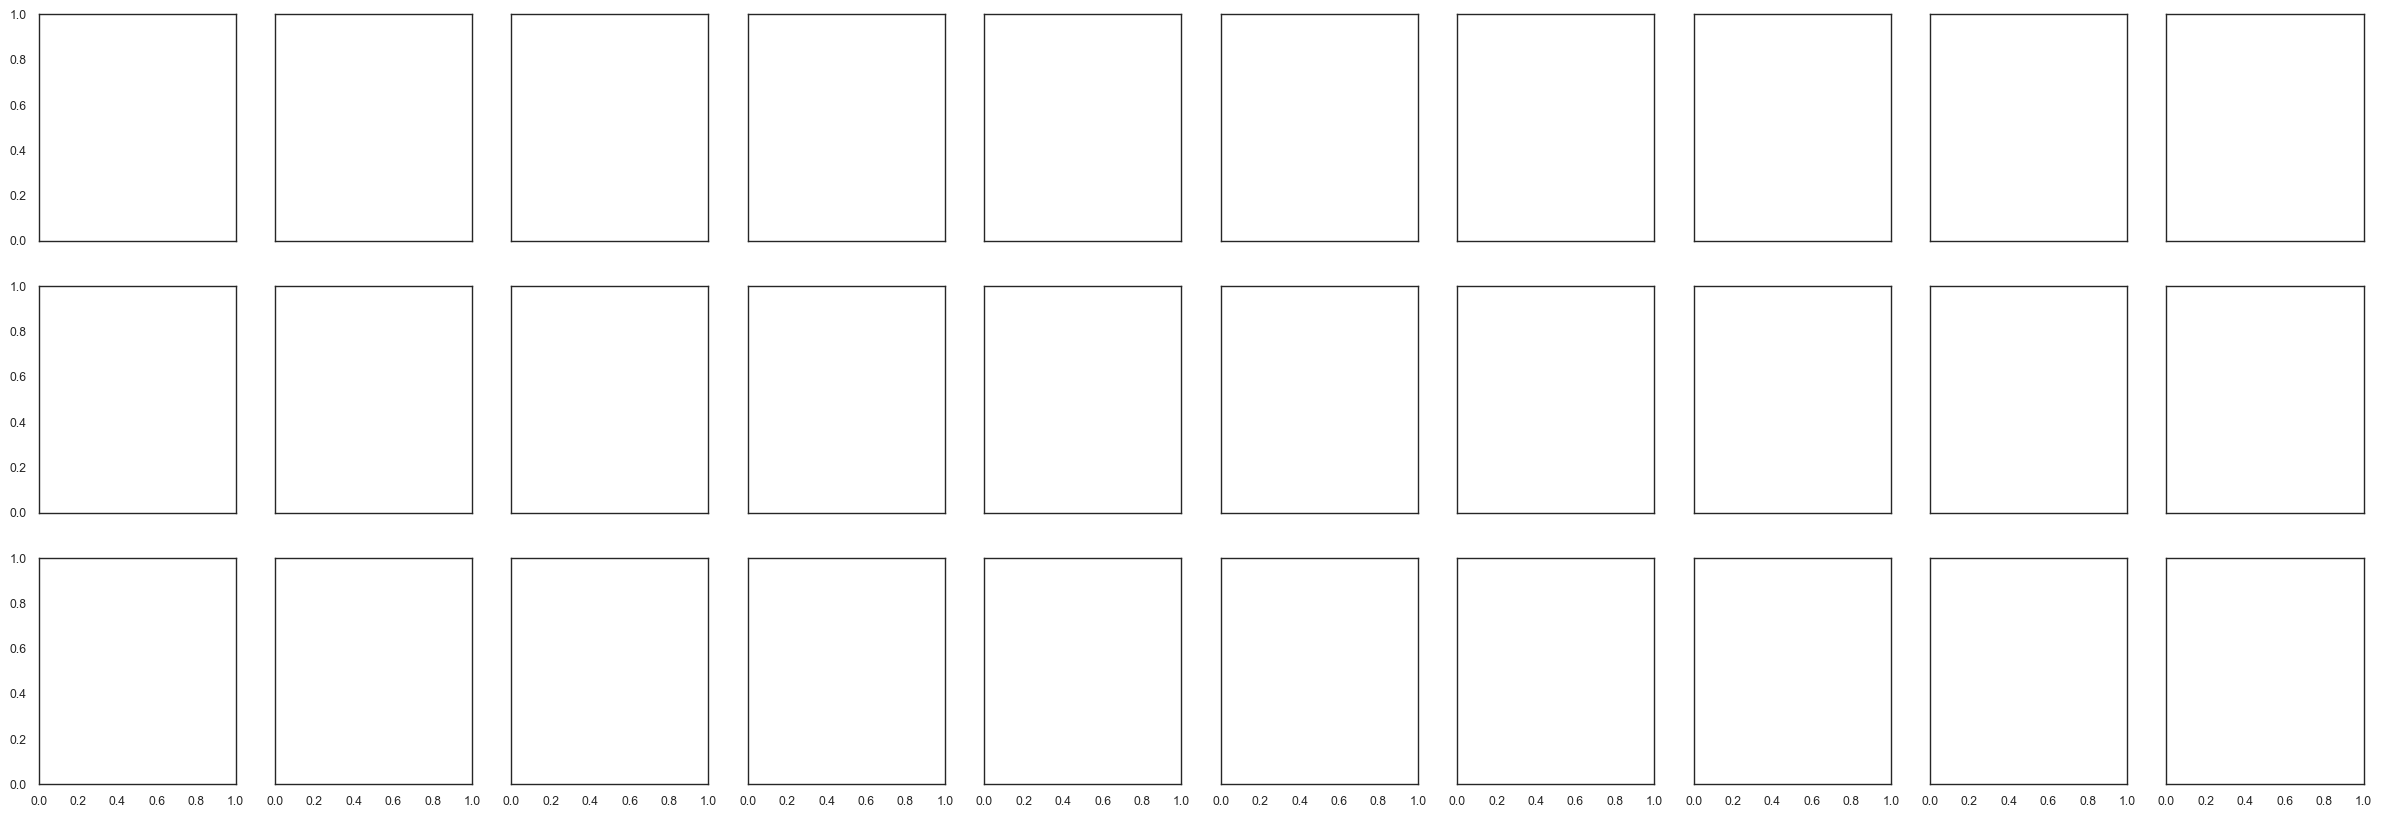

In [44]:
fig, ax = plt.subplots(3,10, figsize=(30,10), sharex=True, sharey=True)

for i,ag in enumerate(config.ANTIGENS):
    for j, task in enumerate(["ONE_VS_NINE", "HIGH_VS_95LOW", "HIGH_VS_LOOSER"]):
        with open(f'../data/mutant_attributions_v2.0-2_mutants/{ag}_{task}_mut_igs_attributions.json', 'r') as f:
            records_mut = json.load(f)
        df_mut_attr = pd.DataFrame.from_records(records_mut)
        df_mut_attr.rename(columns={'slide':'Slide'}, inplace=True)
        mut_eng_path = glob.glob(f'../data/mutant_energy_contributions/{ag}_{task}_mut_igs_energy_contributions_for_*.tsv')[0]
        df_mut_eng = pd.read_csv(mut_eng_path, sep='\t', header=1)
        df = pd.DataFrame.merge(df_mut_attr, df_mut_eng[['Slide', 'Energy', 'contribPerAAparaBind', 'contribPerAAparaFold']], how = 'outer', on = 'Slide')
        df["energies"] = df.apply(lambda x: np.array(utils.extract_contributions_from_string(x["contribPerAAparaBind"])[1]), axis=1)
        df["energies_fold"] = df.apply(lambda x: np.array(utils.extract_contributions_from_string(x["contribPerAAparaFold"])[1]), axis=1)
        df['energies_total'] = df_5e94["energies_fold"] + df_5e94["energies"]
        org_slides = df['original_slide'].unique()

        #dirty but fast to write
        if task == "ONE_VS_NINE":
            task_type = datasets.ClassificationTaskType.ONE_VS_NINE 
            color= '#FF5733'
        elif task == "HIGH_VS_95LOW":
            task_type = datasets.ClassificationTaskType.HIGH_VS_95LOW
            color = '#00A6ED'
        else:
            task_type = datasets.ClassificationTaskType.HIGH_VS_LOOSER
            color = '#FFC300'
        
        ag_1 = ag
        split_id = 4
        seed_id = 0
        task_ = datasets.ClassificationTask(
                            task_type=task_type,
                            ag_pos=ag_1,
                            ag_neg="auto",
                            seed_id=seed_id,
                            split_id=split_id,
                        )
        df_org_eng = get_miniabsolut_dataframes(task_, load_energy_contributions=True)

        
        df_org_eng = df_org_eng[df_org_eng['Slide'].isin(org_slides)].copy()
        
        df_org_eng["energies_org"] = df_org_eng.apply(lambda x: np.array(utils.extract_contributions_from_string(x["contribPerAAparaBind"])[1]), axis=1)
        df_org_eng["energies_fold_org"] = df_org_eng.apply(lambda x: np.array(utils.extract_contributions_from_string(x["contribPerAAparaFold"])[1]), axis=1)
        df_org_eng['energies_total_org'] = df_org_eng["energies_fold_org"] + df_org_eng["energies_org"]

        df_org_eng.rename(columns={'Slide':'original_slide'}, inplace=True)
        df_org_eng = df_org_eng[['original_slide', 'energies_org', 'energies_fold_org', 'energies_total_org']]
        df_mut_org = pd.DataFrame.merge(df,df_org_eng, how='outer', on='original_slide').dropna(axis=0, subset=['original_slide', 'energies_total_org', 'energies_total'])
                        
        df_mut_org['mut_pos'] = df_mut_org.apply(lambda x: compare_slides(x['Slide'], x['original_slide']), axis=1)
        df_mut_org['delta pos attr'] = df_mut_org.apply(lambda row: row['original_attributions'][0][row['mut_pos']] - row['attributions'][0][row['mut_pos']], axis=1)
        df_mut_org['delta pos eng'] = df_mut_org.apply(lambda row: row['energies_org'][row['mut_pos']] - row['energies'][row['mut_pos']], axis=1)
        
        sns.scatterplot(x='delta pos eng', y='delta pos attr', data=df_mut_org,  ax=ax[j, i], color = color)


In [138]:
task

'ONE_VS_NINE'

In [135]:
df_mut_org

Slide                      0
enc                        0
original_slide             0
original_enc               0
attributions               0
baseline                   0
original_attributions      0
original_baseline          0
Energy                     0
contribPerAAparaBind       0
contribPerAAparaFold       0
energies                   0
energies_fold              0
energies_total           584
energies_org               0
energies_fold_org          0
energies_total_org         0
mut_pos                    0
delta pos attr             0
dtype: int64

In [66]:
#read mutant atr
with open('../data/mutant_attributions_v2.0-2_mutants/5E94_ONE_VS_NINE_mut_igs_attributions.json', 'r') as f:
    records_mut = json.load(f)

In [67]:
# records_mut json to dataframe
df_5e94_mut_attr = pd.DataFrame.from_records(records_mut)


In [68]:
df_5e94_mut_attr.rename(columns={'slide':'Slide'}, inplace=True)

In [69]:
#this seems to be only binders. But then whe calculate it several times for different tasks?
df_5e94_mut_eng = pd.read_csv('../data/mutant_energy_contributions/5E94_ONE_VS_NINE_mut_igs_energy_contributions_for_5E94_G.tsv', sep='\t', header=1)

In [70]:
df_5e94_mut_eng[['Slide', 'Energy', 'contribPerAAparaBind', 'contribPerAAparaFold']]

Slide  Energy                               contribPerAAparaBind  \
0     DCPLLLYFDYW  -84.13  Da:1_-1.63,Cb:1_-2.27,Pc:1_-1.87,Ld:2_-11.82,L...   
1     ECPLLLYFDYW  -83.98  Ea:1_-1.48,Cb:1_-2.27,Pc:1_-1.87,Ld:2_-11.82,L...   
2     FCPLLLYFDYW  -91.42  Fa:4_-19.24,Cb:3_-10.66,Ld:1_-3.92,Le:2_-11.57...   
3     HCPLLLYFDYW  -96.84  Ha:3_-9.01,Cb:2_-8.69,Pc:1_-1.57,Ld:1_-7.37,Le...   
4     ICPLLLYFDYW -101.31  Ia:3_-13.48,Cb:2_-8.69,Pc:1_-1.57,Ld:1_-7.37,L...   
...           ...     ...                                                ...   
2400  RRHLLLRFLFA  -95.46  Ra:2_-8.06,Rb:1_-3.16,Ld:3_-11.35,Le:3_-14.36,...   
2401  SRHLLLRFLFA  -95.24  Sa:2_-7.84,Rb:1_-3.16,Ld:3_-11.35,Le:3_-14.36,...   
2402  TRHLLLRFLFA  -96.08  Ta:2_-8.68,Rb:1_-3.16,Ld:3_-11.35,Le:3_-14.36,...   
2403  VRHLLLRFLFA -100.36  Va:2_-12.96,Rb:1_-3.16,Ld:3_-11.35,Le:3_-14.36...   
2404  WRHLLLRFLFA  -99.68  Wa:2_-12.28,Rb:1_-3.16,Ld:3_-11.35,Le:3_-14.36...   

                                   contribPerAAparaFold  
0        Da:1_-3.48,Cb:1_-5.83,Le:2_-13.11,Fh:2_-10.76,  
1        Ea:1_-3.56,Cb:1_-5.83,Le:2_-13.11,Fh:2_-10.84,  
2     Fa:1_-7.26,Pc:1_-4.25,Ld:1_-5.67,Yg:1_-5.67,Fh...  
3                                Ld:1_-5.67,Yg:1_-5.67,  
4                                Ld:1_-5.67,Yg:1_-5.67,  
...                                                 ...  
2400       Rb:1_-4.03,Le:1_-4.03,Fh:1_-4.81,Ak:1_-4.81,  
2401       Rb:1_-4.03,Le:1_-4.03,Fh:1_-4.81,Ak:1_-4.81,  
2402       Rb:1_-4.03,Le:1_-4.03,Fh:1_-4.81,Ak:1_-4.81,  
2403       Rb:1_-4.03,Le:1_-4.03,Fh:1_-4.81,Ak:1_-4.81,  
2404       Rb:1_-4.03,Le:1_-4.03,Fh:1_-4.81,Ak:1_-4.81,  

[2405 rows x 4 columns]

In [71]:
df_5e94_mut_eng.Slide

0       DCPLLLYFDYW
1       ECPLLLYFDYW
2       FCPLLLYFDYW
3       HCPLLLYFDYW
4       ICPLLLYFDYW
           ...     
2400    RRHLLLRFLFA
2401    SRHLLLRFLFA
2402    TRHLLLRFLFA
2403    VRHLLLRFLFA
2404    WRHLLLRFLFA
Name: Slide, Length: 2405, dtype: object

In [72]:
df_5e94_mut_attr.columns

Index(['Slide', 'enc', 'original_slide', 'original_enc', 'attributions',
       'baseline', 'original_attributions', 'original_baseline'],
      dtype='object')

In [73]:
df_5e94 = pd.DataFrame.merge(df_5e94_mut_attr, df_5e94_mut_eng[['Slide', 'Energy', 'contribPerAAparaBind', 'contribPerAAparaFold']], how = 'outer', on = 'Slide')

In [74]:
df_5e94.head()["contribPerAAparaBind"]

0    Aa:1_-4.91,Ab:2_-9.82,Dc:1_-2.76,Ld:3_-14.36,L...
1    Ca:3_-8.75,Ab:1_-4.91,Dc:3_-5.13,Ld:3_-14.36,L...
2    Ea:1_-3.59,Ab:2_-9.82,Dc:1_-2.76,Ld:3_-14.36,L...
3    Ga:1_-4.16,Ab:2_-9.82,Dc:1_-2.76,Ld:3_-14.36,L...
4    Ha:1_-4.54,Ab:2_-9.82,Dc:1_-2.76,Ld:3_-14.36,L...
Name: contribPerAAparaBind, dtype: object

In [75]:
"""degree_energy_bind = utils.extract_contributions_from_string(energy_dict[slide]["contribPerAAparaBind"])
energy_dict[slide]["energies"] = degree_energy_bind[1]
energy_dict[slide]["degrees"] = degree_energy_bind[0]
energy_dict[slide]["energies_fold"] = utils.extract_contributions_from_string(energy_dict[slide]["contribPerAAparaFold"])[1]
energy_dict[slide]["energies_total"] = (np.array(energy_dict[slide]["energies"]) + np.array(energy_dict[slide]["energies_fold"])).tolist()"""

'degree_energy_bind = utils.extract_contributions_from_string(energy_dict[slide]["contribPerAAparaBind"])\nenergy_dict[slide]["energies"] = degree_energy_bind[1]\nenergy_dict[slide]["degrees"] = degree_energy_bind[0]\nenergy_dict[slide]["energies_fold"] = utils.extract_contributions_from_string(energy_dict[slide]["contribPerAAparaFold"])[1]\nenergy_dict[slide]["energies_total"] = (np.array(energy_dict[slide]["energies"]) + np.array(energy_dict[slide]["energies_fold"])).tolist()'

In [76]:
df_5e94["energies"] = df_5e94.apply(lambda x: np.array(utils.extract_contributions_from_string(x["contribPerAAparaBind"])[1]), axis=1)
df_5e94["energies_fold"] = df_5e94.apply(lambda x: np.array(utils.extract_contributions_from_string(x["contribPerAAparaFold"])[1]), axis=1)

In [77]:
df_5e94["energies"].iloc[0]

array([ -4.91,  -9.82,  -2.76, -14.36, -11.29,  -2.99,  -7.37, -14.1 ,
       -15.5 ,  -5.18,  -9.18])

In [78]:
df_5e94['energies_total'] = df_5e94["energies_fold"] + df_5e94["energies"]

In [79]:
#need to get energies for original slides
#lets first get org slides
org_slides = df_5e94['original_slide'].unique()


In [80]:
task_type = datasets.ClassificationTaskType.HIGH_VS_LOOSER
ag_1 = '5E94'
split_id = 4
seed_id = 0
task = datasets.ClassificationTask(
                    task_type=task_type,
                    ag_pos=ag_1,
                    ag_neg="auto",
                    seed_id=seed_id,
                    split_id=split_id,
                )
df_5e94_org_eng = get_miniabsolut_dataframes(task, load_energy_contributions=True)

In [81]:
df_5e94_org_eng["contribPerAAparaBind"]

0       Ca:2_-9.4,Hb:1_-3.58,Lc:3_-20.32,Ld:3_-14.1,We...
1       Ca:2_-9.4,Ab:1_-4.04,Ic:3_-19.13,Ld:3_-14.1,Ye...
2       Ga:2_-6.28,Wb:1_-5.18,Ic:3_-19.13,Ld:3_-14.1,F...
3       Ca:2_-9.4,Ab:1_-4.04,Fc:3_-20.2,Yd:3_-10.41,Ye...
4       Aa:3_-6.18,Rb:1_-4.03,Fc:3_-11.48,Yd:3_-11.22,...
                              ...                        
4994    Ca:1_-5.83,Tb:2_-8.68,Pc:1_-3.19,Ld:3_-14.36,W...
4995    Pa:2_-6.5,Pb:1_-3.32,Lc:3_-20.32,Ld:3_-14.1,Re...
4996    Ta:1_-4.34,Lb:2_-14.74,Gc:1_-3.01,Ld:3_-14.36,...
4997    La:3_-14.1,Lb:3_-20.32,Rc:1_-3.07,Td:1_-4.34,G...
4998    Qa:2_-6.08,Lb:1_-6.48,Lc:3_-20.32,Wd:3_-11.16,...
Name: contribPerAAparaBind, Length: 9998, dtype: object

In [82]:
#filter df_5e94_org_eng so that slides in org_slides
df_5e94_org_eng = df_5e94_org_eng[df_5e94_org_eng['Slide'].isin(org_slides)].copy()

In [83]:
df_5e94_org_eng["energies_org"] = df_5e94_org_eng.apply(lambda x: np.array(utils.extract_contributions_from_string(x["contribPerAAparaBind"])[1]), axis=1)
df_5e94_org_eng["energies_fold_org"] = df_5e94_org_eng.apply(lambda x: np.array(utils.extract_contributions_from_string(x["contribPerAAparaFold"])[1]), axis=1)
df_5e94_org_eng['energies_total_org'] = df_5e94_org_eng["energies_fold_org"] + df_5e94_org_eng["energies_org"]

In [86]:
df_5e94_org_eng

ID_slide_Variant                CDR3   Best        Slide  Energy  \
205        378568_03a    CAREWWLLLYWYFDVW  False  EWWLLLYWYFD  -96.34   
364        705769_03a  CARRADLLWLLYWYFDVW  False  RADLLWLLYWY  -96.58   
2571      3964486_03a      CARWGLLLDYFDYW   True  WGLLLDYFDYW -100.87   
3266      5001759_01a     CARLLRYLYWYFDVW   True  ARLLRYLYWYF -101.45   
3925      5997394_03a      CARSGFLLHYFDYW   True  SGFLLHYFDYW  -97.22   
4703      6975345_01a      CARHLLLRFLFAYW  False  ARHLLLRFLFA  -97.22   

              Structure                                    interactionCode  \
205   145183-UDUDDULSUS  j0038i0039a0069b0070c0071d0072b0074d0074d0082e...   
364   141219-USURSLDUUD  d0039k0070j0071i0072i0074k0074i0082h0083f0087h...   
2571  149279-SUDDULSUSL  k0036i0038h0039a0070b0071c0072a0074c0074c0082d...   
3266  149279-SUDDULSUSL  k0036i0038h0039a0070b0071c0072a0074c0074c0082d...   
3925  149279-SUDDULSUSL  k0036i0038h0039a0070b0071c0072a0074c0074c0082d...   
4703  145315-USUURSDRLL  d0038e0039k0071j0072j0074j0082i0083g0087i0087d...   

                                       AGboundPositions hotspot_ID  \
205   38-39-69-70-71-72-74-82-83-87-88-89-91-92-93-9...  5E94_G_H1   
364   39-70-71-72-74-82-83-87-88-91-93-94-1005-1006-...  5E94_G_H1   
2571  36-38-39-70-71-72-74-82-83-87-88-89-90-91-92-9...  5E94_G_H1   
3266  36-38-39-70-71-72-74-82-83-87-88-89-90-91-92-9...  5E94_G_H1   
3925  36-38-39-70-71-72-74-82-83-87-88-89-90-91-92-9...  5E94_G_H1   
4703  38-39-71-72-74-82-83-87-88-91-92-93-94-1006-10...  5E94_G_H1   

                              seqAGEpitope  ...  \
205     D1E1G1H1V1Y1F2L1Q1S2S2L1W1R1D1L2L1  ...   
364       E1H1V1Y1F2L1Q1S2S1W1D1L2L1L2L1Y1  ...   
2571  T1D1E1H1V1Y1F2L1Q1S2S2L1P1W1R2D1L2L1  ...   
3266  T1D1E1H1V1Y1F2L1Q1S2S2L1P1W1R2D1L2L1  ...   
3925  T1D1E1H1V1Y1F2L1Q1S2S2L1P1W1R2D1L2L1  ...   
4703      D1E1V1Y1F1L1Q1S2S2W1R1D1L2L2L1Y1  ...   

                                         AAcompoFullCDR sizeCDR3  \
205   0.0625_0.0625_0.0625_0.0625_0.0625_0_0_0_0_0.1...       16   
364   0.111111_0.0555556_0.111111_0_0.0555556_0_0_0_...       18   
2571  0.0714286_0.0714286_0.142857_0_0.0714286_0.071...       14   
3266  0.0666667_0.0666667_0.0666667_0_0.0666667_0_0_...       15   
3925  0.0714286_0.0714286_0.0714286_0_0.142857_0.071...       14   
4703  0.142857_0.0714286_0_0_0.142857_0_0.0714286_0_...       14   

     InterCodeInternal                                    contribPerAAepi  \
205                cf-  D38:1_-3.48,E39:1_-2.79,G69:1_-1.22,H70:1_-3.9...   
364                gj-  E39:1_-3.59,H70:1_-3.52,V71:1_-5.18,Y72:1_-4.1...   
2571               be-  T36:1_-3.22,D38:1_-1.21,E39:1_-3.56,H70:1_-3.9...   
3266               be-  T36:1_-4.28,D38:1_-2.84,E39:1_-2.79,H70:1_-2.4...   
3925               be-  T36:1_-3.22,D38:1_-1.21,E39:1_-3.56,H70:1_-2.1...   
4703            be-hk-  D38:1_-3.4,E39:1_-3.59,V71:1_-4.04,Y72:1_-5.66...   

                                   contribPerAAparaBind  \
205   Ea:1_-1.22,Wb:2_-10.14,Wc:1_-5.18,Ld:3_-20.32,...   
364   Ra:1_-4.03,Ab:2_-9.82,Dc:1_-2.76,Ld:3_-14.36,L...   
2571  Wa:2_-10.14,Gb:1_-3.38,Lc:3_-20.32,Ld:3_-14.1,...   
3266  Aa:2_-7.22,Rb:1_-3.07,Lc:3_-20.32,Ld:3_-14.1,R...   
3925  Sa:2_-6.13,Gb:1_-3.38,Fc:3_-20.2,Ld:3_-14.1,Le...   
4703  Aa:2_-9.82,Rb:1_-3.16,Ld:3_-11.35,Le:3_-14.36,...   

                              contribPerAAparaFold     class  \
205                         Wc:1_-6.14,Lf:1_-6.14,  positive   
364                         Lg:1_-6.14,Wj:1_-6.14,  positive   
2571                        Gb:1_-4.16,Le:1_-4.16,  positive   
3266                        Rb:1_-1.55,Re:1_-1.55,  positive   
3925                        Gb:1_-4.16,Le:1_-4.16,  positive   
4703  Rb:1_-4.03,Le:1_-4.03,Fh:1_-4.81,Ak:1_-4.81,  positive   

                                           energies_org  \
205   [-1.22, -10.14, -5.18, -20.32, -14.1, -7.37, -...   
364   [-4.03, -9.82, -2.76, -14.36, -11.29, -2.99, -...   
2571  [-10.14, -3.38, -20.32, -14.1, -7.

In [87]:
df_5e94_org_eng[['Slide', 'energies_org', 'energies_fold_org', 'energies_total_org']]

Slide                                       energies_org  \
205   EWWLLLYWYFD  [-1.22, -10.14, -5.18, -20.32, -14.1, -7.37, -...   
364   RADLLWLLYWY  [-4.03, -9.82, -2.76, -14.36, -11.29, -2.99, -...   
2571  WGLLLDYFDYW  [-10.14, -3.38, -20.32, -14.1, -7.37, -1.63, -...   
3266  ARLLRYLYWYF  [-7.22, -3.07, -20.32, -14.1, -4.03, -2.78, -1...   
3925  SGFLLHYFDYW  [-6.13, -3.38, -20.2, -14.1, -7.37, -2.11, -8....   
4703  ARHLLLRFLFA  [-9.82, -3.16, 0.0, -11.35, -14.36, -11.29, -1...   

                                      energies_fold_org  \
205   [0.0, 0.0, -6.14, 0.0, 0.0, -6.14, 0.0, 0.0, 0...   
364   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -6.14, 0.0, 0.0...   
2571  [0.0, -4.16, 0.0, 0.0, -4.16, 0.0, 0.0, 0.0, 0...   
3266  [0.0, -1.55, 0.0, 0.0, -1.55, 0.0, 0.0, 0.0, 0...   
3925  [0.0, -4.16, 0.0, 0.0, -4.16, 0.0, 0.0, 0.0, 0...   
4703  [0.0, -4.03, 0.0, 0.0, -4.03, 0.0, 0.0, -4.81,...   

                                     energies_total_org  
205   [-1.22, -10.14, -11.32, -20.32, -14.1, -13.51,...  
364   [-4.03, -9.82, -2.76, -14.36, -11.29, -2.99, -...  
2571  [-10.14, -7.54, -20.32, -14.1, -11.53000000000...  
3266  [-7.22, -4.62, -20.32, -14.1, -5.58, -2.78, -1...  
3925  [-6.13, -7.54, -20.2, -14.1, -11.5300000000000...  
4703  [-9.82, -7.19, 0.0, -11.35, -18.39, -11.29, -1...

In [88]:
df_5e94_org_eng.rename(columns={'Slide':'original_slide'}, inplace=True)
df_5e94_org_eng = df_5e94_org_eng[['original_slide', 'energies_org', 'energies_fold_org', 'energies_total_org']]
df_mut_org = pd.DataFrame.merge(df_5e94,df_5e94_org_eng, how='outer', on='original_slide').dropna(axis=0, subset=['original_slide', 'energies_total_org'])

In [90]:
df_5e94_org_eng

original_slide                                       energies_org  \
205     EWWLLLYWYFD  [-1.22, -10.14, -5.18, -20.32, -14.1, -7.37, -...   
364     RADLLWLLYWY  [-4.03, -9.82, -2.76, -14.36, -11.29, -2.99, -...   
2571    WGLLLDYFDYW  [-10.14, -3.38, -20.32, -14.1, -7.37, -1.63, -...   
3266    ARLLRYLYWYF  [-7.22, -3.07, -20.32, -14.1, -4.03, -2.78, -1...   
3925    SGFLLHYFDYW  [-6.13, -3.38, -20.2, -14.1, -7.37, -2.11, -8....   
4703    ARHLLLRFLFA  [-9.82, -3.16, 0.0, -11.35, -14.36, -11.29, -1...   

                                      energies_fold_org  \
205   [0.0, 0.0, -6.14, 0.0, 0.0, -6.14, 0.0, 0.0, 0...   
364   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -6.14, 0.0, 0.0...   
2571  [0.0, -4.16, 0.0, 0.0, -4.16, 0.0, 0.0, 0.0, 0...   
3266  [0.0, -1.55, 0.0, 0.0, -1.55, 0.0, 0.0, 0.0, 0...   
3925  [0.0, -4.16, 0.0, 0.0, -4.16, 0.0, 0.0, 0.0, 0...   
4703  [0.0, -4.03, 0.0, 0.0, -4.03, 0.0, 0.0, -4.81,...   

                                     energies_total_org  
205   [-1.22, -10.14, -11.32, -20.32, -14.1, -13.51,...  
364   [-4.03, -9.82, -2.76, -14.36, -11.29, -2.99, -...  
2571  [-10.14, -7.54, -20.32, -14.1, -11.53000000000...  
3266  [-7.22, -4.62, -20.32, -14.1, -5.58, -2.78, -1...  
3925  [-6.13, -7.54, -20.2, -14.1, -11.5300000000000...  
4703  [-9.82, -7.19, 0.0, -11.35, -18.39, -11.29, -1...

In [175]:
df_5e94_org_eng.shape

(6, 4)

In [177]:
len(org_slides)

17

In [104]:
def  compare_slides(slide1, slide2):
    for i in range(11):
        if slide1[i] != slide2[i]:
            return i

In [126]:
df_mut_org['mut_pos'] = df_mut_org.apply(lambda x: compare_slides(x['Slide'], x['original_slide']), axis=1)
df_mut_org['delta pos attr'] = df_mut_org.apply(lambda row: row['original_attributions'][0][row['mut_pos']] - row['attributions'][0][row['mut_pos']], axis=1)
df_mut_org['delta pos eng'] = df_mut_org.apply(lambda row: row['energies_total_org'][row['mut_pos']] - row['energies_total'][row['mut_pos']], axis=1)

<AxesSubplot:xlabel='delta pos eng', ylabel='delta pos attr'>

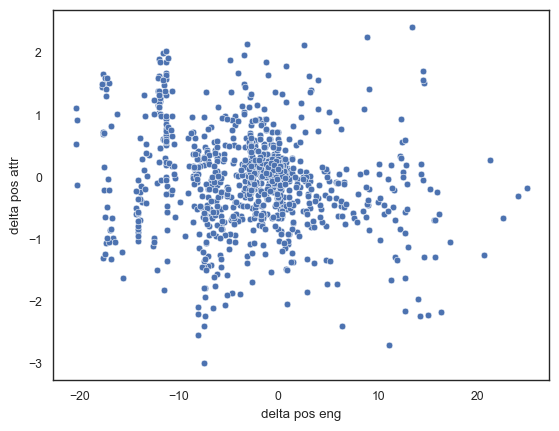

In [130]:
sns.scatterplot(x='delta pos eng', y='delta pos attr', data=df_mut_org)

In [191]:
df_5e94_str = pd.read_csv('../data/full_data/divided2classes/5E94_GAnalyses/5E94_G_MascotteSlices.txt', sep='\t', header=1)

In [192]:
df_5e94_str[df_5e94_str['Slide'].isin(org_slides)].shape

(17, 6)

In [193]:
len(org_slides)

17

In [200]:
for ag in config.ANTIGENS:
    with open(f'../data/mutant_attributions_v2.0-2_mutants/{ag}_ONE_VS_NINE_mut_igs_attributions.json', 'r') as f:
        records_mut = json.load(f)
    df_attr = pd.DataFrame.from_records(records_mut)
    org_slides = df_attr['original_slide'].unique()
    path_str = glob.glob(f'../data/full_data/divided2classes/{ag}_*/*_MascotteSlices.txt')
    df_struct = pd.read_csv(path_str, sep='\t', header=1)
    df_struct = df_struct[df_struct['Slide'].isin(org_slides)].copy().reset_index(drop=True)
    df_struct.to_csv(f'../data/wt_4_mut', sep='\t', index=False)

    

: 

: 

In [7]:
for ag in config.ANTIGENS:
    with open(f'../data/mutant_attributions_v2.0-2_mutants/{ag}_ONE_VS_NINE_mut_igs_attributions.json', 'r') as f:
        records_mut = json.load(f)
    df_attr = pd.DataFrame.from_records(records_mut)
    org_slides = df_attr['original_slide'].unique()
    path_str = glob.glob(f'../data/full_data/divided2classes/{ag}_*/*_MascotteSlices.txt')[0]
    df_struct = pd.read_csv(path_str, sep='\t', header=1)
    df_struct = df_struct[df_struct['Slide'].isin(org_slides)].copy().reset_index(drop=True)
    if len(org_slides) != df_struct.shape[0]:
        print(ag)
    df_struct.to_csv(f'../data/wt_4_mut/{ag}_wt_structures.tsv', sep='\t', index=False)

In [9]:
#section 2 main plots
logit_energy_corr_path = "../data/07e_LogitEnergyCorrelations.tsv"
df_logits = pd.read_csv(logit_energy_corr_path, sep="\t")
df_logits_old = pd.read_csv("../data/07e_LogitEnergyCorrelations_old.tsv", sep="\t")
df_logits_new = pd.concat(
    [
        df_logits.query("task_type == '1v1'").copy(),
        df_logits_old.query("task_type != '1v1'").copy(),
    ],
    axis=0
)
df_logits_new.task_type.value_counts()
df_logits = df_logits_new.copy()

In [8]:
df_logits

task_type ag_pos ag_neg  seed_id  split_id         r              p  \
0               1v1   3VRL   1NSN        0        42 -0.585052   0.000000e+00   
1               1v1   3VRL   3RAJ        0        42 -0.334859  2.828910e-131   
2               1v1   3VRL   5E94        0        42 -0.151120   6.265870e-27   
3               1v1   3VRL   1H0D        0        42 -0.522465   0.000000e+00   
4               1v1   3VRL   1WEJ        0        42 -0.537149   0.000000e+00   
..              ...    ...    ...      ...       ...       ...            ...   
285   high_vs_95low   1OB1   auto        0         3 -0.945239   0.000000e+00   
286  high_vs_looser   1OB1   auto        0         3 -0.847128   0.000000e+00   
287             1v9   1OB1   auto        0         4 -0.371357  2.713249e-163   
288   high_vs_95low   1OB1   auto        0         4 -0.938794   0.000000e+00   
289  high_vs_looser   1OB1   auto        0         4 -0.841937   0.000000e+00   

           r2     r_pos    r_pos2  ...  Energy_std  logits_pos_mean  \
0    0.342285 -0.585052  0.342285  ...    1.678374        14.436833   
1    0.112130 -0.334859  0.112130  ...    1.678374         8.870269   
2    0.022837 -0.151120  0.022837  ...    1.678374        13.560961   
3    0.272969 -0.522465  0.272969  ...    1.678374        15.293151   
4    0.288529 -0.537149  0.288529  ...    1.678374        13.008614   
..        ...       ...       ...  ...         ...              ...   
285  0.893476 -0.585123  0.342369  ...    9.121032         9.764555   
286  0.717626 -0.702079  0.492915  ...    2.761174         2.685971   
287  0.137906 -0.371357  0.137906  ...    1.699552         4.038471   
288  0.881335 -0.548172  0.300493  ...    9.043904         8.971328   
289  0.708857 -0.651385  0.424302  ...    2.750299         2.970026   

     logits_pos_std  Energy_pos_mean  Energy_pos_std  logits_neg_mean  \
0          6.624078       -98.309468        1.678374              NaN   
1          4.636723       -98.309468        1.678374              NaN   
2          6.124475       -98.309468        1.678374              NaN   
3          7.849567       -98.309468        1.678374              NaN   
4          6.376433       -98.309468        1.678374              NaN   
..              ...              ...             ...              ...   
285        4.299280       -94.427450        1.689579       -23.275802   
286        2.268316       -94.427450        1.689579        -4.702230   
287        2.800609       -94.416142        1.699552              NaN   
288        3.657152       -94.416142        1.699552       -24.029736   
289        2.372439       -94.416142        1.699552        -4.997981   

     logits_neg_std  Energy_neg_mean  Energy_neg_std  corr_type  
0               NaN              NaN             NaN        NaN  
1               NaN              NaN             NaN        NaN  
2               NaN              NaN             NaN        NaN  
3               NaN              NaN             NaN        NaN  
4               NaN              NaN             NaN        NaN  
..              ...              ...             ...        ...  
285       11.856658       -77.840072        5.094146     logits  
286        3.607461       -89.750485        1.206573     logits  
287             NaN              NaN             NaN     logits  
288       12.698218       -77.950599        5.012796     logits  
289        3.893428       -89.765180        1.193079     logits  

[360 rows x 28 columns]

In [10]:
# Correct for double antigen contribution from 1v1 (to pos and negative, symmetric)
df_logits_1v1 = df_logits.loc[df_logits["task_type"] == "1v1"].copy()
ag_pos_series = df_logits_1v1["ag_pos"]
df_logits_1v1["ag_pos"] = df_logits_1v1["ag_neg"]
df_logits_1v1["ag_neg"] = ag_pos_series
del ag_pos_series
df_logits = pd.concat([df_logits, df_logits_1v1], axis=0)

In [11]:
task_order = ["high_vs_95low", "1v1", "1v9", "high_vs_looser"]

In [12]:
ag_order = [
        "1FBI",
        "3VRL",
        "2YPV",
        "5E94",
        "1WEJ",
        "1OB1",
        "1NSN",
        "1H0D",
        "3RAJ",
        "1ADQ",
    ]

In [13]:
cmap_ag = dict(zip(ag_order, pellets['antigens']))

In [14]:
cmap_ag

{'1FBI': '#008080',
 '3VRL': '#FFA07A',
 '2YPV': '#000080',
 '5E94': '#FFD700',
 '1WEJ': '#228B22',
 '1OB1': '#FF69B4',
 '1NSN': '#800080',
 '1H0D': '#FF6347',
 '3RAJ': '#00FF00',
 '1ADQ': '#FF1493'}

/var/folders/ww/bptfq9n12_jbyy78qcjp7s4c0000gn/T/ipykernel_1973/2973501251.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(map(lambda x: visualisations.PlotParams.map_task_type_to_clean[x], task_order))


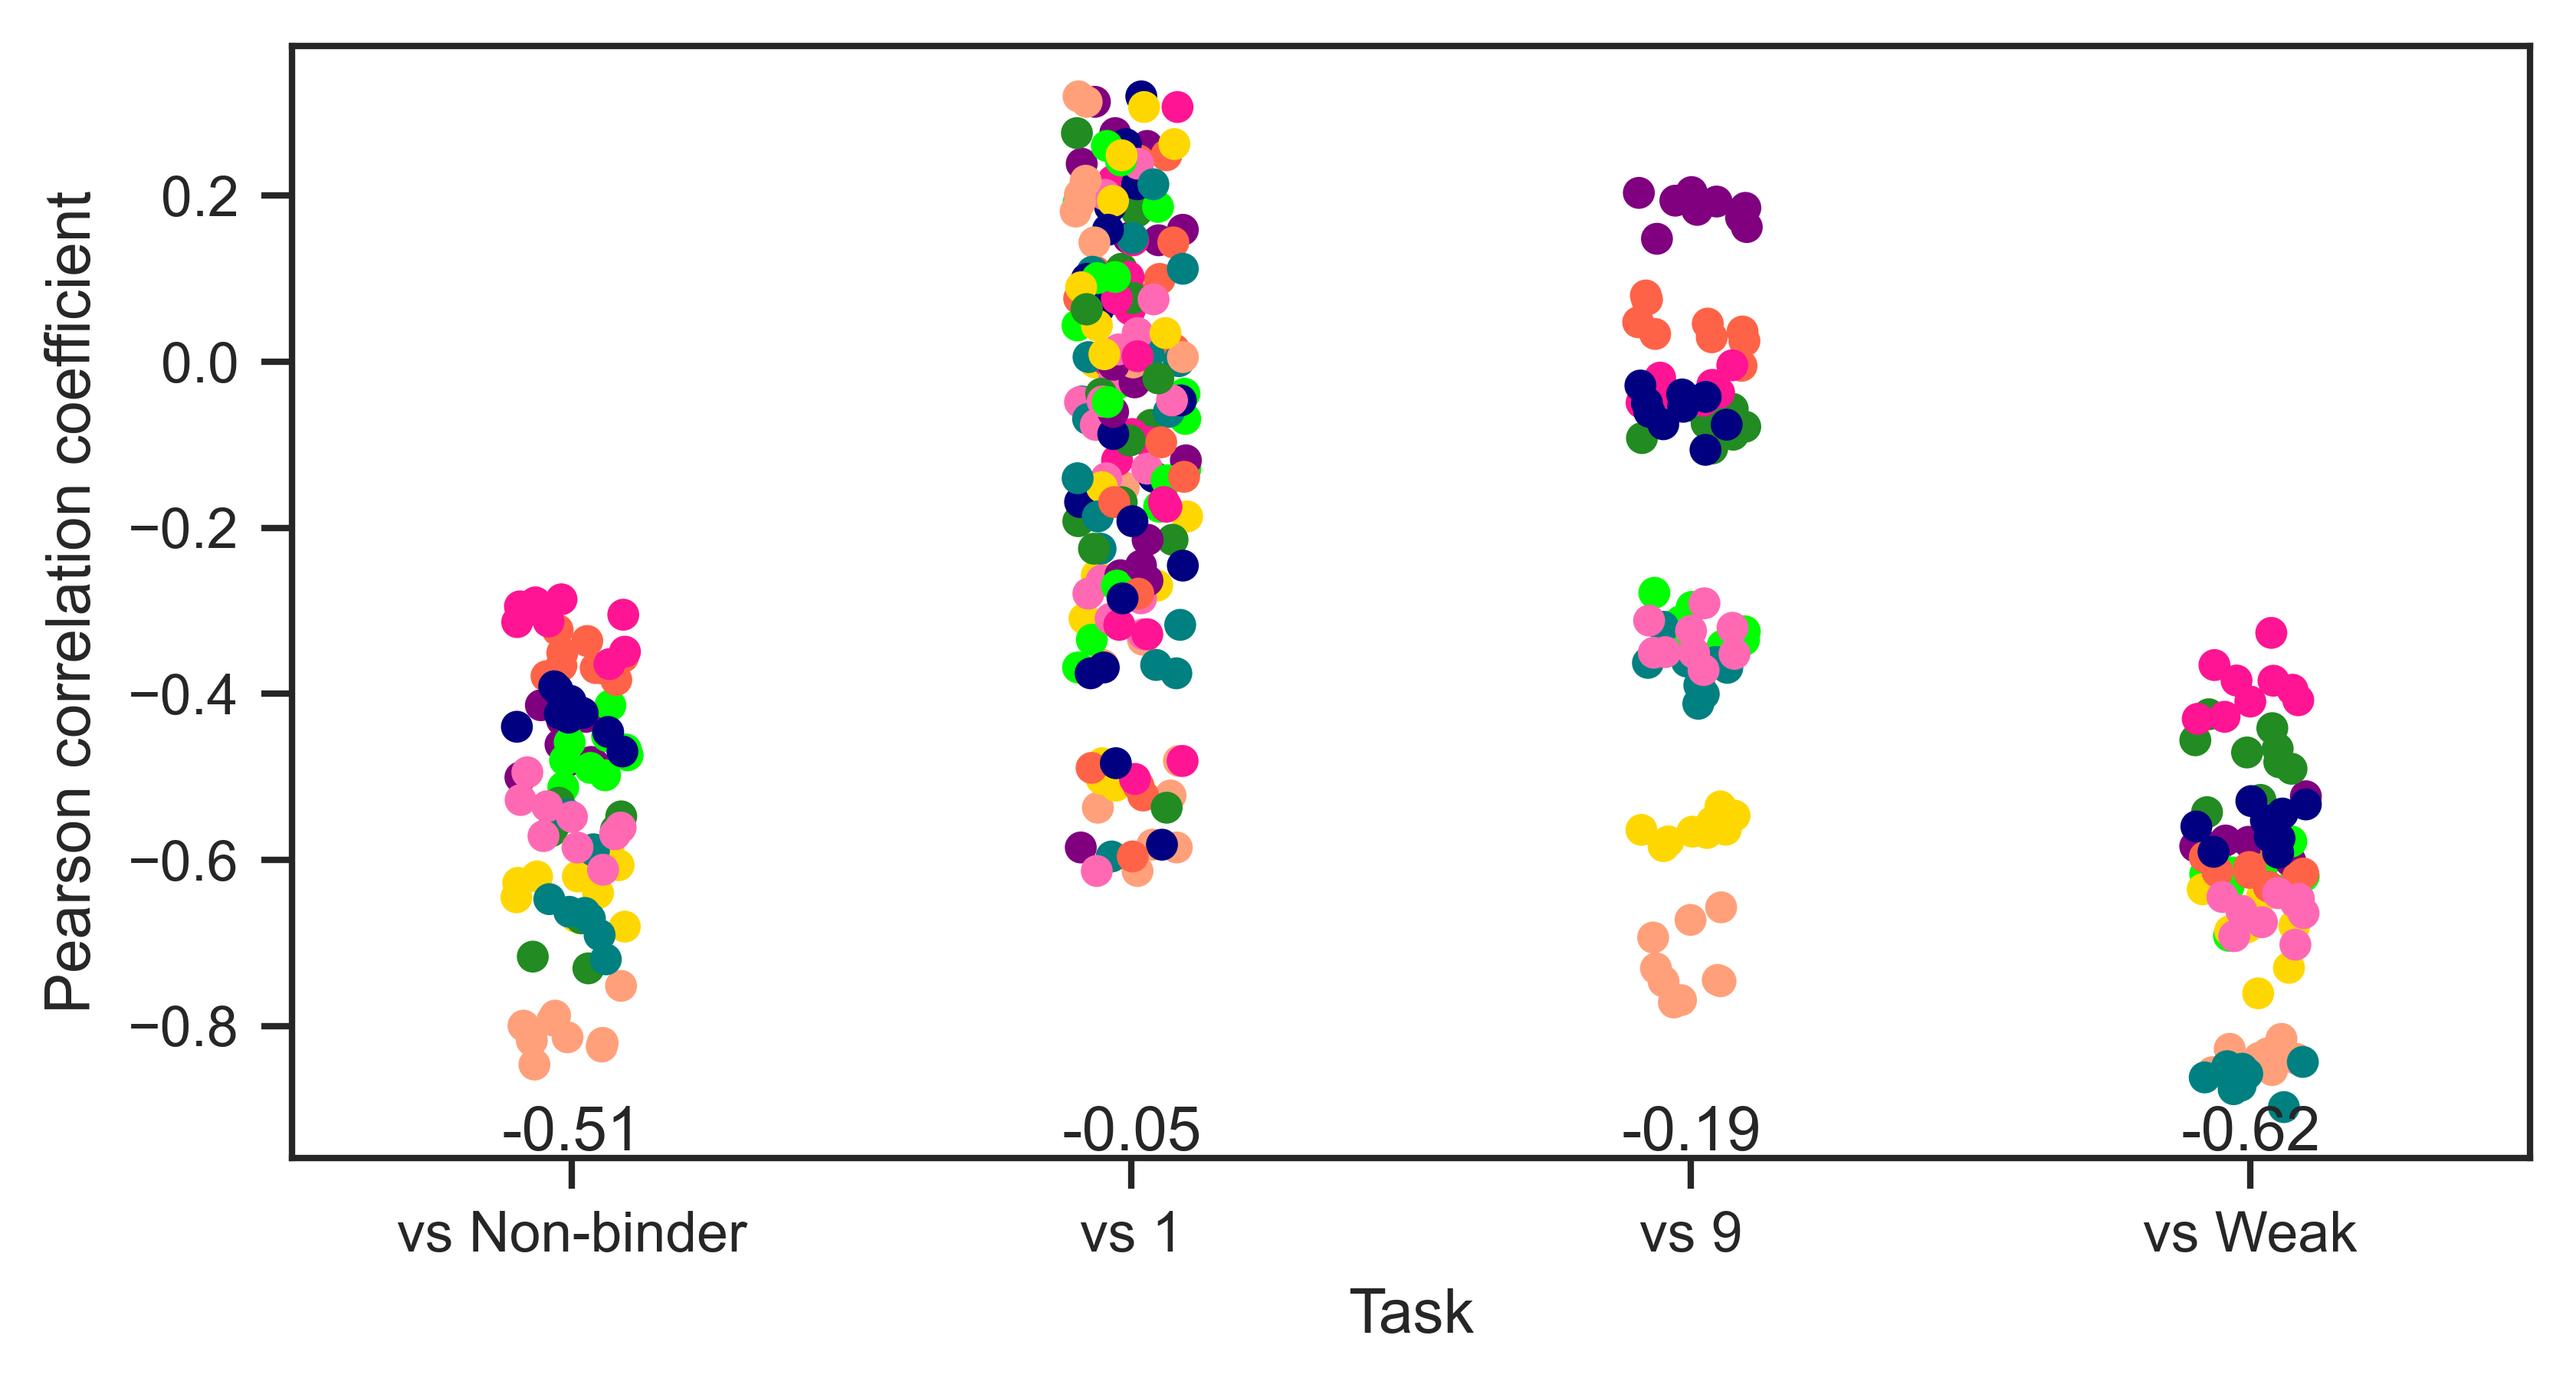

In [201]:
fig, ax = plt.subplots(figsize=(2*3.14, 3.14), dpi=600)
# sns.set_theme(context="paper")
# sns.set_style("white")
sns.set_style("white")
sns.set_style('ticks')

task_order = ["high_vs_95low", "1v1", "1v9", "high_vs_looser"]
sns.stripplot(
    data=df_logits, 
    x="task_type", 
    y="r_pos", 
    hue="ag_pos",
    palette=cmap_ag,
    ax=ax, 
    order=task_order,
)

# Display no legend
ax.legend_.remove()

# Relabel xticks
ax.set_xticklabels(map(lambda x: visualisations.PlotParams.map_task_type_to_clean[x], task_order))

# Add median r_pos per task
r_median_df = df_logits.groupby(["task_type"]).agg({"r_pos": "median"})
for i, row in r_median_df.iterrows():
    ax.text(
        i,
        -0.95,
        f"{row['r_pos']:.2f}",
        # Center center
        horizontalalignment='center',
    )


ax.set_ylabel("Pearson correlation coefficient")
ax.set_xlabel("Task")
fig.savefig("figures/section2/fig2_r_logits_energy.svg")

In [15]:
energy_contributions_path = "../data/07e_EnergyContributions.tsv"
df_attrib = pd.read_csv(energy_contributions_path, sep="\t")
# Duplicate 1v1 and reverse pos with negative to account for double contributions
df_attrib_1v1 = df_attrib.loc[df_attrib["task_type"] == "1v1"].copy()
#ag_pos_col = df_attrib_1v1["ag_pos"]
#df_attrib_1v1["ag_pos"] = df_attrib_1v1["ag_neg"]
#df_attrib_1v1["ag_neg"] = ag_pos_col
#del ag_pos_col


In [16]:
attr_to_calc_1v1 = []
for i, row in df_attrib_1v1.iterrows():
    ag_pos = row['ag_pos']
    ag_neg = row['ag_neg']
    task_1v1 = f'{ag_pos}__vs__{ag_neg}'
    attr_to_calc_1v1.append(task_1v1)



In [17]:
with open('../data/attr_to_calc_1v1.json','w') as f:
    json.dump(attr_to_calc_1v1, f)

/var/folders/ww/bptfq9n12_jbyy78qcjp7s4c0000gn/T/ipykernel_70590/1956367490.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(map(lambda x: visualisations.PlotParams.map_task_type_to_clean[x], task_order))


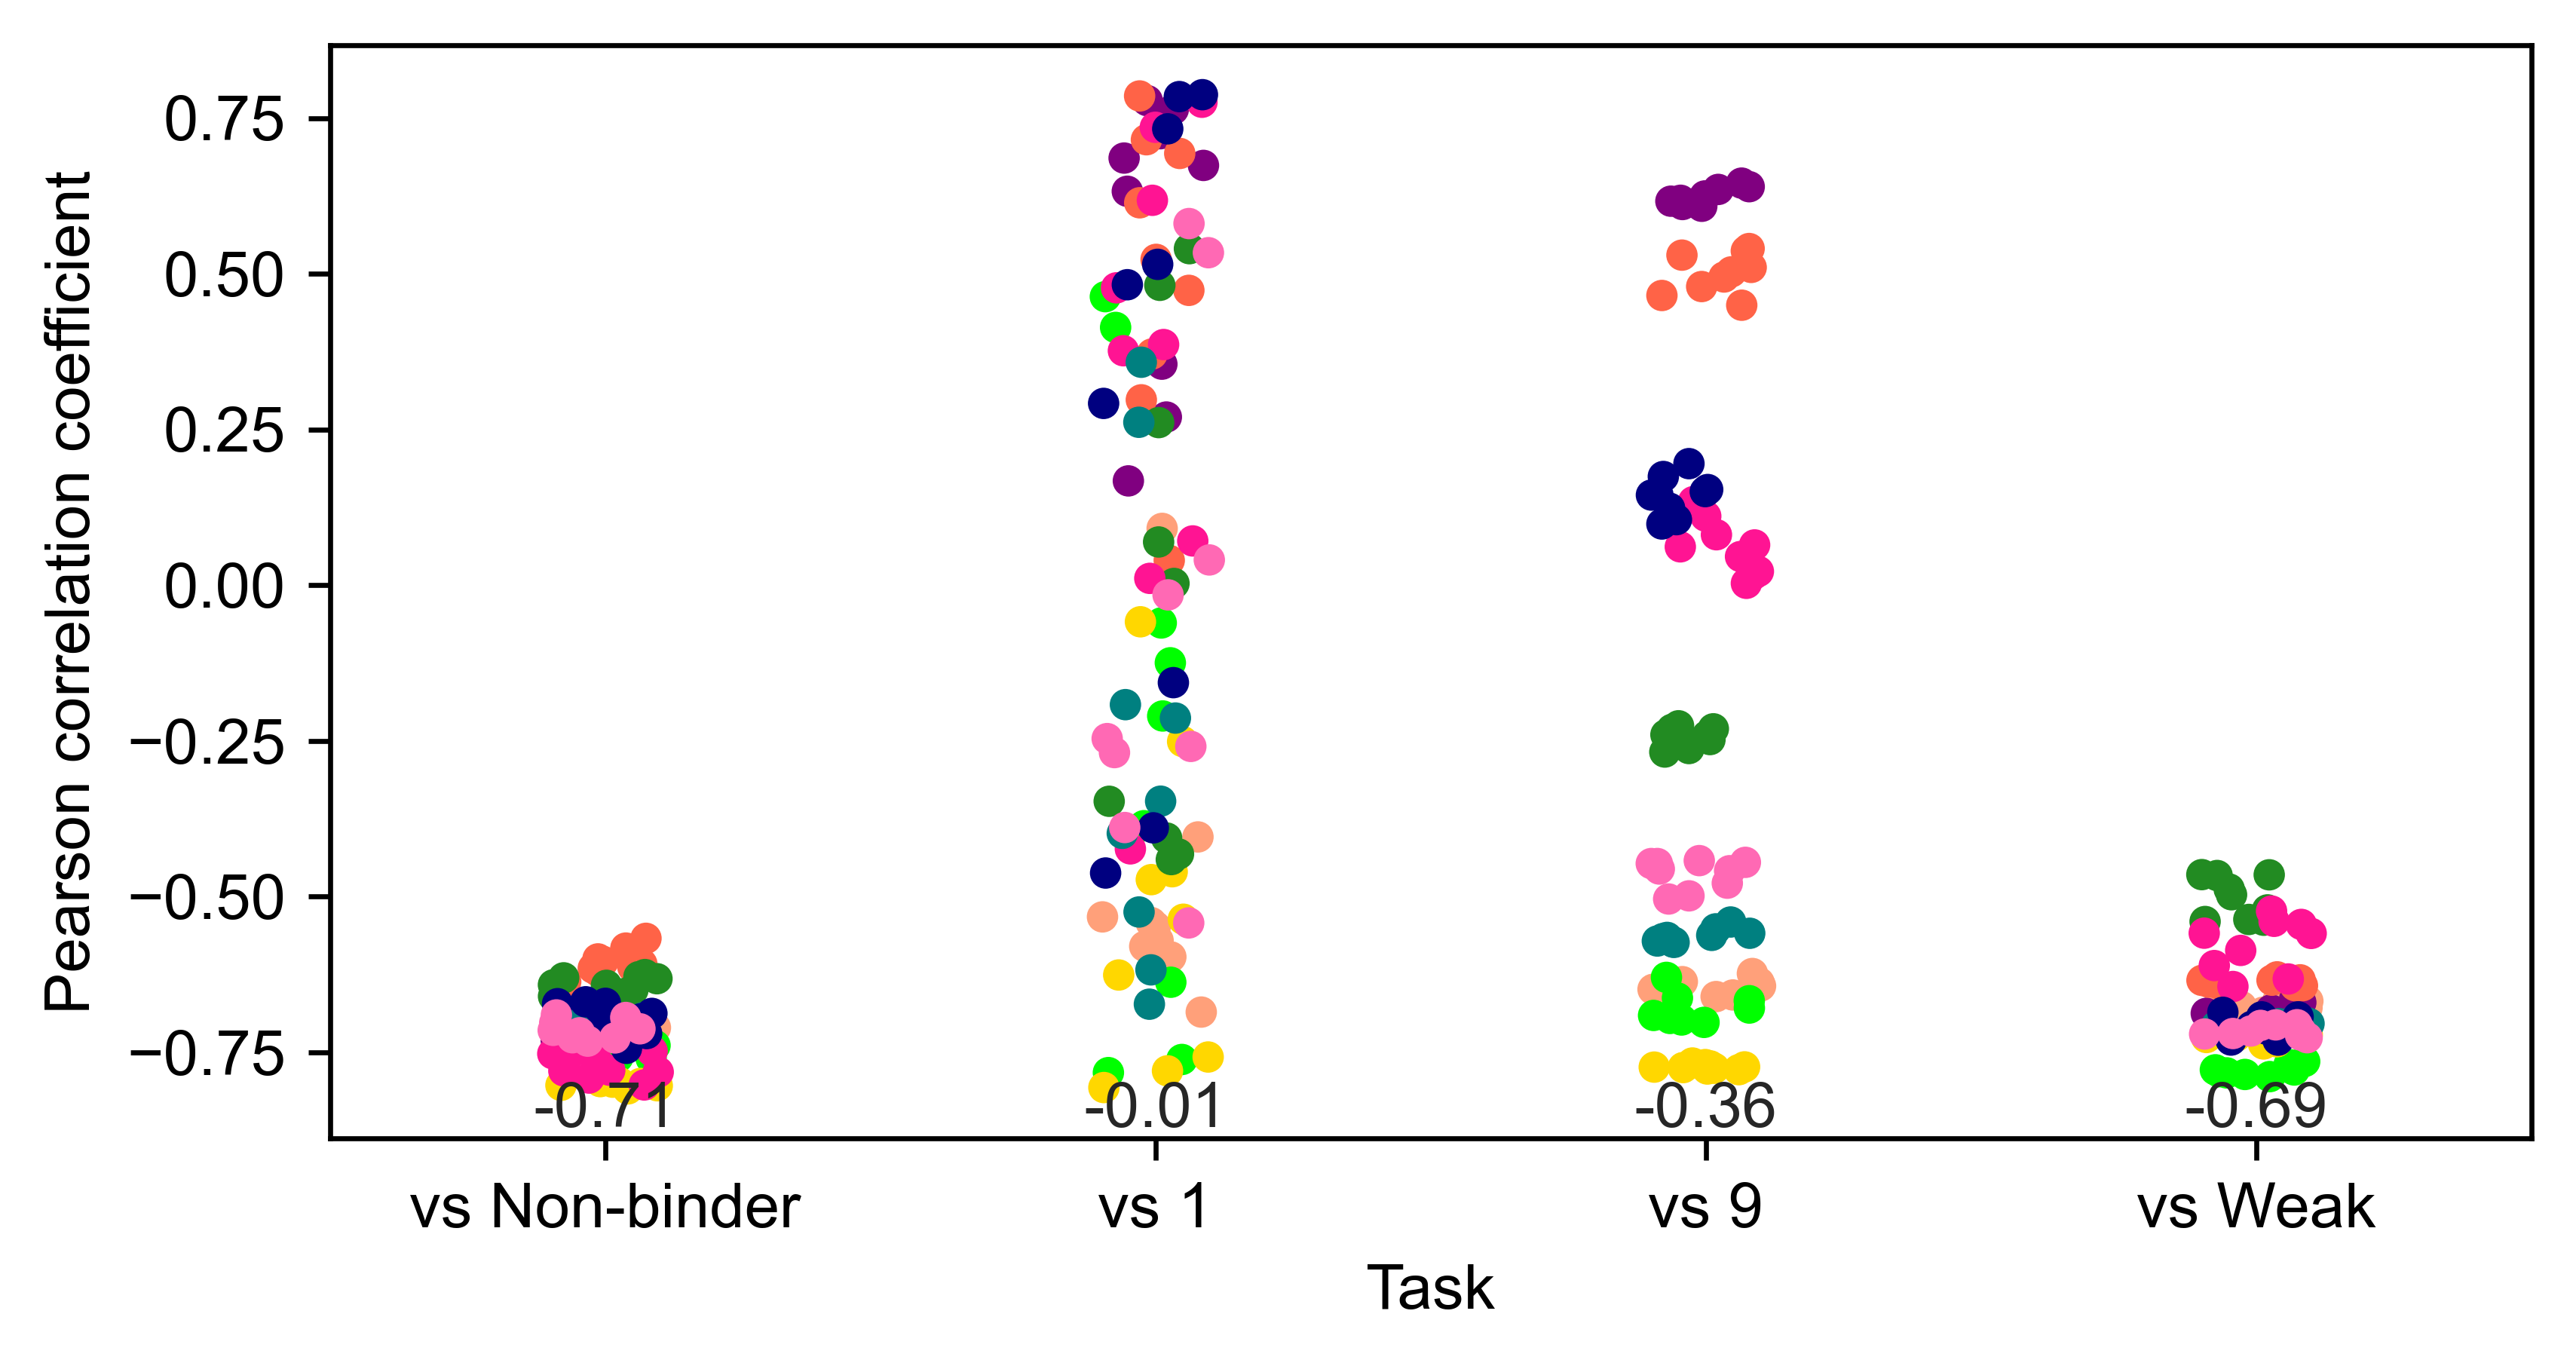

In [18]:
fig, ax = plt.subplots(figsize=(2*3.14, 3.14), dpi=600)
sns.set_style("white")
sns.set_style('ticks')

task_order = ["high_vs_95low", "1v1", "1v9", "high_vs_looser"]
sns.stripplot(
    data=df_attrib, 
    x="task_type", 
    y="mean_pos_total", 
    order=task_order,
    hue="ag_pos",
    ax=ax,
    palette=cmap_ag,
)

ax.legend_.remove()

# Relabel xticks
ax.set_xticklabels(map(lambda x: visualisations.PlotParams.map_task_type_to_clean[x], task_order))

# Add median r_pos per task
r_median_df = df_attrib.groupby(["task_type"]).agg({"mean_pos_total": "median"})
for i, row in r_median_df.iterrows():
    ax.text(
        i,
        -0.87,
        f"{row['mean_pos_total']:.2f}",
        # Center center
        horizontalalignment='center',
    )

# ax.set_title("Mean{Correlation(Energycontribution, Attribution)} for positive class")
ax.set_ylabel("Pearson correlation coefficient")
ax.set_xlabel("Task")
fig.savefig("figures/section2/fig2_r_attr_peraaeng.svg")

In [19]:
df_attrib[df_attrib['task_type'] != '1v1'].groupby(['task_type', 'ag_pos']).apply(lambda x: x.sort_values(by = 'mean_pos_total',ascending=False))["mean_pos_total"].to_csv('../data/df_fig2b_order.csv')

In [20]:
df_attrib[df_attrib['task_type'] != '1v1'].groupby(['task_type', 'ag_pos']).mean("mean_pos_total").sort_values(by='mean', ascending=False)

seed_id   split_id      mean       std  mean_pos  \
task_type      ag_pos                                                      
1v9            1NSN    0.666667  19.777778  0.617664  0.422728  0.617664   
               1H0D    0.666667  19.777778  0.475452  0.273602  0.475452   
               2YPV    0.666667  19.777778  0.143632  0.243555  0.143632   
               1ADQ    0.666667  19.777778  0.034103  0.384384  0.034103   
               1WEJ    0.666667  19.777778 -0.251007  0.341562 -0.251007   
               1OB1    0.666667  19.777778 -0.464684  0.163923 -0.464684   
high_vs_looser 1WEJ    0.666667  19.777778 -0.489510  0.298108 -0.508596   
1v9            1FBI    0.666667  19.777778 -0.562888  0.146399 -0.562888   
high_vs_95low  1WEJ    0.666667  19.777778 -0.589774  0.229278 -0.637010   
               1FBI    0.666667  19.777778 -0.598850  0.198129 -0.694822   
high_vs_looser 1ADQ    0.666667  19.777778 -0.610024  0.344722 -0.602744   
high_vs_95low  1OB1    0.666667  19.777778 -0.621055  0.170472 -0.703902   
high_vs_looser 1NSN    0.666667  19.777778 -0.622442  0.253094 -0.693508   
high_vs_95low  1H0D    0.666667  19.777778 -0.632458  0.201309 -0.622039   
               1NSN    0.666667  19.777778 -0.645309  0.198975 -0.725996   
high_vs_looser 1H0D    0.666667  19.777778 -0.657057  0.214211 -0.650758   
high_vs_95low  3VRL    0.666667  19.777778 -0.657272  0.163867 -0.715926   
high_vs_looser 3VRL    0.666667  19.777778 -0.658807  0.158225 -0.694655   
               1FBI    0.666667  19.777778 -0.661771  0.143576 -0.704512   
               1OB1    0.666667  19.777778 -0.666481  0.127296 -0.702390   
1v9            3VRL    0.666667  19.777778 -0.676422  0.126068 -0.676422   
               3RAJ    0.666667  19.777778 -0.682117  0.218555 -0.682117   
high_vs_looser 5E94    0.666667  19.777778 -0.696147  0.155366 -0.709011   
high_vs_95low  2YPV    0.666667  19.777778 -0.706236  0.194391 -0.693531   
high_vs_looser 2YPV    0.666667  19.777778 -0.726217  0.262334 -0.708604   
high_vs_95low  3RAJ    0.666667  19.777778 -0.730149  0.141275 -0.746543   
               1ADQ    0.666667  19.777778 -0.733631  0.164485 -0.776001   
               5E94    0.666667  19.777778 -0.736746  0.142064 -0.783700   
1v9            5E94    0.666667  19.777778 -0.765740  0.101400 -0.765740   
high_vs_looser 3RAJ    0.666667  19.777778 -0.767381  0.121994 -0.780548   

                        std_pos  mean_neg   std_neg  mean_fold  std_fold  \
task_type      ag_pos                                                      
1v9            1NSN    0.422728       NaN       NaN   0.050976  0.268679   
               1H0D    0.273602       NaN       NaN   0.154352  0.270758   
               2YPV    0.243555       NaN       NaN  -0.070119  0.290659   
               1ADQ    0.384384       NaN       NaN   0.097666  0.273639   
               1WEJ    0.341562       NaN       NaN   0.102777  0.204917   
               1OB1    0.163923       NaN       NaN   0.067243  0.209274   
high_vs_looser 1WEJ    0.286629 -0.470425  0.307781   0.160122  0.218492   
1v9            1FBI    0.146399       NaN       NaN        NaN       NaN   
high_vs_95low  1WEJ    0.209617 -0.542538  0.237685   0.135129  0.243744   
               1FBI    0.115648 -0.502877  0.215676  -0.045245  0.318666   
high_vs_looser 1ADQ    0.354801 -0.617304  0.333681  -0.091391  0.293967   
high_vs_95low  1OB1    0.110195 -0.538208  0.178843  -0.008149  0.259981   
high_vs_looser 1NSN    0.181473 -0.551377  0.291658   0.011784  0.301088   
high_vs_95low  1H0D    0.211179 -0.642877  0.189365  -0.165166  0.282413   
               1NSN    0.100385 -0.564623  0.236703  -0.112482  0.334855   
high_vs_looser 1H0D    0.219318 -0.663356  0.208704  -0.106596  0.286180   
high_vs_95low  3VRL    0.131860 -0.598617  0.171268  -0.099340  0.299614   
high_vs_looser 3VRL    0.137460 -0.622959  0.169102  -0.009126  0.250611   
               1FBI    0.117422 -0.619031  0.154200  -0.079495  0.28903

In [20]:
#section 2 zoom in plots
fp = "../data/fig_2/attribution_records.json"
fp_test_1 = "../data/fig_2/high_test_5000.tsv"
fp_test_2 = "../data/fig_2/looserX_test_5000.tsv"

df_test_1 = pd.read_csv(fp_test_1, sep="\t")
df_test_1["class"] = "positive"
df_test_2 = pd.read_csv(fp_test_2, sep="\t")
df_test_2["class"] = "negative"
df_test = pd.concat([df_test_1, df_test_2], axis=0)

with open(fp, "r") as f:
    data = json.load(f)

df = pd.DataFrame.from_records(data)
df = pd.merge(df, df_test, left_on="slide", right_on="Slide")

/var/folders/ww/bptfq9n12_jbyy78qcjp7s4c0000gn/T/ipykernel_1973/2004161624.py:11: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.histplot(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


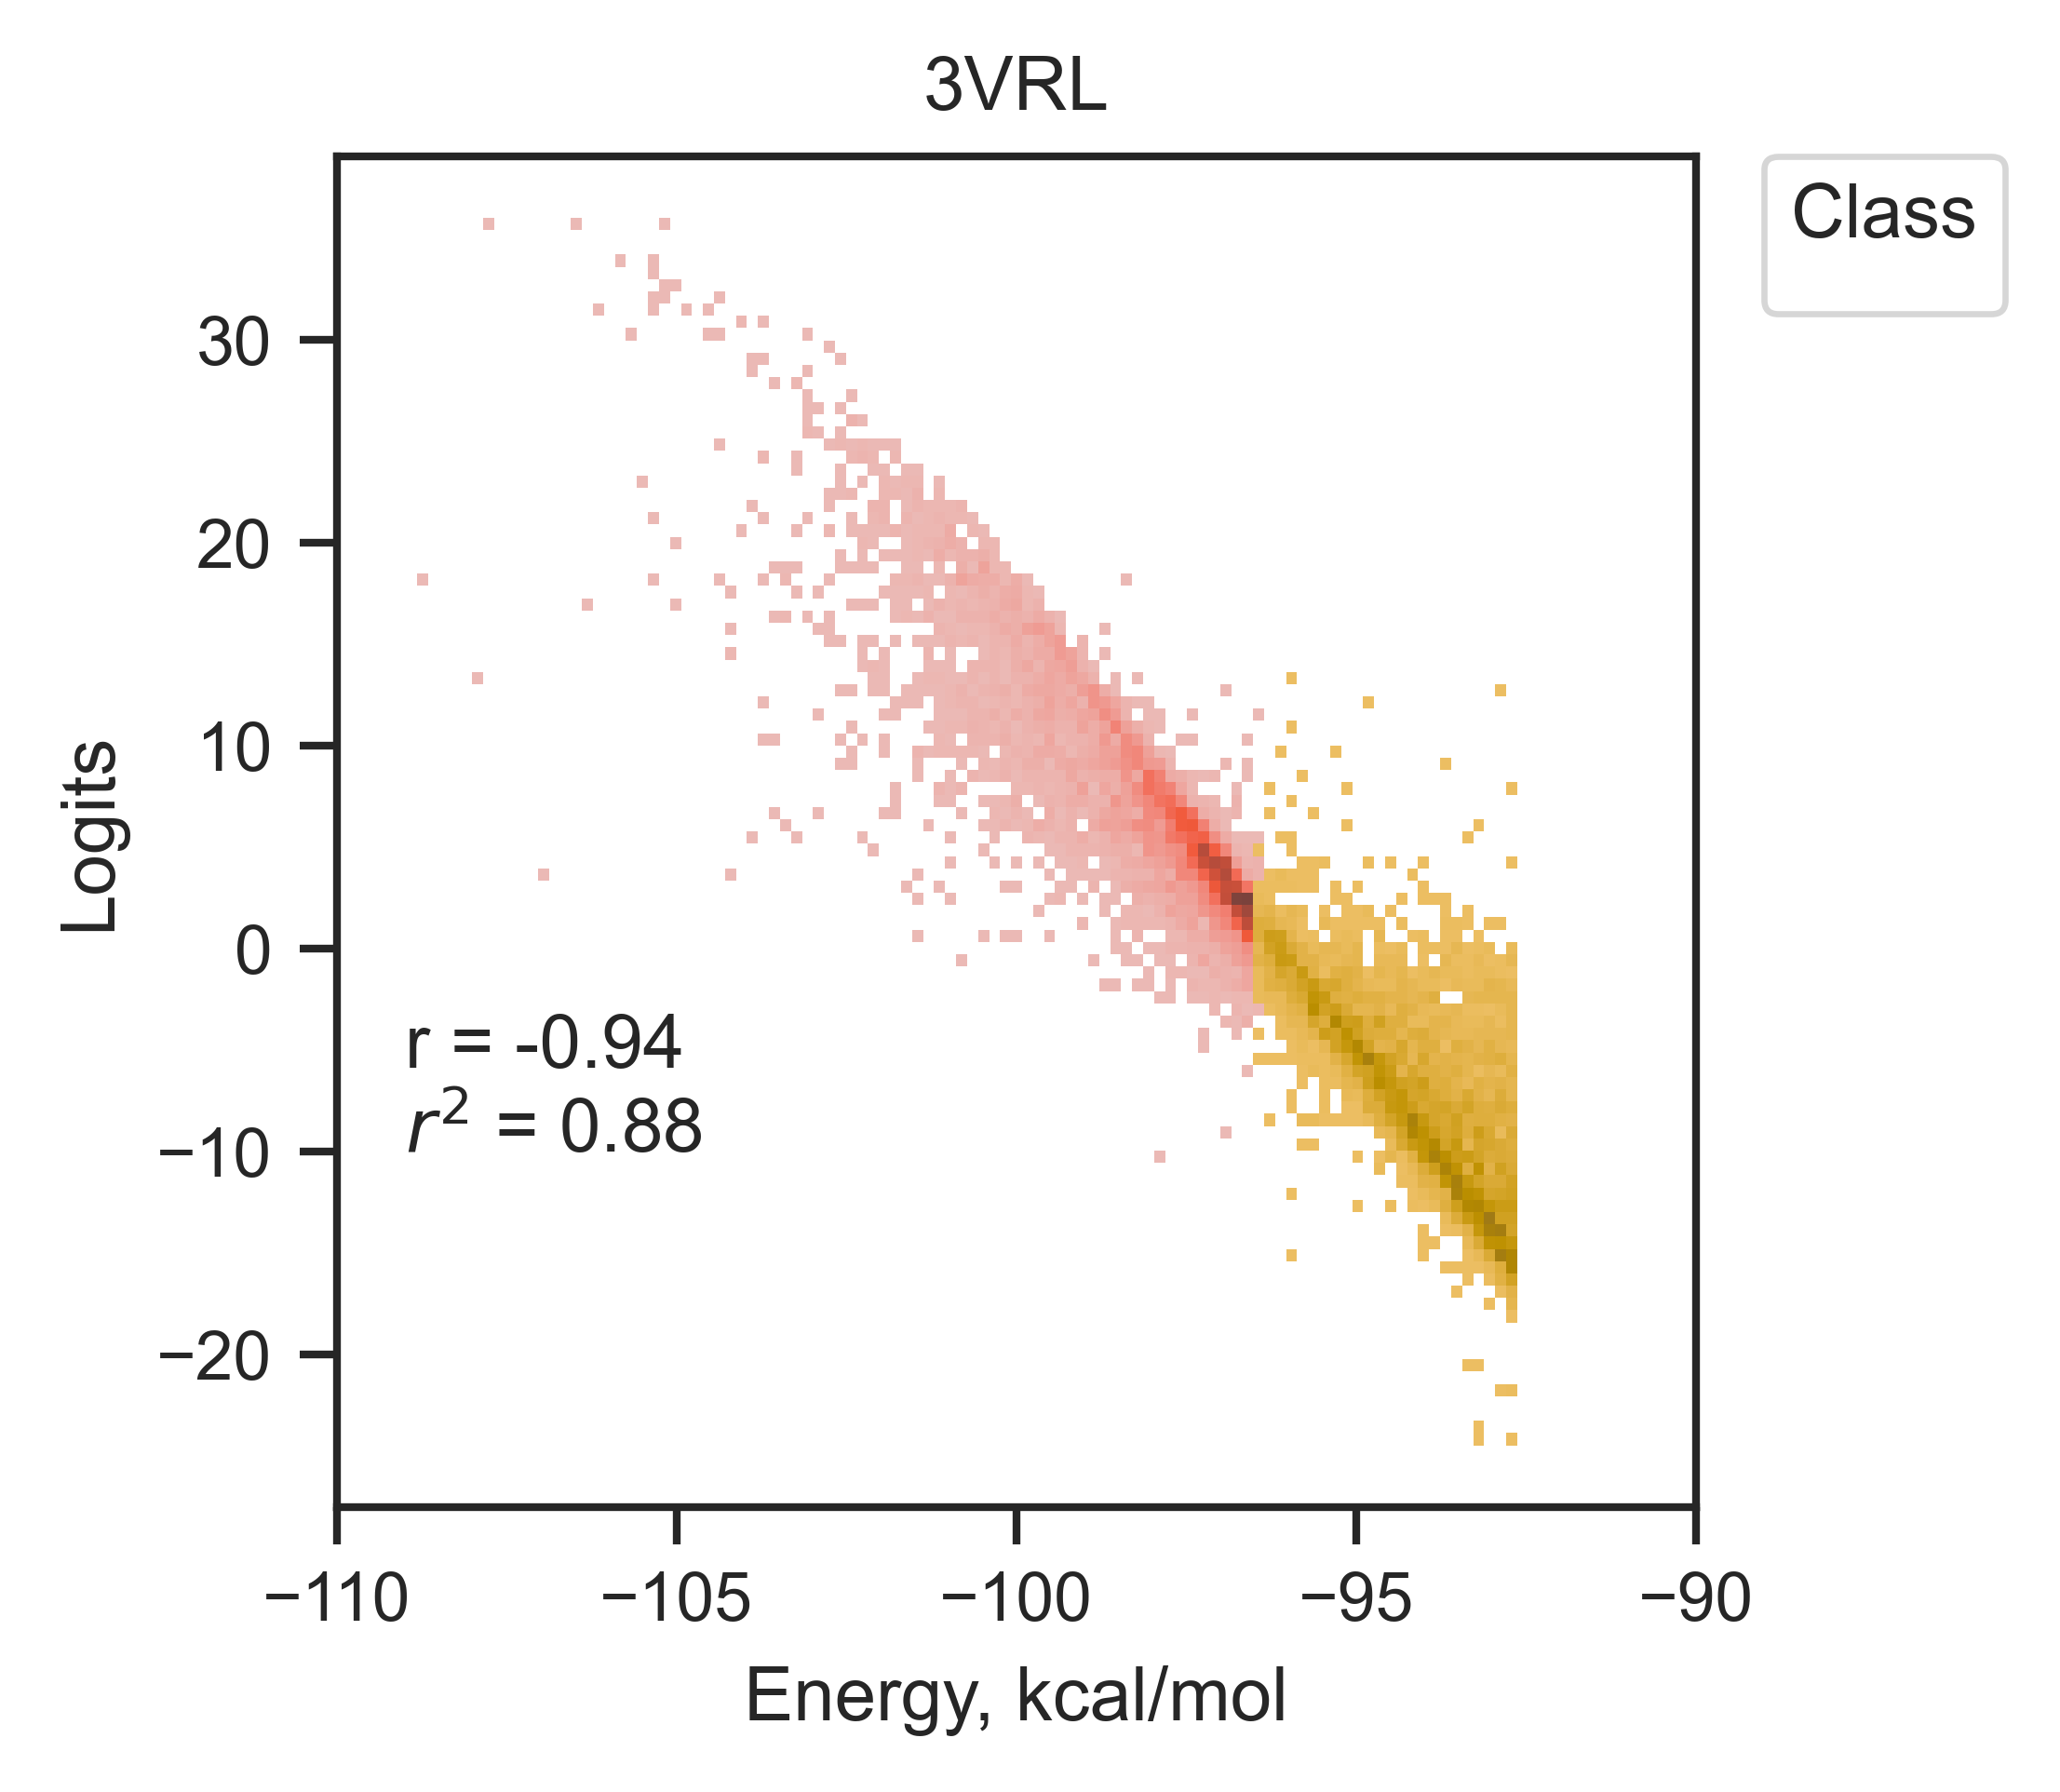

In [202]:
fig, ax = plt.subplots(figsize=(3.14, 3.14), dpi=600)
sns.set_style("white")
sns.set_style('ticks')

cmap = [
    "#f1593a", # red
    "#ffc40d", # yellow
    "#28a3dc", # blue
]

sns.histplot(
    data=df,
    x="Energy",
    y="logits",
    hue="class",
    ax=ax,
    palette=cmap,
    bins=100
)#scatterplot


# Add legend with legend title
handles, labels = ax.get_legend_handles_labels()
ax.legend(
    handles=handles,
    labels=["Binder", "Weak binder"],
    title="Class",
    loc="upper left",
    bbox_to_anchor=(1.05, 1),
    borderaxespad=0,
)

ax.set_xlabel("Energy, kcal/mol")
ax.set_ylabel("Logits")
ax.set_title("3VRL")
ax.set_xticks(np.arange(-110, -89, 5))

# Add a coefficient of correlation and coeficient of determination
r, p = pearsonr(df["Energy"], df["logits"])
r2 = r ** 2
ax.text(
    -109,
    -10,
    f"r = {r:.2f}\n$r^2$ = {r2:.2f}",
    bbox=dict(facecolor="white", alpha=0.5),
)
fig.savefig("figures/section2/fig2_r_logits_energy_3VRL.svg")

In [ ]:
#let's plot this correlation for all ag 'vs Non-binder' and 'vs Weak' task

/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


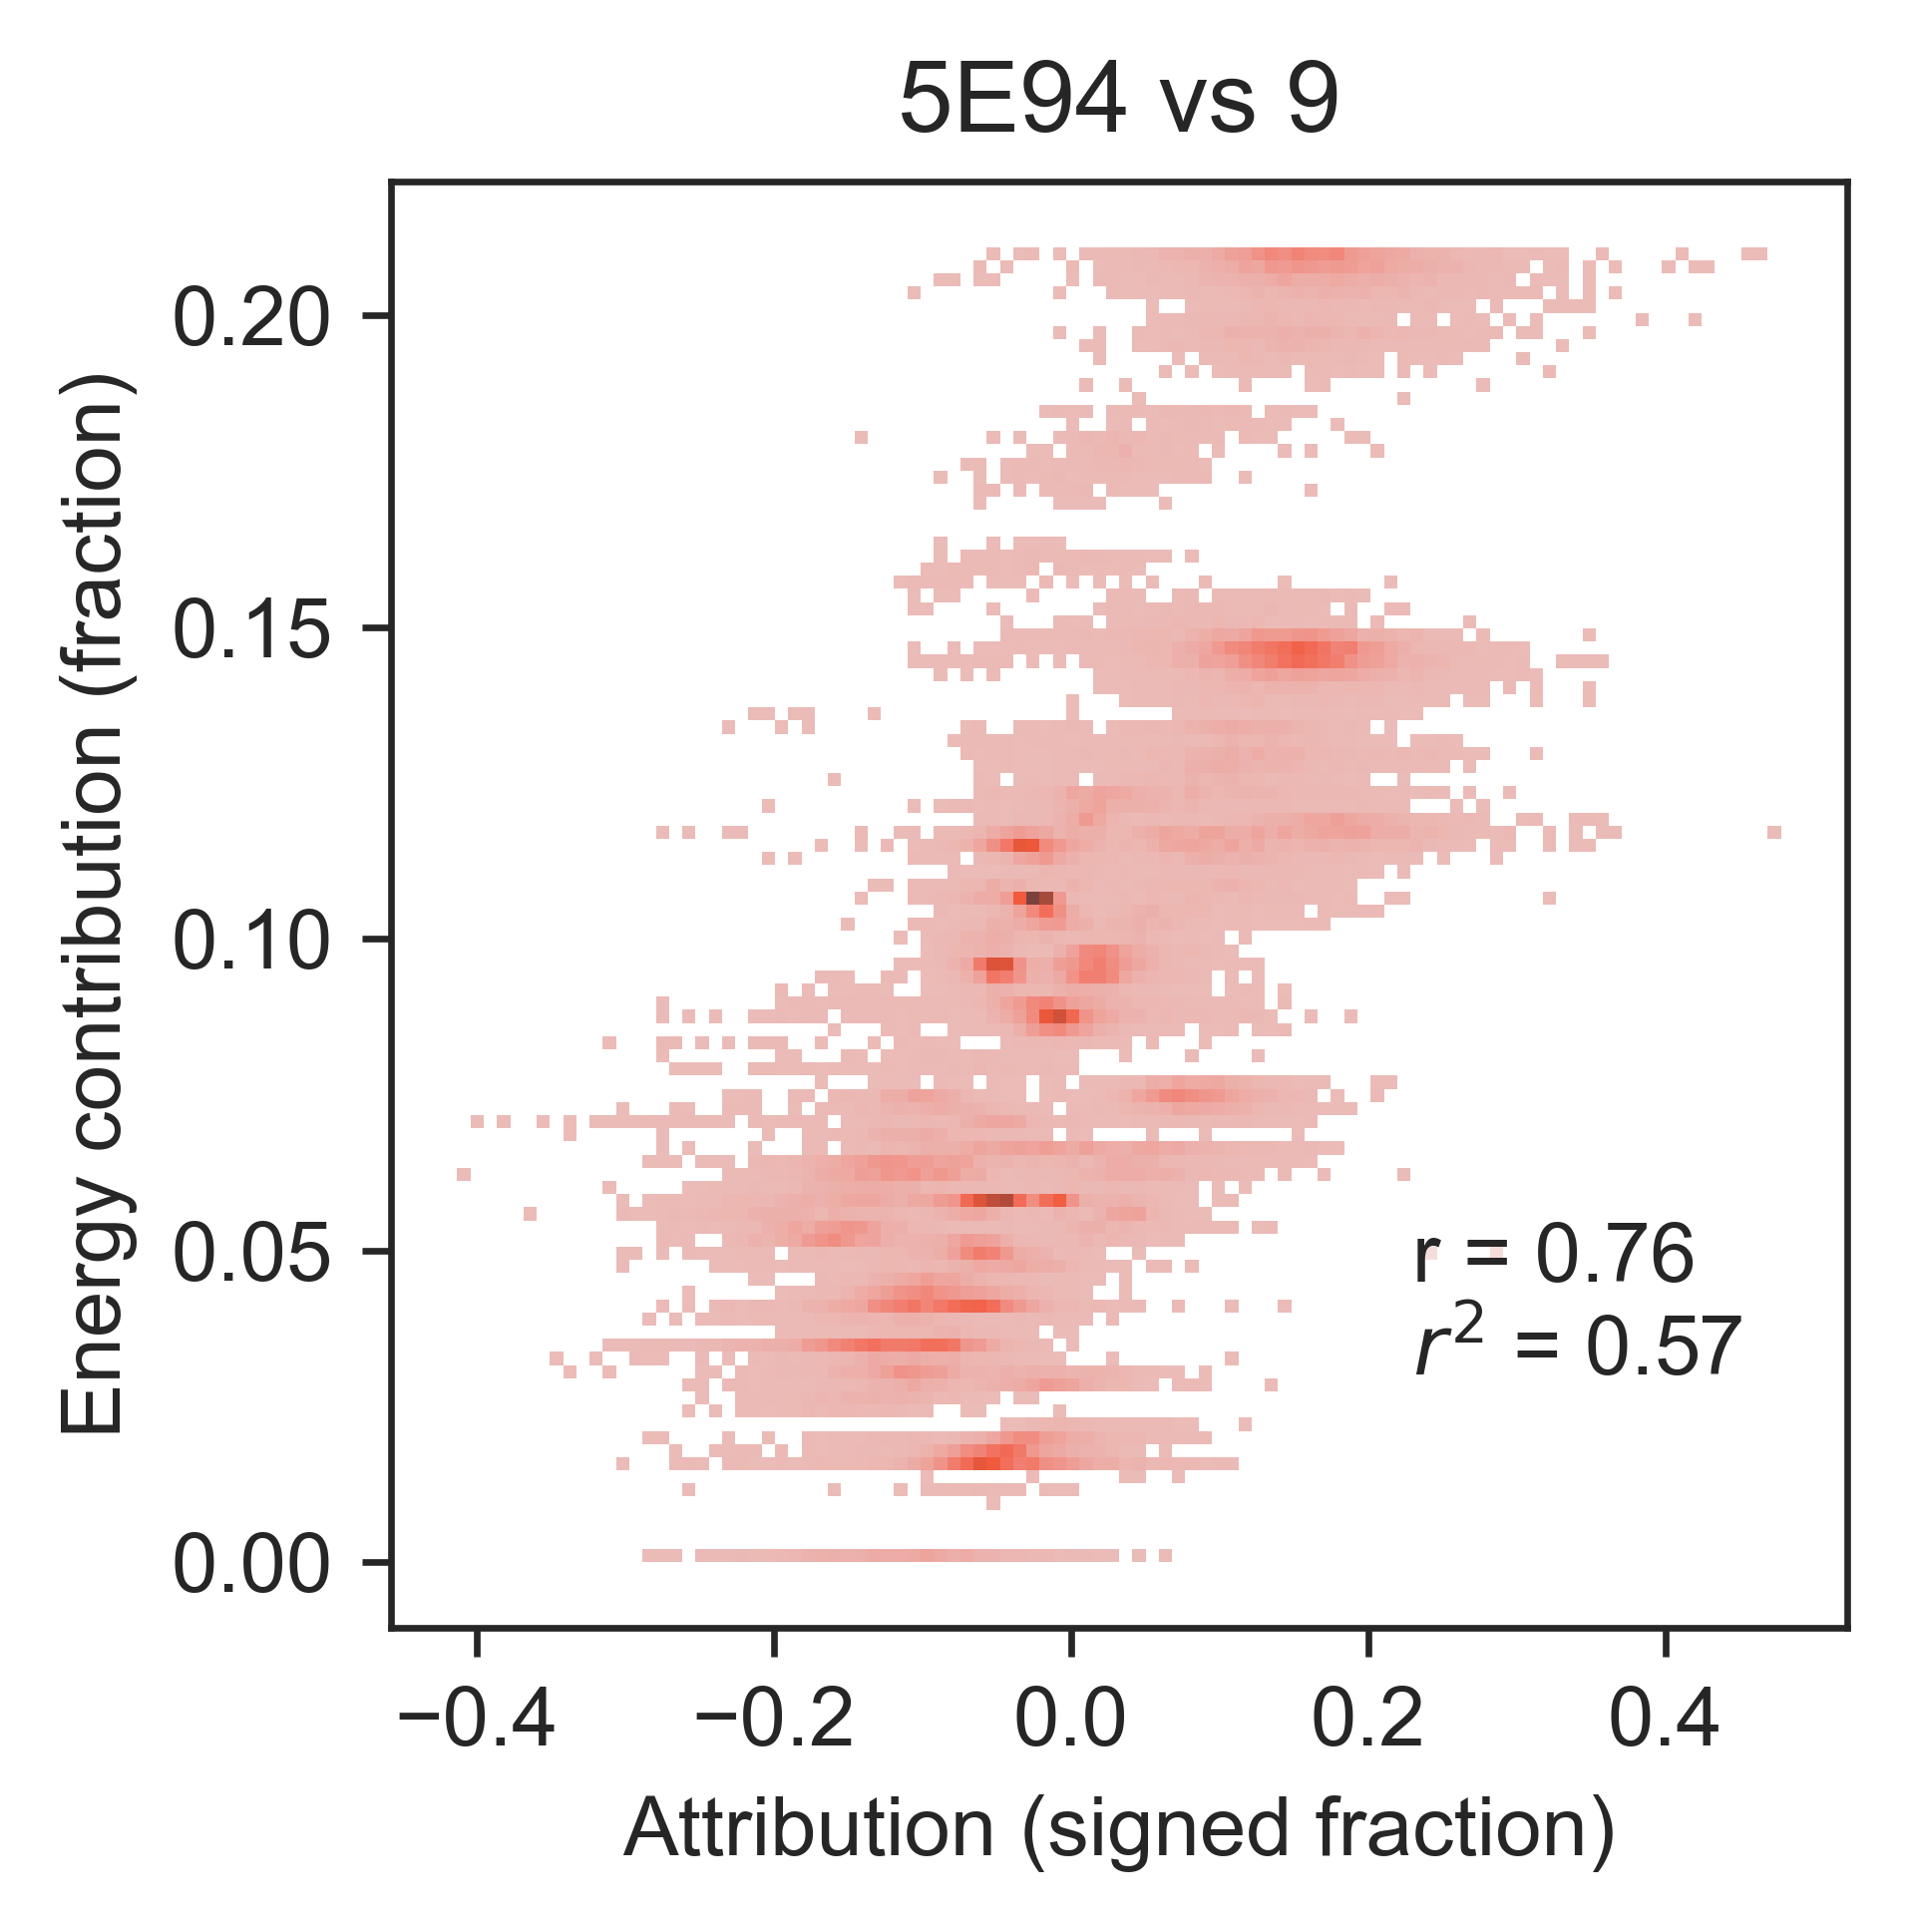

In [25]:
#trial
task_type = datasets.ClassificationTaskType.ONE_VS_NINE
ag_1 = '5E94'
split_id = 4
seed_id = 0
task = datasets.ClassificationTask(
                    task_type=task_type,
                    ag_pos=ag_1,
                    ag_neg="auto",
                    seed_id=seed_id,
                    split_id=split_id,
                )


fig, ax = plt.subplots(figsize=(3.14, 3.14), dpi=600)
cmap = ["#f1593a"]  # red

sns.set_style("white")
sns.set_style('ticks')

plot_energy_contributions_per_task(task, plot_hist=True, ax=ax)
ax.set_title("5E94 vs 9")
ax.set_ylabel("Energy contribution (fraction)")
ax.set_xlabel("Attribution (signed fraction)")
#save
fig.savefig('./figures/energy_attr_5E94.svg')

/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


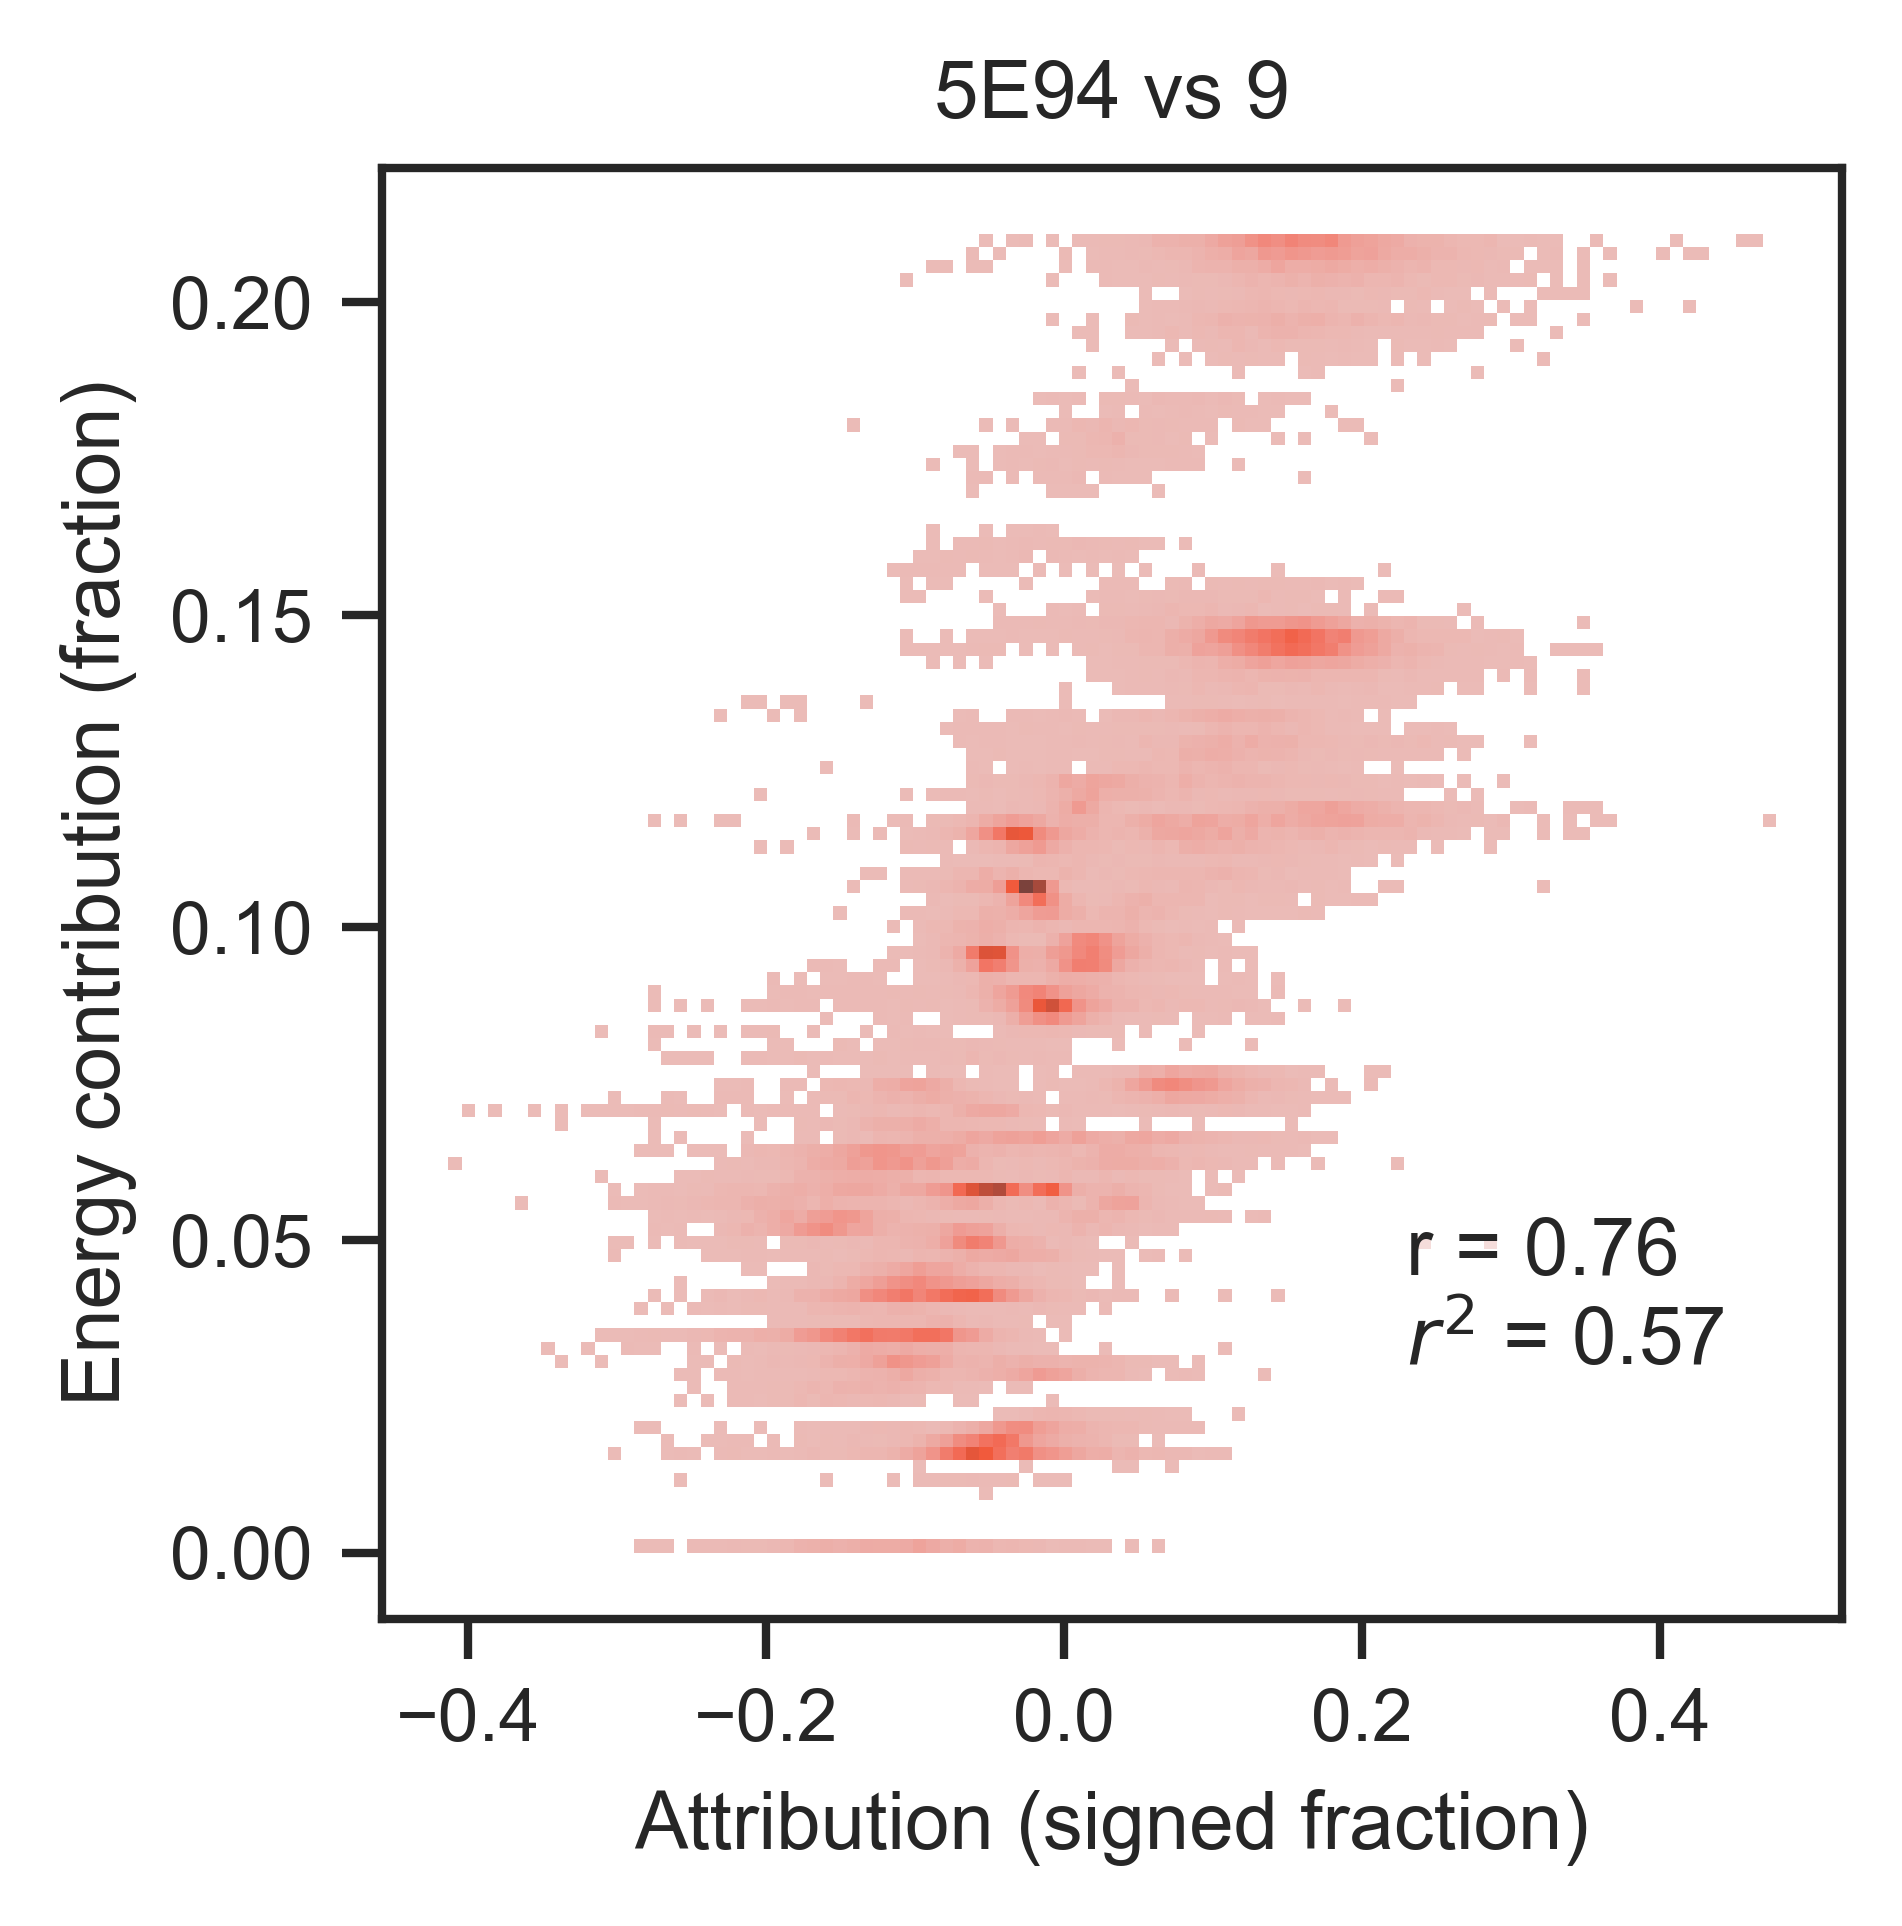

In [280]:
#trial
task_type = datasets.ClassificationTaskType.ONE_VS_NINE
ag_1 = '5E94'
split_id = 4
seed_id = 0
task = datasets.ClassificationTask(
                    task_type=task_type,
                    ag_pos=ag_1,
                    ag_neg="auto",
                    seed_id=seed_id,
                    split_id=split_id,
                )


fig, ax = plt.subplots(figsize=(3.14, 3.14), dpi=600)
cmap = ["#f1593a"]  # red

sns.set_style("white")
sns.set_style('ticks')

plot_energy_contributions_per_task(task, plot_hist=True, ax=ax)
ax.set_title("5E94 vs 9")
ax.set_ylabel("Energy contribution (fraction)")
ax.set_xlabel("Attribution (signed fraction)")
#save
fig.savefig('./figures/energy_attr_5E94.svg')

In [ ]:
#trial
task_type = datasets.ClassificationTaskType.ONE_VS_NINE
ag_1 = '5E94'
split_id = 4
seed_id = 0
task = datasets.ClassificationTask(
                    task_type=task_type,
                    ag_pos=ag_1,
                    ag_neg="auto",
                    seed_id=seed_id,
                    split_id=split_id,
                )


fig, ax = plt.subplots(figsize=(3.14, 3.14), dpi=600)
cmap = ["#f1593a"]  # red

sns.set_style("white")
sns.set_style('ticks')

plot_energy_contributions_per_task(task, plot_hist=True, ax=ax)
ax.set_title("5E94 vs 9")
ax.set_ylabel("Energy contribution (fraction)")
ax.set_xlabel("Attribution (signed fraction)")
#save
fig.savefig('./figures/energy_attr_5E94.svg')

In [283]:
df_test

slide     class  \
0     CHLLWSSWFAY  positive   
1     CAILYGNLYAM  positive   
2     GWILFSYFDYW  positive   
3     CAFYYAWYFDV  positive   
4     ARFYYDYFLAY  positive   
...           ...       ...   
4994  SLLLRCYYFDY  positive   
4995  ATLWLGWYFDV  positive   
4996  ATLYSNYFFAW  positive   
4997  DFIYYGYFFYY  positive   
4998  VRLLLRLYAMD  positive   

                                               energies  \
0     [-9.4, -3.58, -20.32, -14.1, -6.14, -1.67, -5....   
1     [-9.4, -4.04, -19.13, -14.1, -5.67, -1.82, -5....   
2     [-6.28, -5.18, -19.13, -14.1, -7.28, -1.67, -8...   
3     [-9.4, -4.04, -20.2, -10.41, -5.67, -2.01, -9....   
4     [-6.18, -4.03, -11.48, -11.22, -8.45, -1.63, -...   
...                                                 ...   
4994  [-6.13, -6.48, -20.32, -14.1, -4.03, -2.86, -8...   
4995  [-7.22, -3.46, -20.32, -11.16, -7.37, -1.82, -...   
4996  [-7.22, -3.46, -20.32, -10.41, -3.92, -1.58, -...   
4997  [-5.8, -6.29, -19.13, -10.41, -5.67, -1.82, -8...   
4998  [-9.87, -3.07, -20.32, -14.1, -7.37, -1.62, -1...   

                                           attributions         r         p  \
0     [0.5049152374267578, -2.404974937438965, 4.078... -0.697322  0.017069   
1     [1.2265090942382812, -1.5519341230392456, 3.84... -0.850101  0.000917   
2     [-2.8769991397857666, 0.28921300172805786, 2.8... -0.704698  0.015458   
3     [0.4161927103996277, -1.4965746402740479, 5.16... -0.773255  0.005249   
4     [-2.734287977218628, -4.102040767669678, 5.902... -0.867121  0.000547   
...                                                 ...       ...       ...   
4994  [-1.262751817703247, -0.41039901971817017, 1.6... -0.666278  0.025187   
4995  [-2.4892191886901855, -2.4991395473480225, 4.1... -0.665627  0.025382   
4996  [-2.7680442333221436, -2.711899518966675, 5.44... -0.839857  0.001216   
4997  [-3.37528920173645, -1.035689115524292, 1.1517... -0.496066  0.120684   
4998  [1.181017279624939, -2.987217426300049, 6.2840... -0.857963  0.000729   

        r_fold    p_fold   r_total   p_total  
0     0.195730  0.564090 -0.687119  0.019492  
1     0.205512  0.544366 -0.853605  0.000829  
2    -0.155422  0.648160 -0.784537  0.004246  
3     0.141494  0.678153 -0.790720  0.003760  
4     0.162765  0.632530 -0.879514  0.000359  
...        ...       ...       ...       ...  
4994  0.398762  0.224437 -0.576899  0.063157  
4995  0.026710  0.937866 -0.693484  0.017954  
4996  0.461588  0.152955 -0.820339  0.001981  
4997  0.130607  0.701893 -0.448348  0.166644  
4998  0.036412  0.915356 -0.893603  0.000209  

[4999 rows x 10 columns]

/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


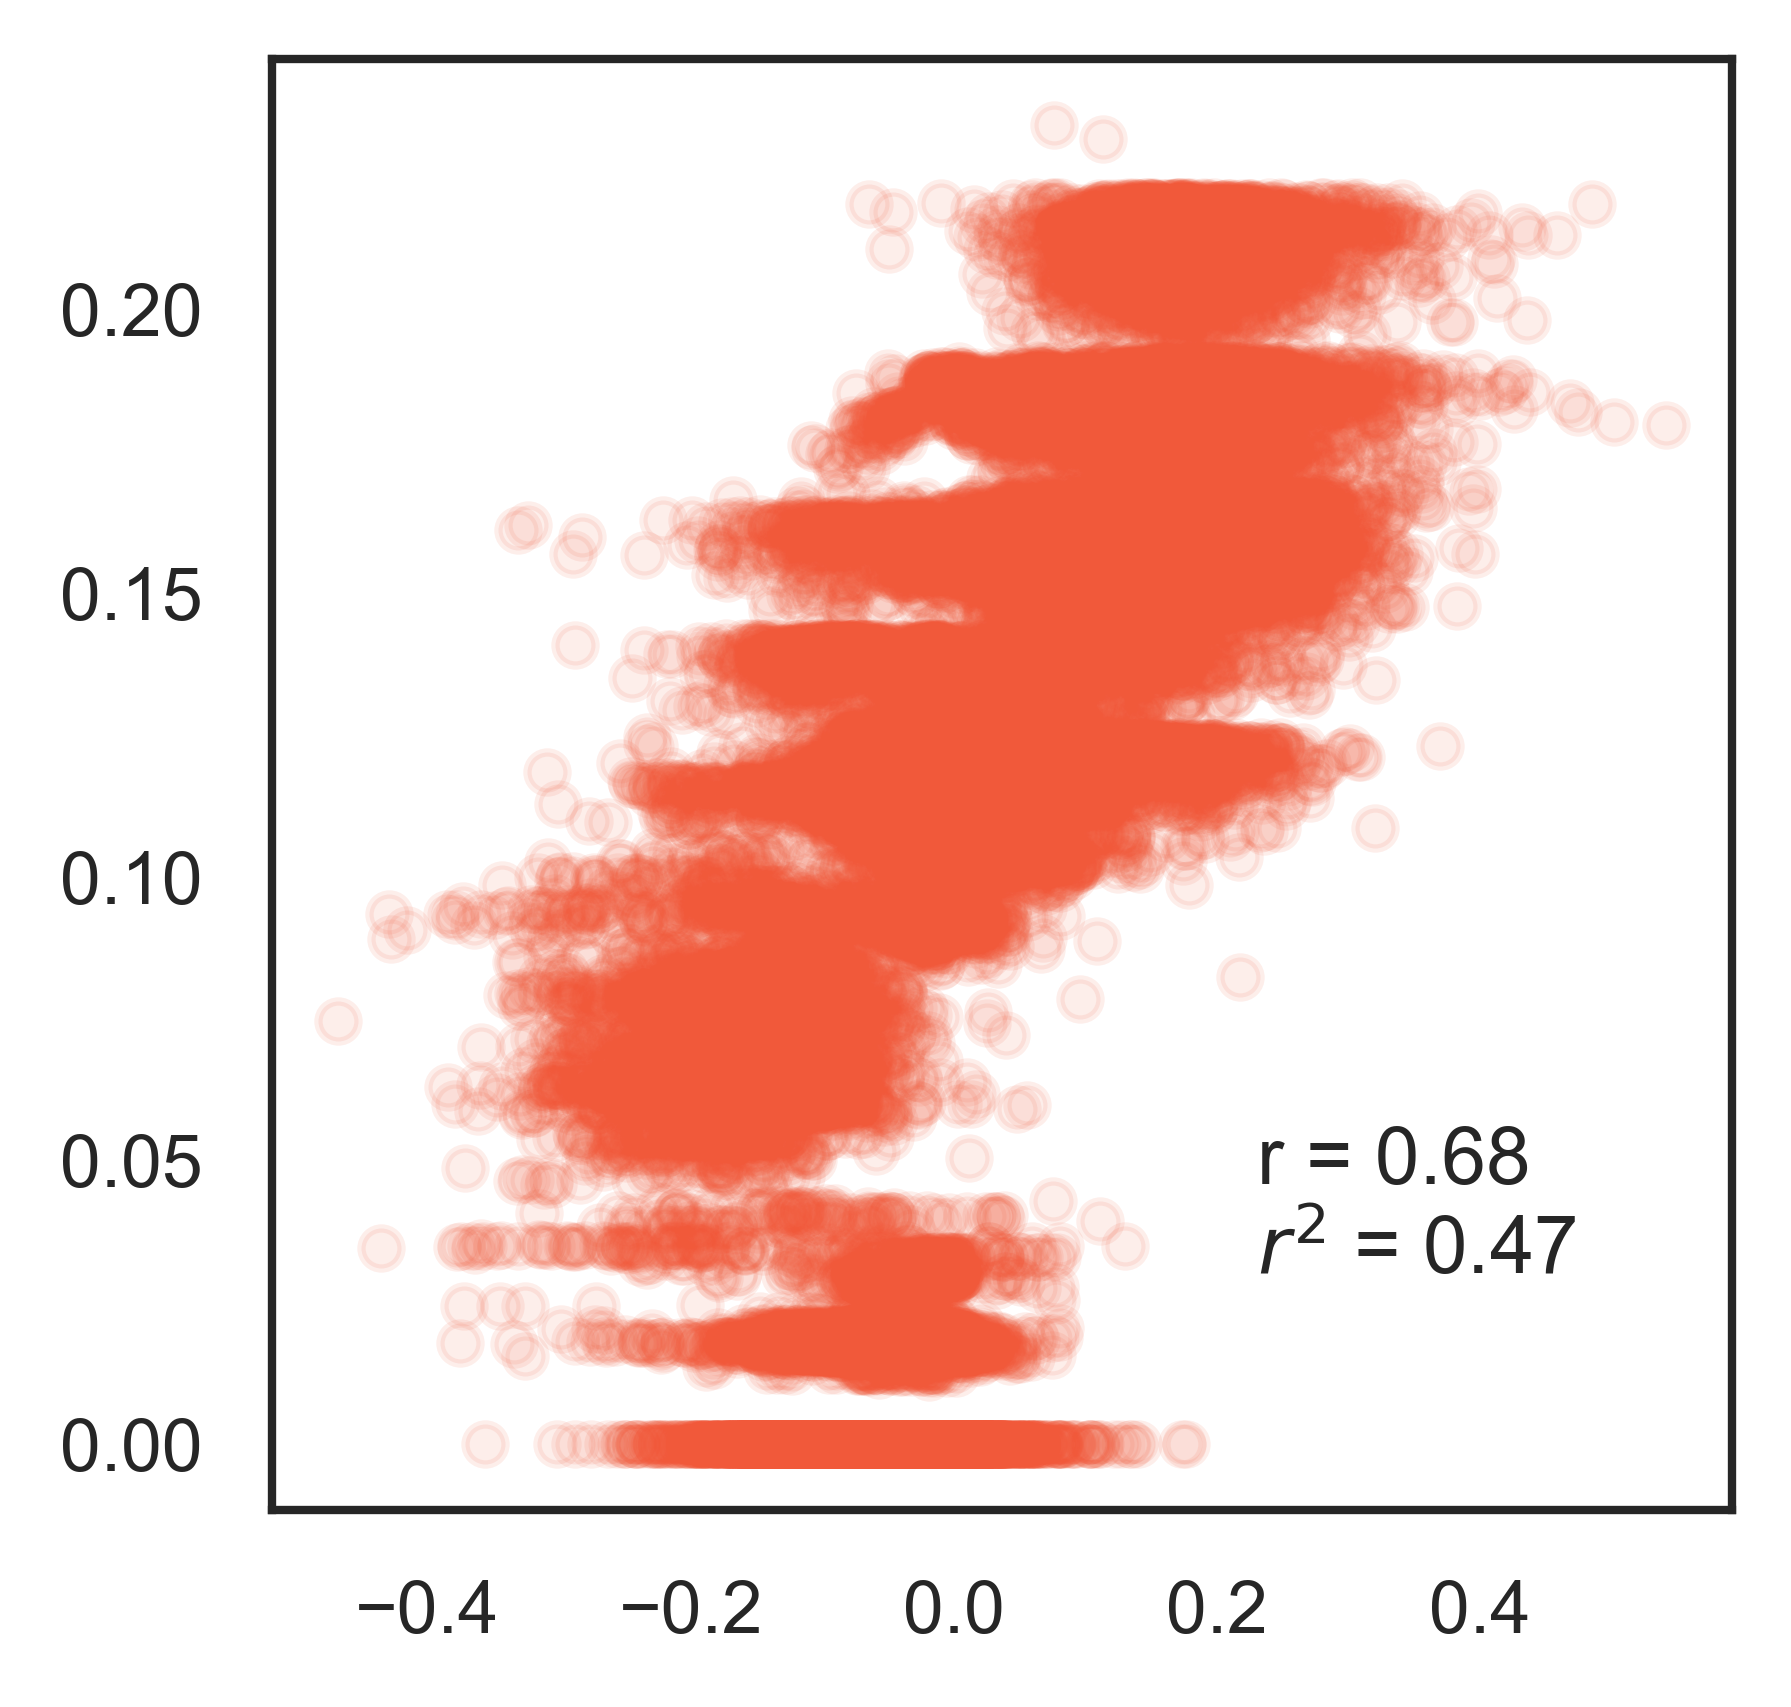

In [238]:
task_type = datasets.ClassificationTaskType.HIGH_VS_LOOSER
ag_1 = '1OB1'
split_id = 4
seed_id = 0
task = datasets.ClassificationTask(
                    task_type=task_type,
                    ag_pos=ag_1,
                    ag_neg="auto",
                    seed_id=seed_id,
                    split_id=split_id,
                )

fig, ax = plt.subplots(figsize=(3.14, 3.14), dpi=600)
sns.set_theme(context="paper")
sns.set_style("white")

cmap = ["#f1593a"]  # red

plot_energy_contributions_per_task(task, plot_perc=True, ax=ax)


/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


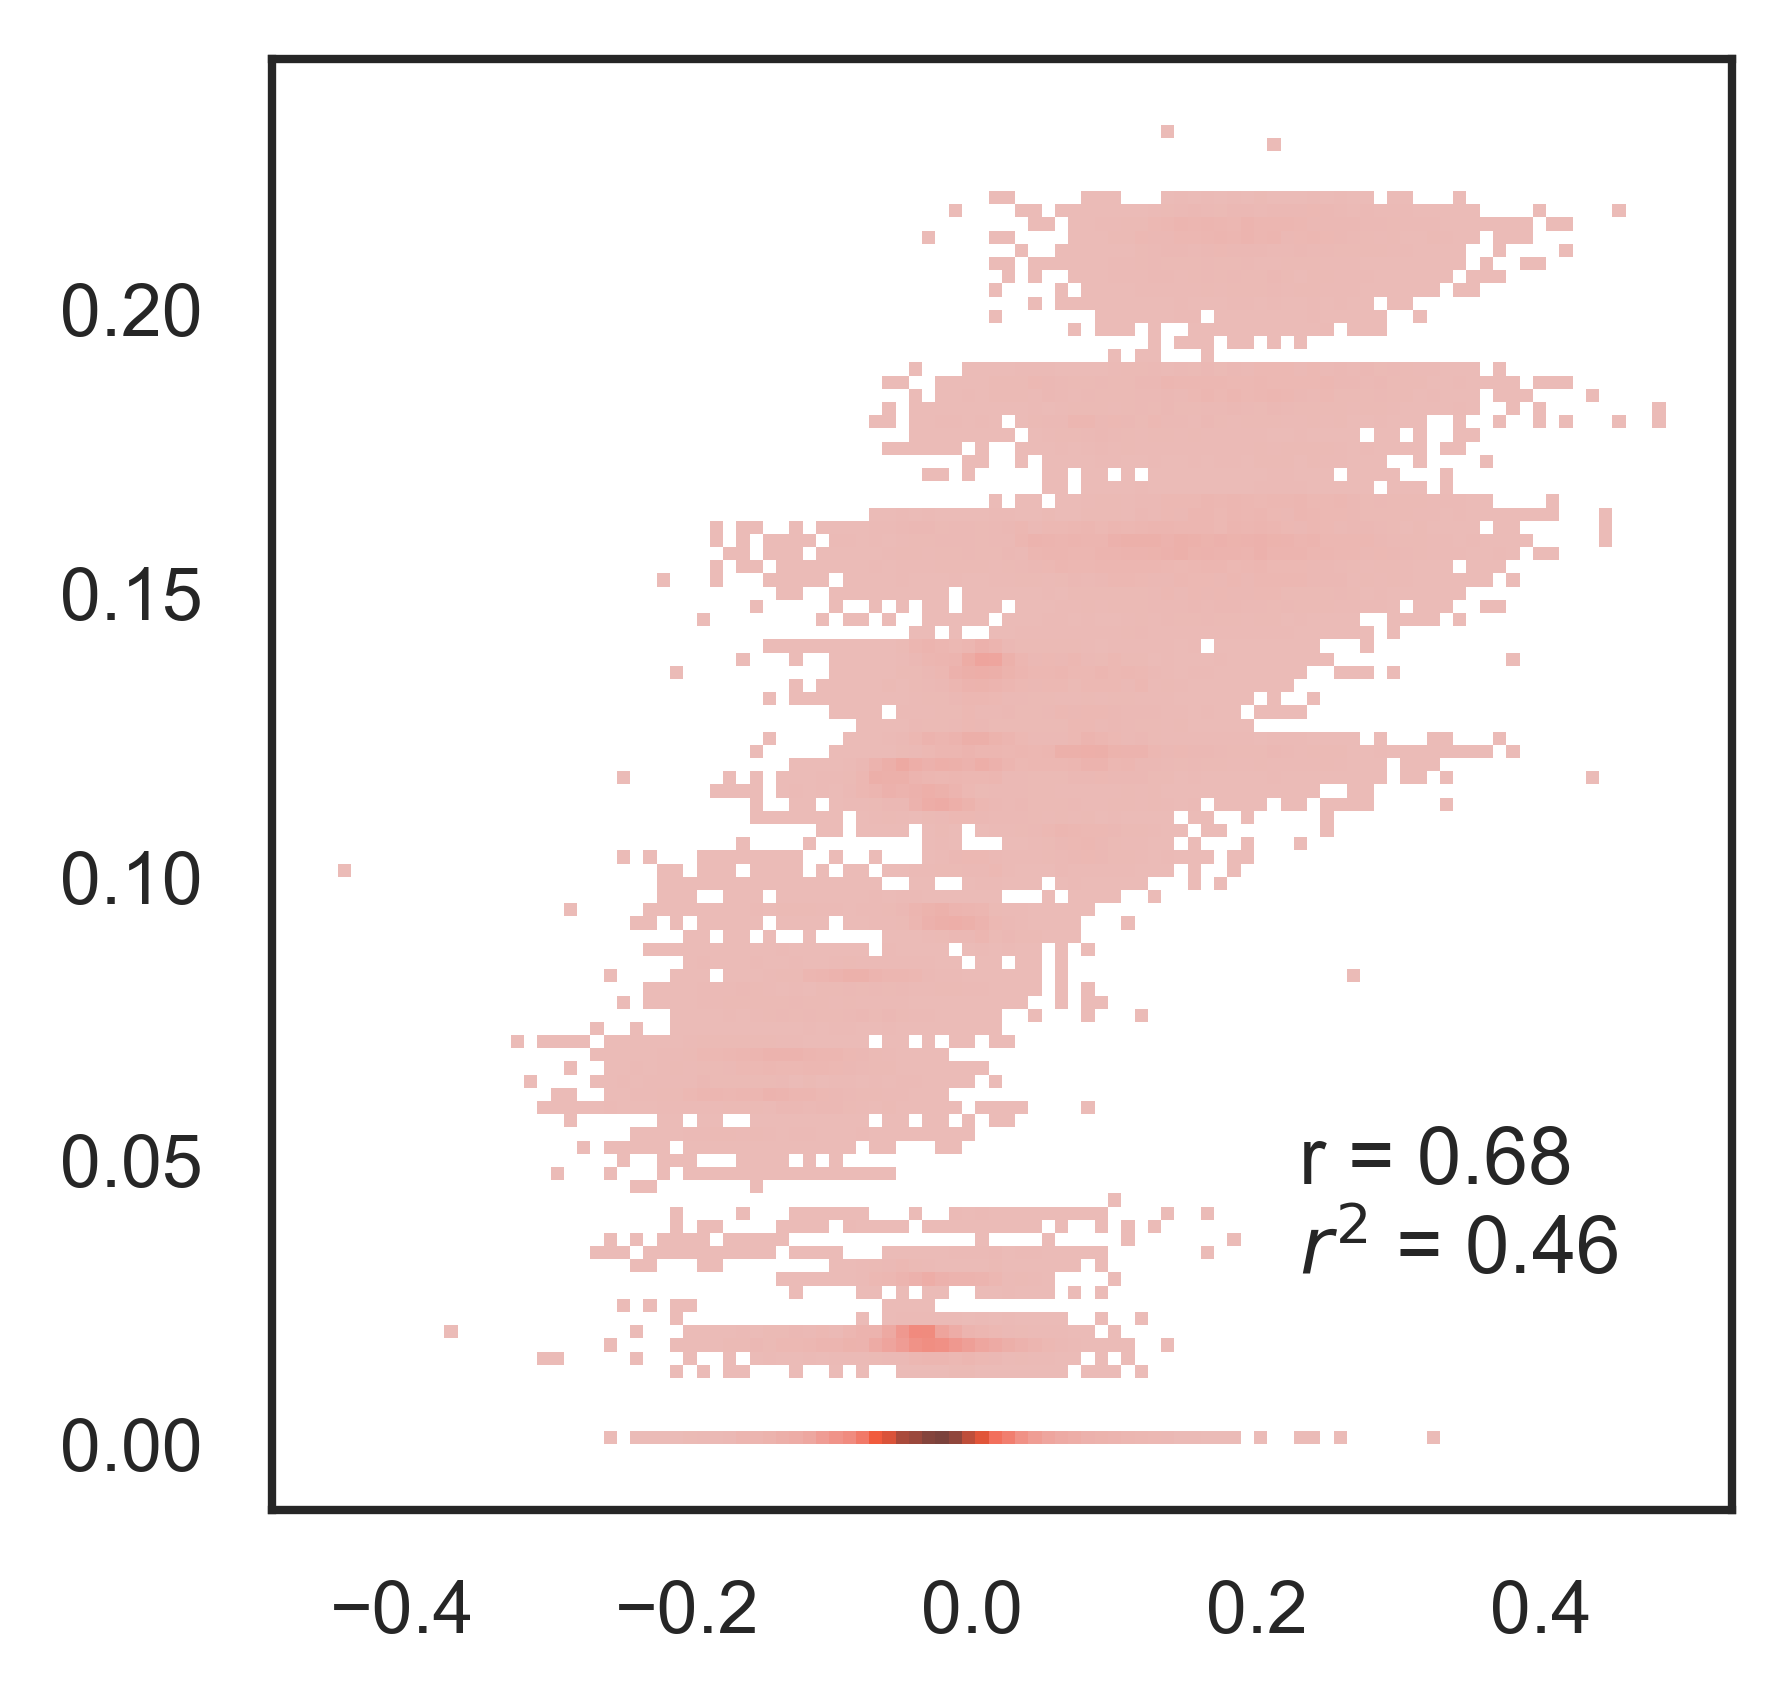

In [230]:
#trial
task_type = datasets.ClassificationTaskType.HIGH_VS_95LOW
ag_1 = '1OB1'
split_id = 4
seed_id = 0
task = datasets.ClassificationTask(
                    task_type=task_type,
                    ag_pos=ag_1,
                    ag_neg="auto",
                    seed_id=seed_id,
                    split_id=split_id,
                )

fig, ax = plt.subplots(figsize=(3.14, 3.14), dpi=600)
sns.set_theme(context="paper")
sns.set_style("white")

cmap = ["#f1593a"]  # red

plot_energy_contributions_per_task(task, plot_perc=True, ax=ax)


In [26]:
df_3VRL_eng.columns

Index(['ID_slide_Variant', 'CDR3', 'Best', 'Slide', 'Energy', 'Structure',
       'interactionCode', 'AGboundPositions', 'hotspot_ID', 'seqAGEpitope',
       'seqABParatope', 'motifAGEpitope', 'motifABParatope',
       'agregatesAGEpitope', 'agregatesABParatope', 'chemicalAGEpitope',
       'chemicalABParatope', 'motifsSizeGapsLigand', 'motifsSizeGapsRec',
       'interMaskAGEpitope', 'interMaskABParatope', 'segmentedAGEpitope',
       'segmentedABParatope', 'AAcompoFullSlice', 'AAcompoFullCDR', 'sizeCDR3',
       'InterCodeInternal', 'contribPerAAepi', 'contribPerAAparaBind',
       'contribPerAAparaFold', 'class'],
      dtype='object')

In [ ]:
#fp = "../data/Frozen_MiniAbsolut_ML/high_vs_looser/seed_0/split_2/3VRL_high__vs__3VRL_looser/attributions/v2.0-2/attribution_records.json"


In [ ]:
#this is for suppl figure 2

In [24]:
#join with performance plot
folder_2_task = {'1v9': 'vs 9', 'high_vs_95low': 'vs Non-binder', 'high_vs_looser': 'vs Weak', '1v1': 'vs 1'}
perf_df = pd.read_csv('../data/openset_performance.tsv', sep='\t')
perf_df[['train_task', 'train_ag', 'train_neg', 'seed_id', 'split_id']] = perf_df.task_1.str.split('__', expand=True)
perf_df[['test_task', 'test_ag', 'test_neg', 'test_seed_id', 'test_split_id']] = perf_df.task_2.str.split('__', expand=True)
perf_df.drop(['task_1', 'task_2'], inplace=True, axis=1)
task_rename = {'ONE_VS_NINE': 'vs 9', 'HIGH_VS_95LOW': 'vs Non-binder', 'HIGH_VS_LOOSER': 'vs Weak'}
perf_df['train_task'] = perf_df['train_task'].apply(lambda x: task_rename[x])
perf_df['test_task'] = perf_df['test_task'].apply(lambda x: task_rename[x])
df_1vs1 = pd.read_csv('../data/1vs1_perf.tsv', sep='\t', index_col=0)

df_1vs1_open = pd.read_csv('../data/1vs1_perf_open.tsv', sep='\t', index_col=0)
df_1vs1_open['test_neg'] = 'auto'

perf_on_vs1 = pd.read_csv('../data/perf_on_vs1.tsv', sep='\t', index_col=0)
perf_on_vs1.rename(columns={'pos_ag':'train_ag', 'neg_ag':'train_neg', 'pos_ag.1':'test_ag', 'neg_ag.1':'test_neg','prec':'precision'}, inplace=True)
perf_on_vs1.drop(['seed_id.1', 'split_id.1'], inplace=True, axis=1)
perf_on_vs1['train_neg'] = 'auto'
perf_on_vs1['train_task'] = perf_on_vs1['train_task'].apply(lambda x: folder_2_task[x])
#perf_df.drop(columns=['test_split_id', 'test_seed_id'], inplace=True, axis=1)
#df_1vs1_open.drop(columns=['test_split_id', 'test_seed_id'], inplace=True, axis=1)
df_1vs1_open['test_task'] = df_1vs1_open['test_task'].apply(lambda x: folder_2_task[x])
perf_df = pd.concat([perf_df,df_1vs1, df_1vs1_open, perf_on_vs1], axis=0)

perf_open_df = perf_df[perf_df['train_task'] != perf_df['test_task']]
df_closed = perf_df[perf_df['train_task'] == perf_df['test_task']].copy()

In [25]:
df_closed['seed_id'] = df_closed['seed_id'].apply(lambda x: int(x))
df_closed['split_id'] = df_closed['split_id'].apply(lambda x: int(x))

In [26]:
df_logits_perf = df_logits[['task_type', 'ag_pos', 'ag_neg', 'seed_id', 'split_id', 'r_pos']].copy()
df_logits_perf.rename(columns={'task_type':'train_task', 'ag_pos':'train_ag', 'ag_neg':'train_neg'}, inplace=True)
df_logits_perf['train_task'] = df_logits_perf['train_task'].apply(lambda x: folder_2_task[x])

In [93]:
df_logits_perf

train_task train_ag train_neg  seed_id  split_id         r
0         1v1     3VRL      1NSN        0        42 -0.585052
1         1v1     3VRL      3RAJ        0        42 -0.334859
2         1v1     3VRL      5E94        0        42 -0.151120
3         1v1     3VRL      1H0D        0        42 -0.522465
4         1v1     3VRL      1WEJ        0        42 -0.537149
..        ...      ...       ...      ...       ...       ...
85        1v1     1H0D      1OB1        0        42 -0.279374
86        1v1     1WEJ      1OB1        0        42 -0.020178
87        1v1     1ADQ      1OB1        0        42 -0.328309
88        1v1     1FBI      1OB1        0        42 -0.140408
89        1v1     2YPV      1OB1        0        42 -0.285095

[450 rows x 6 columns]

In [27]:
df_logits_perf = df_logits_perf.merge(df_closed, how='inner', on=['train_task', 'train_ag', 'train_neg', 'seed_id', 'split_id'])

In [28]:
for task in df_logits_perf['train_task'].unique():
    df = df_logits_perf[df_logits_perf['train_task'] == 'task']

In [29]:
def seed_split_dupl_filter(df):
    df['dupl_filter'] = df.apply(lambda row: '_'.join(set(row[['train_ag','train_neg']])) + '_' + row['train_task'], axis=1)
    df = df.groupby('dupl_filter').mean()
    df.reset_index(inplace=True)
    df = df.drop_duplicates('dupl_filter')
    df[['train_ag','neg_ag','train_task']] = df.dupl_filter.str.split('_', expand=True)
    return df

In [30]:
df_logits_perf_means = seed_split_dupl_filter(df_logits_perf)

/var/folders/ww/bptfq9n12_jbyy78qcjp7s4c0000gn/T/ipykernel_70590/320070323.py:54: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


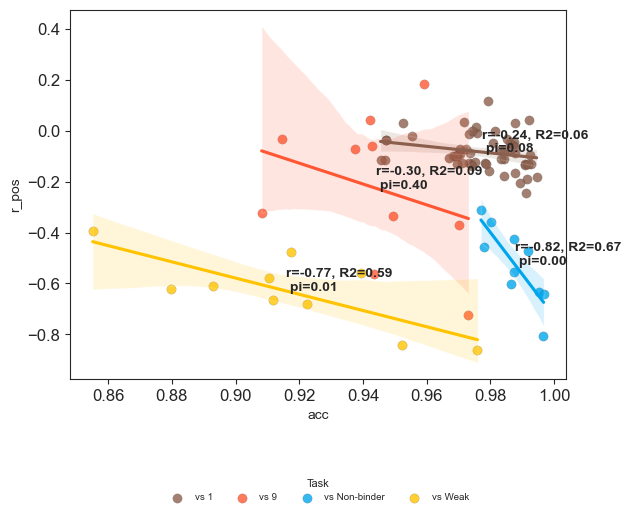

In [39]:
#need this plot
plt.rcParams['svg.fonttype'] = 'none'
cmap = { 'vs 9' : '#FF5733',
         'vs Non-binder':'#00A6ED',
         'vs Weak':'#FFC300',
         'vs 1': '#8B5F4D'}

sns.set_style("white")
sns.set_style('ticks')
fig, ax = plt.subplots()

# Line plot in seaborn with R2 regression
for task, df_g in df_logits_perf_means.groupby("train_task"):
    sns.regplot(
        x="acc",
        y="r_pos",
        data=df_g,
        scatter=True,
        ax=ax,
        label=task,
        color=cmap[task],
        scatter_kws={'edgecolor': 'black', 'linewidth': 0.1, 's':45} 

    )

    # Compute Pearson correlation
    r, pval = pearsonr(df_g["acc"], df_g["r_pos"])
    # Add text with r and R2 at centroid
    x = df_g["acc"].mean()
    y = df_g["r_pos"].mean()
    ax.text(x, y, f"r={r:.2f}, R2={r**2:.2f} \n pi={pval:.2f}" , fontsize=10, fontweight="bold")

FONT_SIZE = 12
ax.tick_params(labelsize=FONT_SIZE)
ax.legend(
    bbox_to_anchor=(0.5, -0.3),
    loc="center",
    borderaxespad=0.0,
    fontsize=7,
    title="Task",
    title_fontsize=8,
    ncol=10,
    frameon=False)

#get_regression_correlatrion("jsd", "acc", df_jsds_wo_dupl, ax, "Task")

#ax.set_xlabel("Jensen-Shannon Divergence", fontsize=FONT_SIZE)
#ax.set_ylabel(yaxis_title, fontsize=FONT_SIZE)
#yticks = np.arange(0.85, 1.0, 0.05)
#ax.set_yticks(yticks)


# put legend to the bottom
fig.show()
fig.savefig('./figures/section2/loguts_energy_r.svg')

In [40]:
df_attrib_pred = df_attrib[['task_type', 'ag_pos', 'ag_neg', 'seed_id', 'split_id', 'mean_pos_total']].copy()
df_attrib_pred.rename(columns={'task_type':'train_task', 'ag_pos':'train_ag', 'ag_neg':'train_neg'}, inplace=True)
df_attrib_pred['train_task'] = df_attrib_pred['train_task'].apply(lambda x: folder_2_task[x])

In [41]:
df_attrib_pred
df_attrib_pred = df_attrib_pred.merge(df_closed, how='inner', on=['train_task', 'train_ag', 'train_neg', 'seed_id', 'split_id'])

In [42]:
df_attrib_pred_means = seed_split_dupl_filter(df_attrib_pred)

/var/folders/ww/bptfq9n12_jbyy78qcjp7s4c0000gn/T/ipykernel_70590/1968578959.py:53: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


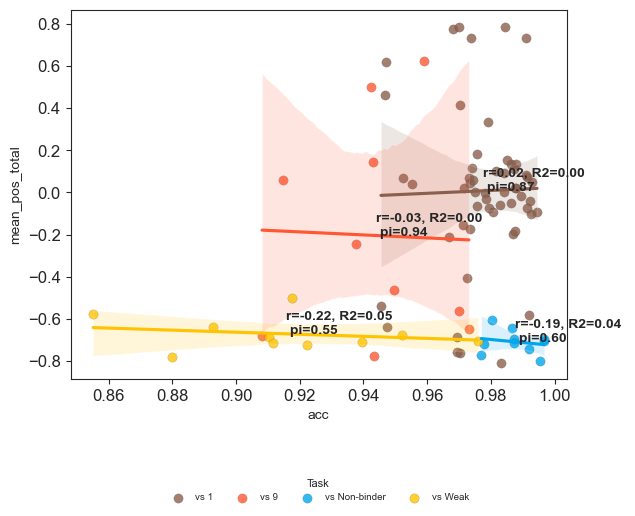

In [43]:
cmap = { 'vs 9' : '#FF5733',
         'vs Non-binder':'#00A6ED',
         'vs Weak':'#FFC300',
         'vs 1': '#8B5F4D'}

sns.set_style("white")
sns.set_style('ticks')
fig, ax = plt.subplots()

# Line plot in seaborn with R2 regression
for task, df_g in df_attrib_pred_means.groupby("train_task"):
    sns.regplot(
        x="acc",
        y="mean_pos_total",
        data=df_g,
        scatter=True,
        ax=ax,
        label=task,
        color=cmap[task],
        scatter_kws={'edgecolor': 'black', 'linewidth': 0.1, 's':45} 

    )

    # Compute Pearson correlation
    r, pval = pearsonr(df_g["acc"], df_g["mean_pos_total"])
    # Add text with r and R2 at centroid
    x = df_g["acc"].mean()
    y = df_g["mean_pos_total"].mean()
    ax.text(x, y, f"r={r:.2f}, R2={r**2:.2f} \n pi={pval:.2f}" , fontsize=10, fontweight="bold")

FONT_SIZE = 12
ax.tick_params(labelsize=FONT_SIZE)
ax.legend(
    bbox_to_anchor=(0.5, -0.3),
    loc="center",
    borderaxespad=0.0,
    fontsize=7,
    title="Task",
    title_fontsize=8,
    ncol=10,
    frameon=False,
)

#get_regression_correlatrion("jsd", "acc", df_jsds_wo_dupl, ax, "Task")

#ax.set_xlabel("Jensen-Shannon Divergence", fontsize=FONT_SIZE)
#ax.set_ylabel(yaxis_title, fontsize=FONT_SIZE)
#yticks = np.arange(0.85, 1.0, 0.05)
#ax.set_yticks(yticks)


# put legend to the bottom
fig.show()
fig.savefig('./figures/section2/attr_energy_per_aa.svg')

In [382]:
df_attr_revcan_pred = df_attr_revcan[['task_type', 'ag_pos', 'ag_neg', 'seed_id', 'split_id', 'mean_pos_total']].copy()
df_attr_revcan_pred.rename(columns={'task_type':'train_task', 'ag_pos':'train_ag', 'ag_neg':'train_neg'}, inplace=True)
df_attr_revcan_pred['train_task'] = df_attr_revcan_pred['train_task'].apply(lambda x: folder_2_task[x])

df_attr_revcan_pred = df_attr_revcan_pred.merge(df_closed, how='inner', on=['train_task', 'train_ag', 'train_neg', 'seed_id', 'split_id'])

In [383]:
df_attr_revcan_pred_means = seed_split_dupl_filter(df_attr_revcan_pred)

/var/folders/ww/bptfq9n12_jbyy78qcjp7s4c0000gn/T/ipykernel_1973/4199665684.py:51: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


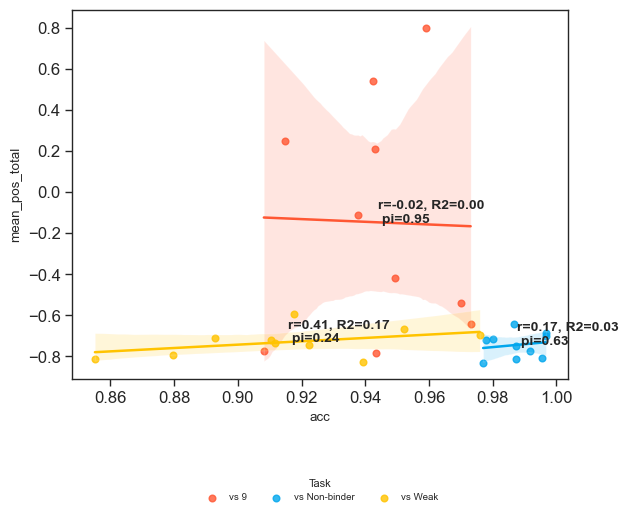

In [386]:
cmap = { 'vs 9' : '#FF5733',
         'vs Non-binder':'#00A6ED',
         'vs Weak':'#FFC300',
         'vs 1': '#8B5F4D'}

sns.set_style("white")
sns.set_style('ticks')
fig, ax = plt.subplots()

# Line plot in seaborn with R2 regression
for task, df_g in df_attr_revcan_pred_means.groupby("train_task"):
    sns.regplot(
        x="acc",
        y="mean_pos_total",
        data=df_g,
        scatter=True,
        ax=ax,
        label=task,
        color=cmap[task],
    )

    # Compute Pearson correlation
    r, pval = pearsonr(df_g["acc"], df_g["mean_pos_total"])
    # Add text with r and R2 at centroid
    x = df_g["acc"].mean()
    y = df_g["mean_pos_total"].mean()
    ax.text(x, y, f"r={r:.2f}, R2={r**2:.2f} \n pi={pval:.2f}" , fontsize=10, fontweight="bold")

FONT_SIZE = 12
ax.tick_params(labelsize=FONT_SIZE)
ax.legend(
    bbox_to_anchor=(0.5, -0.3),
    loc="center",
    borderaxespad=0.0,
    fontsize=7,
    title="Task",
    title_fontsize=8,
    ncol=10,
    frameon=False,
)

#get_regression_correlatrion("jsd", "acc", df_jsds_wo_dupl, ax, "Task")

#ax.set_xlabel("Jensen-Shannon Divergence", fontsize=FONT_SIZE)
#ax.set_ylabel(yaxis_title, fontsize=FONT_SIZE)
#yticks = np.arange(0.85, 1.0, 0.05)
#ax.set_yticks(yticks)


# put legend to the bottom
fig.show()
fig.savefig('./figures/section2/attr_energy_per_aa_reveal_cancel.svg')